In [117]:
# Basic Libraries
# Pandas will be used to read data
import pandas as pd
import numpy as 
import os





from scipy.io import wavfile
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from tensorflow.keras.layers import Dropout, Dense, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc

In [119]:
# make a class with all the configuration parameters - I think we dont use this
class Config:
    def __init__(self, nfilt=26, nfeat=13, nfft=2400, rate=44100):
        self.nfilt = nfilt
        self.nfeat = nfeat
        self.nfft = nfft
        self.rate = rate
        self.step = (rate/10)
        # each step is 1/10th of a second 
        # will be 4410 values for 0.1 seconds

config = Config()
print(config.step)

4410.0


In [22]:

# df_rand.index

In [23]:
# print(X.shape)
# x=X[:30]
# print(x.shape)

In [121]:
#1
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

#testing :)
def convert_data(wav_filename): #this converts to mel spec, ideally would want to try stft as well, maybe output will be better
    # Load the audio file
    my_audio_as_np_array, my_sample_rate = librosa.load(wav_filename, sr=44100)
#n_fft is 2400 bcz highest freq ~1200, so we doubled that
    # Compute the Mel spectrogram
    spec = librosa.feature.melspectrogram(y=my_audio_as_np_array,
                                          sr=my_sample_rate, 
                                          n_fft=2400, 
                                          hop_length=512, 
                                          win_length=None, 
                                          window='hann', 
                                          center=True, 
                                          pad_mode='reflect', 
                                          power=2.0,
                                          n_mels=128)
    
    # Compute the number of frames to cover the entire audio
    total_samples = len(my_audio_as_np_array)
    num_frames = 1 + (total_samples - 2400) // 512
    return spec[:, :num_frames]


(128, 254)


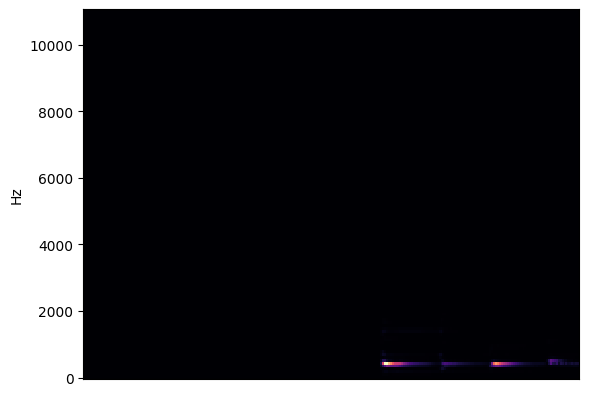

In [122]:
#2
#converting and drawing spectrogram
import IPython.display as ipd
specto = convert_data('C:\\Users\\abdul\\Desktop\\ProjectNeuralNetworks\\segments\\DataSample1_segment_0.wav')
print(specto.shape)
librosa.display.specshow(specto, y_axis='linear')

In [123]:
#3 testing to see that it properly converts back
import soundfile as sf


res = librosa.feature.inverse.mel_to_audio(specto, 
                                           sr=44100, 
                                           n_fft=2400,
                                           hop_length=512, 
                                           win_length=None, 
                                           window='hann', 
                                           center=True, 
                                           pad_mode='reflect', 
                                           power=2, 
                                           n_iter=32)

  #res = RESHAPE(res)
sf.write( "C:\\Users\\abdul\\Desktop\\ProjectNeuralNetworks\\jazz.wav" , res, 44100)

#this was all to test if we can regenerate our file

In [124]:
import os
import librosa
import numpy as np
#we normalize the spectrograms of all the .wav files so we can feed them to our gan .
# minimizes risk of exploding/vanishing gradients (hopefully) 
samples_df = pd.read_csv('C:\\Users\\abdul\\Desktop\\ProjectNeuralNetworks\\SamplesUsed.csv')
# Initialize an empty list to hold all spectrograms
spectrograms = []
db=[]
# Process each file
for index, row in samples_df.iterrows():
    # Load the audio file
    wav_filename = row['fname']
    wav_file = f'C:\\Users\\abdul\\Desktop\\ProjectNeuralNetworks\\segments\\{wav_filename}'

    y, sr = librosa.load(wav_file, sr=44100)

    # Compute the Mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2400, hop_length=512, win_length=None, window='hann',
                                   center=True, pad_mode='reflect', power=2.0, n_mels=128)

    # Convert to dB
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Normalize the spectrogram values to be between 0 and 1
    S_normalized = (S_dB - S_dB.min()) / (S_dB.max() - S_dB.min())

    # Append the normalized spectrogram to our list
    spectrograms.append(S_normalized)
    db.append(S_dB)

db_arr=np.array(S_dB)
# Convert the list of spectrograms to a 3D NumPy array


In [28]:
# adding the channel dimension and padding it so the 3rd dimension (259) is now a value that can
#be obtained using a generator (512) 
spectrograms_with_channel = [np.expand_dims(spec, -1) for spec in spectrograms]
specto_array = np.array(spectrograms_with_channel)
padding = (512-specto_array.shape[2],0)
specto_array=np.pad(specto_array,((0,0),(0,0),padding,(0,0)))
# Check the shape of the resulting array
print(specto_array.shape)

(2679, 128, 512, 1)


In [29]:
#saving max and min to de-normalize later
max_dB=S_dB.max()
min_dB=S_dB.min()
print(min_dB)


-80.0


In [30]:
#testing to see if we can de-normalize properly, unfortunately the result is sub-par, 
# but we are not sure how else to normalize/de-normalize
#it might be partly due to the fact that we're using a mel spectrogram and that loses information
#perhaps more so after being normalized
#we would have liked to use stft but had no time
#we believe if we comparaed jazz1 to our generated sample, it would appear that our gan works alot better
#however, our goal is to produce oud samples, not whatever is in that .wav file
import soundfile as sf

reverted_spectrograms = []

# Process each normalized spectrogram
for S_normalized in spectrograms[0]:
    # Inverse normalization
    S_unorm = S_normalized * (max_dB - min_dB) + max_dB #for some rzn, min dB is -ve but large, so treating that as max

    # Remove padding if necessary (assuming you had added padding to the second axis)
    # S_dB = S_dB[:, :original_second_axis_length]

    # Append the reverted spectrogram to our list
    reverted_spectrograms.append(S_unorm)

# print(S_unorm)
fake=np.array(reverted_spectrograms)
fake=fake.reshape(128,259)
print(fake.shape)

# print(S_normalized)

res = librosa.feature.inverse.mel_to_audio(fake, 
                                           sr=44100, 
                                           n_fft=2400,
                                           hop_length=512, 
                                           win_length=None, 
                                           window='hann', 
                                           center=True, 
                                           pad_mode='reflect', 
                                           power=2, 
                                           n_iter=32)

  #res = RESHAPE(res)
sf.write( "C:\\Users\\abdul\\Desktop\\ProjectNeuralNetworks\\jazz1.wav" , res, 44100)

(128, 259)


In [36]:
# split X into train and test
from sklearn.model_selection import train_test_split
X_train, X_test= train_test_split(specto_array, random_state = 1)

print(X_train.shape)
print(X_test.shape)


(2009, 128, 512, 1)
(670, 128, 512, 1)


In [39]:
import numpy as np 
import matplotlib.pyplot as plt 
import keras 
from keras.layers import Input, Dense, Reshape, Flatten, Dropout 
from keras.layers import BatchNormalization, Activation, ZeroPadding2D 
from keras.layers import LeakyReLU 
from keras.layers import UpSampling2D, Conv2D, Conv2DTranspose, Cropping2D
from keras.models import Sequential, Model 
from keras.optimizers import Adam,SGD, RMSprop

In [59]:
# Using a generator based on Transpose Convolutions. 
latent_dimensions=100


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU

# from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU

def build_generator():
    model = Sequential()

    # Start with a fully connected layer and reshape
    model.add(Dense(32 * 8 * 8, input_dim=latent_dimensions))
    model.add(Reshape((8, 8, 32)))

    # Upsample to the target size
    model.add(Conv2DTranspose(32, kernel_size=(2,2), strides=(2, 4), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2DTranspose(16, kernel_size=(4,4), strides=(2, 4), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2DTranspose(8, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='tanh'))

    return model


#we experimented with different numbers of layers, kernel sizes, strides. This is the last one we did


In [99]:
#discriminator
from tensorflow.keras.layers import Flatten, Conv2D, Dropout

def build_discriminator(spectrogram_shape):
    model = Sequential()

    model.add(Conv2D(8, kernel_size=(3, 3), strides=(2, 2), input_shape=spectrogram_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.3))

    model.add(Conv2D(16, kernel_size=(3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

#not sure why the discriminator loss was always so low
#as this is not a particularly impressive discriminator

In [100]:

print(specto_array.shape)

(2679, 128, 512, 1)


In [101]:
from tensorflow.keras.models import load_model, save_model


#train funct, called by build_and_train
def train(models, x_train, params):
    """Train the Discriminator and Adversarial Networks
    Alternately train Discriminator and Adversarial networks by batch.
    Discriminator is trained first with properly real and fake images.
    Adversarial is trained next with fake images pretending to be real
    Generate sample images per save_interval.
    Arguments:
        models (list): Generator, Discriminator, Adversarial models
        x_train (tensor): Train images
        params (list) : Networks parameters
    """
    
    # save losses 
    losses = list()
    # the GAN component models
    generator, discriminator, adversarial = models
    # network parameters
    batch_size, latent_size, train_steps, model_name = params
    # the generator image is saved every 500 steps
    save_interval = 40
    # noise vector to see how the generator output evolves during training
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
    # number of elements in train dataset
    train_size = x_train.shape[0]
    for i in tqdm(range(train_steps)):
        # train the discriminator for 1 batch
        # 1 batch of real (label=1.0) and fake images (label=0.0)
        # randomly pick real images from dataset
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]
        # generate fake images from noise using generator 
        # generate noise using uniform distribution
        noise = np.random.uniform(-1.0,
                                  1.0,
                                  size=[batch_size, latent_size])
        # generate fake images
        fake_images = generator.predict(noise)
        # real + fake images = 1 batch of train data
        x = np.concatenate((real_images, fake_images))
        # label real and fake images
        # real images label is 1.0
        y = np.ones([2 * batch_size, 1])
        # fake images label is 0.0
        y[batch_size:, :] = 0.0
        # train discriminator network, log the loss and accuracy
        if i%2==0:
            dloss, dacc = discriminator.train_on_batch(x, y)
            log = "%d: [discriminator loss: %f, acc: %f]" % (i, dloss, dacc)

        if (i + 1) % save_interval == 0 or i == train_steps - 1:
            # Save the generator
            save_model(generator, f'generator_epoch_{i + 1}.h5')
            # Save the discriminator
            save_model(discriminator, f'discriminator_epoch_{i + 1}.h5')
            last_saved=i+1
            
        # train the adversarial network for 1 batch
        # 1 batch of fake images with label=1.0
        # since the discriminator weights 
        # are frozen in adversarial network
        # only the generator is trained
        # generate noise using uniform distribution
        noise = np.random.uniform(-1.0,
                                  1.0, 
                                  size=[batch_size, latent_size])
        # label fake images as real or 1.0
        y = np.ones([batch_size, 1])
        # train the adversarial network 
        # note that unlike in discriminator training, 
        # we do not save the fake images in a variable
        # the fake images go to the discriminator input of the adversarial
        # for classification
        # log the loss and accuracy
        aloss, aacc = adversarial.train_on_batch(noise, y)
        log = "%s [adversarial loss: %f, acc: %f]" % (log, aloss, aacc)
        print(log)
        losses.append(np.array([dloss, dacc, aloss, aacc]))
        # if (i + 1) % save_interval == 0:
        #     # plot generator images on a periodic basis
        #     plot_images(generator,
        #                 noise_input=noise_input,
        #                 show=True,
        #                 step=(i + 1),
        #                 model_name=model_name)
   
    # save the model after training the generator
    # the trained generator can be reloaded for 
    # future MNIST digit generation
    generator.save(model_name)
    
    return losses

In [103]:
#added a bool here because training seemed to stop often
#so would rather save and then load the checkpoint 
def build_and_train_models(LOAD_MODEL=False):

    # Build and compile the GAN model

    if load_model==True:
        generator = load_model('generator_epoch_{last_saved}.h5')
        discriminator = load_model('discriminator_epoch_{last_saved}.h5')
        print("loaded {last_saved} save")

    model_name = "dgan_sound"
    # network parameters
    # the latent or z vector is 100-dim
    latent_size = 100
    batch_size = 32
    train_steps = 500
    lr = 2e-4
    decay = 6e-8
    input_shape = (X_train.shape[1], X_train.shape[2], 1)

    # build discriminator model
    # inputs = Input(shape=input_shape, name='discriminator_input')
  
    # [1] or original paper uses Adam, 
    # but discriminator converges easily with RMSprop
    optimizer = RMSprop(lr=lr, decay=decay)
    discriminator = build_discriminator(spectrogram_shape=specto_array.shape[1:])
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
    discriminator.summary()

    # build generator model
    # input_shape = (latent_size, )
    # inputs = Input(shape=input_shape, name='z_input')
    generator = build_generator()
    generator.summary()

    # build adversarial model
    optimizer = RMSprop(lr=lr * 0.5, decay=decay * 0.5)
    # freeze the weights of discriminator during adversarial training
    discriminator.trainable = False
    # adversarial = generator + discriminator
    adversarial=Sequential()
    adversarial.add(generator)
    adversarial.add(discriminator)
    adversarial.compile(loss='binary_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])
    adversarial.summary()

    # train discriminator and adversarial networks
    models = (generator, discriminator, adversarial)
    params = (batch_size, latent_size, train_steps, model_name)
    return train(models, X_train, params)

In [125]:
last_saved=0 #not always set to 0, should comment it out if decided to continue from a checkpoint
history = build_and_train_models(False)


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 64, 256, 4)        40        
                                                                 


 leaky_re_lu_36 (LeakyReLU)  (None, 64, 256, 4)        0         
                                                                 
 dropout_12 (Dropout)        (None, 64, 256, 4)        0         
                                                                 
 flatten_8 (Flatten)         (None, 65536)             0         
                                                                 
 dense_16 (Dense)            (None, 1)                 65537     
                                                                 
Total params: 65,577
Trainable params: 65,577
Non-trainable params: 0
_________________________________________________________________


c:\Users\abdul\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 2048)              206848    
                                                                 
 reshape_8 (Reshape)         (None, 8, 8, 32)          0         
                                                                 
 conv2d_transpose_32 (Conv2D  (None, 16, 32, 32)       4128      
 Transpose)                                                      
                                                                 
 batch_normalization_24 (Bat  (None, 16, 32, 32)       128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_37 (LeakyReLU)  (None, 16, 32, 32)        0         
                                                                 
 conv2d_transpose_33 (Conv2D  (None, 32, 128, 16)    

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 113ms/step


  0%|          | 1/500 [00:01<13:30,  1.63s/it]

0: [discriminator loss: 0.643286, acc: 0.921875] [adversarial loss: 2.478608, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


  0%|          | 2/500 [00:01<06:57,  1.19it/s]

0: [discriminator loss: 0.643286, acc: 0.921875] [adversarial loss: 2.478608, acc: 0.000000] [adversarial loss: 2.313466, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


  1%|          | 3/500 [00:02<04:41,  1.76it/s]

2: [discriminator loss: 0.454936, acc: 1.000000] [adversarial loss: 3.220955, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


  1%|          | 4/500 [00:02<03:25,  2.42it/s]

2: [discriminator loss: 0.454936, acc: 1.000000] [adversarial loss: 3.220955, acc: 0.000000] [adversarial loss: 3.125885, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


  1%|          | 5/500 [00:02<02:37,  3.15it/s]

4: [discriminator loss: 0.410548, acc: 1.000000] [adversarial loss: 4.402039, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


  1%|          | 6/500 [00:02<02:02,  4.03it/s]

4: [discriminator loss: 0.410548, acc: 1.000000] [adversarial loss: 4.402039, acc: 0.000000] [adversarial loss: 4.236038, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


  1%|▏         | 7/500 [00:02<01:47,  4.58it/s]

6: [discriminator loss: 0.389772, acc: 1.000000] [adversarial loss: 5.628163, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


  2%|▏         | 8/500 [00:02<01:32,  5.30it/s]

6: [discriminator loss: 0.389772, acc: 1.000000] [adversarial loss: 5.628163, acc: 0.000000] [adversarial loss: 5.403144, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


  2%|▏         | 9/500 [00:03<01:27,  5.60it/s]

8: [discriminator loss: 0.362915, acc: 1.000000] [adversarial loss: 6.752812, acc: 0.000000]
1/1 [==============================] - 0s 24ms/step


  2%|▏         | 10/500 [00:03<01:17,  6.31it/s]

8: [discriminator loss: 0.362915, acc: 1.000000] [adversarial loss: 6.752812, acc: 0.000000] [adversarial loss: 6.543956, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


  2%|▏         | 11/500 [00:03<01:17,  6.28it/s]

10: [discriminator loss: 0.350139, acc: 1.000000] [adversarial loss: 7.809815, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


  2%|▏         | 12/500 [00:03<01:11,  6.84it/s]

10: [discriminator loss: 0.350139, acc: 1.000000] [adversarial loss: 7.809815, acc: 0.000000] [adversarial loss: 7.535907, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 13/500 [00:03<01:13,  6.60it/s]

12: [discriminator loss: 0.323235, acc: 1.000000] [adversarial loss: 8.712125, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 14/500 [00:03<01:09,  7.04it/s]

12: [discriminator loss: 0.323235, acc: 1.000000] [adversarial loss: 8.712125, acc: 0.000000] [adversarial loss: 8.459634, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


  3%|▎         | 15/500 [00:03<01:11,  6.82it/s]

14: [discriminator loss: 0.310393, acc: 1.000000] [adversarial loss: 9.570458, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 16/500 [00:03<01:04,  7.48it/s]

14: [discriminator loss: 0.310393, acc: 1.000000] [adversarial loss: 9.570458, acc: 0.000000] [adversarial loss: 9.280617, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 17/500 [00:04<01:09,  6.96it/s]

16: [discriminator loss: 0.293178, acc: 1.000000] [adversarial loss: 10.238764, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


  4%|▎         | 18/500 [00:04<01:05,  7.40it/s]

16: [discriminator loss: 0.293178, acc: 1.000000] [adversarial loss: 10.238764, acc: 0.000000] [adversarial loss: 10.012712, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


  4%|▍         | 19/500 [00:04<01:09,  6.97it/s]

18: [discriminator loss: 0.267796, acc: 1.000000] [adversarial loss: 10.935406, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


  4%|▍         | 20/500 [00:04<01:05,  7.35it/s]

18: [discriminator loss: 0.267796, acc: 1.000000] [adversarial loss: 10.935406, acc: 0.000000] [adversarial loss: 10.775137, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


  4%|▍         | 21/500 [00:04<01:09,  6.88it/s]

20: [discriminator loss: 0.256540, acc: 1.000000] [adversarial loss: 11.446363, acc: 0.000000]
1/1 [==============================] - 0s 23ms/step


  4%|▍         | 22/500 [00:04<01:06,  7.18it/s]

20: [discriminator loss: 0.256540, acc: 1.000000] [adversarial loss: 11.446363, acc: 0.000000] [adversarial loss: 11.315479, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


  5%|▍         | 23/500 [00:04<01:09,  6.84it/s]

22: [discriminator loss: 0.235282, acc: 1.000000] [adversarial loss: 12.032809, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


  5%|▍         | 24/500 [00:05<01:06,  7.20it/s]

22: [discriminator loss: 0.235282, acc: 1.000000] [adversarial loss: 12.032809, acc: 0.000000] [adversarial loss: 11.808781, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


  5%|▌         | 25/500 [00:05<01:08,  6.92it/s]

24: [discriminator loss: 0.223719, acc: 1.000000] [adversarial loss: 12.507269, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


  5%|▌         | 26/500 [00:05<01:04,  7.38it/s]

24: [discriminator loss: 0.223719, acc: 1.000000] [adversarial loss: 12.507269, acc: 0.000000] [adversarial loss: 12.292418, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


  5%|▌         | 27/500 [00:05<01:08,  6.89it/s]

26: [discriminator loss: 0.214088, acc: 1.000000] [adversarial loss: 12.797423, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 28/500 [00:05<01:04,  7.35it/s]

26: [discriminator loss: 0.214088, acc: 1.000000] [adversarial loss: 12.797423, acc: 0.000000] [adversarial loss: 12.750644, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 29/500 [00:05<01:07,  6.99it/s]

28: [discriminator loss: 0.206754, acc: 1.000000] [adversarial loss: 13.086240, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


  6%|▌         | 30/500 [00:05<01:03,  7.45it/s]

28: [discriminator loss: 0.206754, acc: 1.000000] [adversarial loss: 13.086240, acc: 0.000000] [adversarial loss: 12.875166, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 31/500 [00:06<01:05,  7.12it/s]

30: [discriminator loss: 0.178719, acc: 1.000000] [adversarial loss: 13.437523, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


  6%|▋         | 32/500 [00:06<01:01,  7.65it/s]

30: [discriminator loss: 0.178719, acc: 1.000000] [adversarial loss: 13.437523, acc: 0.000000] [adversarial loss: 13.134250, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 33/500 [00:06<01:03,  7.31it/s]

32: [discriminator loss: 0.174659, acc: 1.000000] [adversarial loss: 13.636324, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 34/500 [00:06<01:00,  7.68it/s]

32: [discriminator loss: 0.174659, acc: 1.000000] [adversarial loss: 13.636324, acc: 0.000000] [adversarial loss: 13.404490, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 35/500 [00:06<01:04,  7.20it/s]

34: [discriminator loss: 0.165083, acc: 1.000000] [adversarial loss: 13.771832, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 36/500 [00:06<01:03,  7.34it/s]

34: [discriminator loss: 0.165083, acc: 1.000000] [adversarial loss: 13.771832, acc: 0.000000] [adversarial loss: 13.614363, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


  7%|▋         | 37/500 [00:06<01:08,  6.79it/s]

36: [discriminator loss: 0.144298, acc: 1.000000] [adversarial loss: 14.027180, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


  8%|▊         | 38/500 [00:07<01:04,  7.14it/s]

36: [discriminator loss: 0.144298, acc: 1.000000] [adversarial loss: 14.027180, acc: 0.000000] [adversarial loss: 13.817768, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 39/500 [00:07<01:06,  6.91it/s]

38: [discriminator loss: 0.141575, acc: 1.000000] [adversarial loss: 14.162626, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


  8%|▊         | 40/500 [00:07<01:09,  6.59it/s]

38: [discriminator loss: 0.141575, acc: 1.000000] [adversarial loss: 14.162626, acc: 0.000000] [adversarial loss: 13.904148, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 41/500 [00:07<01:11,  6.40it/s]

40: [discriminator loss: 0.130999, acc: 1.000000] [adversarial loss: 14.194279, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 42/500 [00:07<01:05,  6.95it/s]

40: [discriminator loss: 0.130999, acc: 1.000000] [adversarial loss: 14.194279, acc: 0.000000] [adversarial loss: 14.042456, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


  9%|▊         | 43/500 [00:07<01:08,  6.68it/s]

42: [discriminator loss: 0.124492, acc: 1.000000] [adversarial loss: 14.207787, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


  9%|▉         | 44/500 [00:07<01:04,  7.06it/s]

42: [discriminator loss: 0.124492, acc: 1.000000] [adversarial loss: 14.207787, acc: 0.000000] [adversarial loss: 14.055197, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


  9%|▉         | 45/500 [00:08<01:06,  6.85it/s]

44: [discriminator loss: 0.117107, acc: 1.000000] [adversarial loss: 14.208038, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


  9%|▉         | 46/500 [00:08<01:02,  7.28it/s]

44: [discriminator loss: 0.117107, acc: 1.000000] [adversarial loss: 14.208038, acc: 0.000000] [adversarial loss: 14.137018, acc: 0.000000]
1/1 [==============================] - 0s 32ms/step


  9%|▉         | 47/500 [00:08<01:09,  6.52it/s]

46: [discriminator loss: 0.105989, acc: 1.000000] [adversarial loss: 14.251031, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 10%|▉         | 48/500 [00:08<01:05,  6.92it/s]

46: [discriminator loss: 0.105989, acc: 1.000000] [adversarial loss: 14.251031, acc: 0.000000] [adversarial loss: 14.101503, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 10%|▉         | 49/500 [00:08<01:07,  6.69it/s]

48: [discriminator loss: 0.096543, acc: 1.000000] [adversarial loss: 14.385260, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 10%|█         | 50/500 [00:08<01:03,  7.09it/s]

48: [discriminator loss: 0.096543, acc: 1.000000] [adversarial loss: 14.385260, acc: 0.000000] [adversarial loss: 14.120580, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


 10%|█         | 51/500 [00:08<01:06,  6.74it/s]

50: [discriminator loss: 0.095305, acc: 1.000000] [adversarial loss: 14.271758, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 10%|█         | 52/500 [00:09<01:02,  7.22it/s]

50: [discriminator loss: 0.095305, acc: 1.000000] [adversarial loss: 14.271758, acc: 0.000000] [adversarial loss: 14.022036, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 11%|█         | 53/500 [00:09<01:04,  6.94it/s]

52: [discriminator loss: 0.083799, acc: 1.000000] [adversarial loss: 14.181692, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 11%|█         | 54/500 [00:09<01:01,  7.31it/s]

52: [discriminator loss: 0.083799, acc: 1.000000] [adversarial loss: 14.181692, acc: 0.000000] [adversarial loss: 14.169401, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 11%|█         | 55/500 [00:09<01:04,  6.90it/s]

54: [discriminator loss: 0.087034, acc: 1.000000] [adversarial loss: 14.134645, acc: 0.000000]
1/1 [==============================] - 0s 24ms/step


 11%|█         | 56/500 [00:09<01:02,  7.10it/s]

54: [discriminator loss: 0.087034, acc: 1.000000] [adversarial loss: 14.134645, acc: 0.000000] [adversarial loss: 14.012733, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 57/500 [00:09<01:07,  6.61it/s]

56: [discriminator loss: 0.074827, acc: 1.000000] [adversarial loss: 14.099495, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 58/500 [00:09<01:01,  7.18it/s]

56: [discriminator loss: 0.074827, acc: 1.000000] [adversarial loss: 14.099495, acc: 0.000000] [adversarial loss: 13.991366, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 59/500 [00:10<01:03,  6.95it/s]

58: [discriminator loss: 0.072970, acc: 1.000000] [adversarial loss: 14.083694, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 60/500 [00:10<00:58,  7.49it/s]

58: [discriminator loss: 0.072970, acc: 1.000000] [adversarial loss: 14.083694, acc: 0.000000] [adversarial loss: 13.904100, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 61/500 [00:10<01:03,  6.95it/s]

60: [discriminator loss: 0.068865, acc: 1.000000] [adversarial loss: 13.993865, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 62/500 [00:10<00:59,  7.33it/s]

60: [discriminator loss: 0.068865, acc: 1.000000] [adversarial loss: 13.993865, acc: 0.000000] [adversarial loss: 13.741554, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 63/500 [00:10<01:02,  7.03it/s]

62: [discriminator loss: 0.060174, acc: 1.000000] [adversarial loss: 13.986345, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 64/500 [00:10<00:58,  7.41it/s]

62: [discriminator loss: 0.060174, acc: 1.000000] [adversarial loss: 13.986345, acc: 0.000000] [adversarial loss: 13.790405, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 65/500 [00:10<01:02,  6.97it/s]

64: [discriminator loss: 0.057307, acc: 1.000000] [adversarial loss: 13.839314, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 66/500 [00:11<00:58,  7.41it/s]

64: [discriminator loss: 0.057307, acc: 1.000000] [adversarial loss: 13.839314, acc: 0.000000] [adversarial loss: 13.654856, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 67/500 [00:11<01:02,  6.95it/s]

66: [discriminator loss: 0.072021, acc: 1.000000] [adversarial loss: 13.696499, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 14%|█▎        | 68/500 [00:11<00:58,  7.41it/s]

66: [discriminator loss: 0.072021, acc: 1.000000] [adversarial loss: 13.696499, acc: 0.000000] [adversarial loss: 13.437782, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 69/500 [00:11<01:01,  6.98it/s]

68: [discriminator loss: 0.062459, acc: 0.984375] [adversarial loss: 13.358822, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 70/500 [00:11<00:59,  7.22it/s]

68: [discriminator loss: 0.062459, acc: 0.984375] [adversarial loss: 13.358822, acc: 0.000000] [adversarial loss: 13.234940, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 71/500 [00:11<01:01,  6.94it/s]

70: [discriminator loss: 0.058097, acc: 1.000000] [adversarial loss: 13.303940, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 72/500 [00:11<00:58,  7.31it/s]

70: [discriminator loss: 0.058097, acc: 1.000000] [adversarial loss: 13.303940, acc: 0.000000] [adversarial loss: 13.139756, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 73/500 [00:12<01:03,  6.73it/s]

72: [discriminator loss: 0.062723, acc: 1.000000] [adversarial loss: 13.104058, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 74/500 [00:12<01:00,  7.05it/s]

72: [discriminator loss: 0.062723, acc: 1.000000] [adversarial loss: 13.104058, acc: 0.000000] [adversarial loss: 12.932730, acc: 0.000000]
1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 75/500 [00:12<01:05,  6.49it/s]

74: [discriminator loss: 0.053178, acc: 1.000000] [adversarial loss: 12.859285, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 76/500 [00:12<01:00,  6.96it/s]

74: [discriminator loss: 0.053178, acc: 1.000000] [adversarial loss: 12.859285, acc: 0.000000] [adversarial loss: 12.743656, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 77/500 [00:12<01:05,  6.47it/s]

76: [discriminator loss: 0.047077, acc: 1.000000] [adversarial loss: 12.850476, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 78/500 [00:12<01:01,  6.82it/s]

76: [discriminator loss: 0.047077, acc: 1.000000] [adversarial loss: 12.850476, acc: 0.000000] [adversarial loss: 12.681707, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 79/500 [00:12<01:05,  6.44it/s]

78: [discriminator loss: 0.043100, acc: 1.000000] [adversarial loss: 12.706377, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 80/500 [00:13<01:07,  6.24it/s]

78: [discriminator loss: 0.043100, acc: 1.000000] [adversarial loss: 12.706377, acc: 0.000000] [adversarial loss: 12.622529, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 81/500 [00:13<01:08,  6.11it/s]

80: [discriminator loss: 0.041512, acc: 1.000000] [adversarial loss: 12.681868, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 82/500 [00:13<01:02,  6.64it/s]

80: [discriminator loss: 0.041512, acc: 1.000000] [adversarial loss: 12.681868, acc: 0.000000] [adversarial loss: 12.612459, acc: 0.000000]
1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 83/500 [00:13<01:07,  6.16it/s]

82: [discriminator loss: 0.045321, acc: 1.000000] [adversarial loss: 12.499762, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 84/500 [00:13<01:02,  6.67it/s]

82: [discriminator loss: 0.045321, acc: 1.000000] [adversarial loss: 12.499762, acc: 0.000000] [adversarial loss: 12.459012, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 85/500 [00:13<01:04,  6.40it/s]

84: [discriminator loss: 0.036701, acc: 1.000000] [adversarial loss: 12.384861, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 86/500 [00:14<00:59,  6.94it/s]

84: [discriminator loss: 0.036701, acc: 1.000000] [adversarial loss: 12.384861, acc: 0.000000] [adversarial loss: 12.440422, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 87/500 [00:14<01:03,  6.54it/s]

86: [discriminator loss: 0.038130, acc: 1.000000] [adversarial loss: 12.256329, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 88/500 [00:14<00:58,  6.99it/s]

86: [discriminator loss: 0.038130, acc: 1.000000] [adversarial loss: 12.256329, acc: 0.000000] [adversarial loss: 12.205979, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 89/500 [00:14<01:00,  6.79it/s]

88: [discriminator loss: 0.045204, acc: 1.000000] [adversarial loss: 12.044669, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 90/500 [00:14<00:56,  7.21it/s]

88: [discriminator loss: 0.045204, acc: 1.000000] [adversarial loss: 12.044669, acc: 0.000000] [adversarial loss: 11.934846, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 91/500 [00:14<01:03,  6.41it/s]

90: [discriminator loss: 0.030897, acc: 1.000000] [adversarial loss: 12.003962, acc: 0.000000]
1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 92/500 [00:14<00:59,  6.83it/s]

90: [discriminator loss: 0.030897, acc: 1.000000] [adversarial loss: 12.003962, acc: 0.000000] [adversarial loss: 11.936410, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 93/500 [00:15<01:01,  6.66it/s]

92: [discriminator loss: 0.030456, acc: 1.000000] [adversarial loss: 12.033316, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 94/500 [00:15<00:57,  7.03it/s]

92: [discriminator loss: 0.030456, acc: 1.000000] [adversarial loss: 12.033316, acc: 0.000000] [adversarial loss: 11.863220, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 95/500 [00:15<01:00,  6.72it/s]

94: [discriminator loss: 0.030380, acc: 1.000000] [adversarial loss: 11.939483, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 96/500 [00:15<00:56,  7.09it/s]

94: [discriminator loss: 0.030380, acc: 1.000000] [adversarial loss: 11.939483, acc: 0.000000] [adversarial loss: 11.756806, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 97/500 [00:15<01:00,  6.68it/s]

96: [discriminator loss: 0.042195, acc: 1.000000] [adversarial loss: 11.529022, acc: 0.000000]
1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 98/500 [00:15<00:57,  7.00it/s]

96: [discriminator loss: 0.042195, acc: 1.000000] [adversarial loss: 11.529022, acc: 0.000000] [adversarial loss: 11.495351, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 99/500 [00:15<01:00,  6.62it/s]

98: [discriminator loss: 0.027506, acc: 1.000000] [adversarial loss: 11.588979, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 20%|██        | 100/500 [00:16<00:56,  7.03it/s]

98: [discriminator loss: 0.027506, acc: 1.000000] [adversarial loss: 11.588979, acc: 0.000000] [adversarial loss: 11.395264, acc: 0.000000]
1/1 [==============================] - 0s 24ms/step


 20%|██        | 101/500 [00:16<01:02,  6.35it/s]

100: [discriminator loss: 0.025928, acc: 1.000000] [adversarial loss: 11.462346, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


 20%|██        | 102/500 [00:16<00:59,  6.71it/s]

100: [discriminator loss: 0.025928, acc: 1.000000] [adversarial loss: 11.462346, acc: 0.000000] [adversarial loss: 11.413860, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 21%|██        | 103/500 [00:16<01:01,  6.43it/s]

102: [discriminator loss: 0.038576, acc: 0.984375] [adversarial loss: 11.156342, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


 21%|██        | 104/500 [00:16<00:58,  6.76it/s]

102: [discriminator loss: 0.038576, acc: 0.984375] [adversarial loss: 11.156342, acc: 0.000000] [adversarial loss: 11.037746, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 21%|██        | 105/500 [00:16<01:01,  6.46it/s]

104: [discriminator loss: 0.034313, acc: 0.984375] [adversarial loss: 11.044640, acc: 0.000000]
1/1 [==============================] - 0s 24ms/step


 21%|██        | 106/500 [00:17<00:57,  6.84it/s]

104: [discriminator loss: 0.034313, acc: 0.984375] [adversarial loss: 11.044640, acc: 0.000000] [adversarial loss: 10.851602, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 107/500 [00:17<01:00,  6.45it/s]

106: [discriminator loss: 0.024812, acc: 1.000000] [adversarial loss: 10.906546, acc: 0.000000]
1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 108/500 [00:17<00:58,  6.75it/s]

106: [discriminator loss: 0.024812, acc: 1.000000] [adversarial loss: 10.906546, acc: 0.000000] [adversarial loss: 10.875721, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 109/500 [00:17<01:00,  6.49it/s]

108: [discriminator loss: 0.022833, acc: 1.000000] [adversarial loss: 10.907789, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 110/500 [00:17<00:57,  6.78it/s]

108: [discriminator loss: 0.022833, acc: 1.000000] [adversarial loss: 10.907789, acc: 0.000000] [adversarial loss: 10.825612, acc: 0.000000]
1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 111/500 [00:17<01:03,  6.09it/s]

110: [discriminator loss: 0.023400, acc: 1.000000] [adversarial loss: 10.747922, acc: 0.000000]
1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 112/500 [00:17<01:00,  6.41it/s]

110: [discriminator loss: 0.023400, acc: 1.000000] [adversarial loss: 10.747922, acc: 0.000000] [adversarial loss: 10.697226, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 113/500 [00:18<01:02,  6.23it/s]

112: [discriminator loss: 0.030302, acc: 1.000000] [adversarial loss: 10.559728, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 114/500 [00:18<00:57,  6.71it/s]

112: [discriminator loss: 0.030302, acc: 1.000000] [adversarial loss: 10.559728, acc: 0.000000] [adversarial loss: 10.396000, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 115/500 [00:18<00:59,  6.44it/s]

114: [discriminator loss: 0.020586, acc: 1.000000] [adversarial loss: 10.640690, acc: 0.000000]
1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 116/500 [00:18<00:57,  6.70it/s]

114: [discriminator loss: 0.020586, acc: 1.000000] [adversarial loss: 10.640690, acc: 0.000000] [adversarial loss: 10.495708, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 117/500 [00:18<01:01,  6.24it/s]

116: [discriminator loss: 0.020025, acc: 1.000000] [adversarial loss: 10.551716, acc: 0.000000]
1/1 [==============================] - 0s 24ms/step


 24%|██▎       | 118/500 [00:18<00:59,  6.46it/s]

116: [discriminator loss: 0.020025, acc: 1.000000] [adversarial loss: 10.551716, acc: 0.000000] [adversarial loss: 10.421491, acc: 0.000000]
1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 119/500 [00:19<01:01,  6.19it/s]

118: [discriminator loss: 0.021157, acc: 1.000000] [adversarial loss: 10.469350, acc: 0.000000]
1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 120/500 [00:19<01:06,  5.71it/s]

118: [discriminator loss: 0.021157, acc: 1.000000] [adversarial loss: 10.469350, acc: 0.000000] [adversarial loss: 10.284689, acc: 0.000000]
1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 121/500 [00:19<01:07,  5.64it/s]

120: [discriminator loss: 0.017782, acc: 1.000000] [adversarial loss: 10.421023, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 122/500 [00:19<01:01,  6.16it/s]

120: [discriminator loss: 0.017782, acc: 1.000000] [adversarial loss: 10.421023, acc: 0.000000] [adversarial loss: 10.286911, acc: 0.000000]
1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 123/500 [00:19<01:04,  5.89it/s]

122: [discriminator loss: 0.022133, acc: 1.000000] [adversarial loss: 10.146547, acc: 0.000000]
1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 124/500 [00:19<01:00,  6.23it/s]

122: [discriminator loss: 0.022133, acc: 1.000000] [adversarial loss: 10.146547, acc: 0.000000] [adversarial loss: 10.104841, acc: 0.000000]
1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 125/500 [00:20<01:03,  5.91it/s]

124: [discriminator loss: 0.030500, acc: 0.984375] [adversarial loss: 10.024179, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 126/500 [00:20<00:58,  6.40it/s]

124: [discriminator loss: 0.030500, acc: 0.984375] [adversarial loss: 10.024179, acc: 0.000000] [adversarial loss: 9.856050, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 127/500 [00:20<01:01,  6.08it/s]

126: [discriminator loss: 0.017865, acc: 1.000000] [adversarial loss: 9.857745, acc: 0.000000]
1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 128/500 [00:20<00:58,  6.39it/s]

126: [discriminator loss: 0.017865, acc: 1.000000] [adversarial loss: 9.857745, acc: 0.000000] [adversarial loss: 9.782687, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 129/500 [00:20<01:01,  6.04it/s]

128: [discriminator loss: 0.016915, acc: 1.000000] [adversarial loss: 9.856533, acc: 0.000000]
1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 130/500 [00:20<00:58,  6.34it/s]

128: [discriminator loss: 0.016915, acc: 1.000000] [adversarial loss: 9.856533, acc: 0.000000] [adversarial loss: 9.715712, acc: 0.000000]
1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 131/500 [00:21<01:01,  6.01it/s]

130: [discriminator loss: 0.021156, acc: 1.000000] [adversarial loss: 9.665377, acc: 0.000000]
1/1 [==============================] - 0s 35ms/step


 26%|██▋       | 132/500 [00:21<00:59,  6.17it/s]

130: [discriminator loss: 0.021156, acc: 1.000000] [adversarial loss: 9.665377, acc: 0.000000] [adversarial loss: 9.616350, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 133/500 [00:21<01:01,  5.95it/s]

132: [discriminator loss: 0.017786, acc: 1.000000] [adversarial loss: 9.629969, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 134/500 [00:21<00:57,  6.35it/s]

132: [discriminator loss: 0.017786, acc: 1.000000] [adversarial loss: 9.629969, acc: 0.000000] [adversarial loss: 9.593396, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 135/500 [00:21<00:59,  6.18it/s]

134: [discriminator loss: 0.038720, acc: 0.984375] [adversarial loss: 9.132722, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 136/500 [00:21<00:55,  6.60it/s]

134: [discriminator loss: 0.038720, acc: 0.984375] [adversarial loss: 9.132722, acc: 0.000000] [adversarial loss: 9.056138, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 137/500 [00:21<00:56,  6.38it/s]

136: [discriminator loss: 0.017303, acc: 1.000000] [adversarial loss: 9.264418, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 138/500 [00:22<00:53,  6.78it/s]

136: [discriminator loss: 0.017303, acc: 1.000000] [adversarial loss: 9.264418, acc: 0.000000] [adversarial loss: 9.088966, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 139/500 [00:22<00:55,  6.55it/s]

138: [discriminator loss: 0.025534, acc: 1.000000] [adversarial loss: 9.003128, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 140/500 [00:22<00:51,  6.98it/s]

138: [discriminator loss: 0.025534, acc: 1.000000] [adversarial loss: 9.003128, acc: 0.000000] [adversarial loss: 8.880322, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 141/500 [00:22<00:53,  6.76it/s]

140: [discriminator loss: 0.017290, acc: 1.000000] [adversarial loss: 9.081587, acc: 0.000000]
1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 142/500 [00:22<00:52,  6.88it/s]

140: [discriminator loss: 0.017290, acc: 1.000000] [adversarial loss: 9.081587, acc: 0.000000] [adversarial loss: 8.916698, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 143/500 [00:22<00:54,  6.60it/s]

142: [discriminator loss: 0.016895, acc: 1.000000] [adversarial loss: 8.853497, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 144/500 [00:22<00:50,  7.04it/s]

142: [discriminator loss: 0.016895, acc: 1.000000] [adversarial loss: 8.853497, acc: 0.000000] [adversarial loss: 8.859481, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 145/500 [00:23<00:52,  6.70it/s]

144: [discriminator loss: 0.015498, acc: 1.000000] [adversarial loss: 8.921120, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 146/500 [00:23<00:50,  7.07it/s]

144: [discriminator loss: 0.015498, acc: 1.000000] [adversarial loss: 8.921120, acc: 0.000000] [adversarial loss: 8.813513, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 147/500 [00:23<00:52,  6.68it/s]

146: [discriminator loss: 0.015062, acc: 1.000000] [adversarial loss: 8.876015, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 148/500 [00:23<00:49,  7.07it/s]

146: [discriminator loss: 0.015062, acc: 1.000000] [adversarial loss: 8.876015, acc: 0.000000] [adversarial loss: 8.763475, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 149/500 [00:23<00:51,  6.76it/s]

148: [discriminator loss: 0.022093, acc: 1.000000] [adversarial loss: 8.701066, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 30%|███       | 150/500 [00:23<00:49,  7.09it/s]

148: [discriminator loss: 0.022093, acc: 1.000000] [adversarial loss: 8.701066, acc: 0.000000] [adversarial loss: 8.547343, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 30%|███       | 151/500 [00:24<00:52,  6.60it/s]

150: [discriminator loss: 0.014485, acc: 1.000000] [adversarial loss: 8.557476, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 30%|███       | 152/500 [00:24<00:48,  7.15it/s]

150: [discriminator loss: 0.014485, acc: 1.000000] [adversarial loss: 8.557476, acc: 0.000000] [adversarial loss: 8.448519, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 31%|███       | 153/500 [00:24<00:50,  6.88it/s]

152: [discriminator loss: 0.013565, acc: 1.000000] [adversarial loss: 8.603254, acc: 0.000000]
1/1 [==============================] - 0s 23ms/step


 31%|███       | 154/500 [00:24<00:47,  7.23it/s]

152: [discriminator loss: 0.013565, acc: 1.000000] [adversarial loss: 8.603254, acc: 0.000000] [adversarial loss: 8.529201, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 31%|███       | 155/500 [00:24<00:50,  6.85it/s]

154: [discriminator loss: 0.012958, acc: 1.000000] [adversarial loss: 8.655113, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 31%|███       | 156/500 [00:24<00:47,  7.20it/s]

154: [discriminator loss: 0.012958, acc: 1.000000] [adversarial loss: 8.655113, acc: 0.000000] [adversarial loss: 8.472581, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 157/500 [00:24<00:51,  6.63it/s]

156: [discriminator loss: 0.013658, acc: 1.000000] [adversarial loss: 8.521423, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 158/500 [00:25<00:48,  7.02it/s]

156: [discriminator loss: 0.013658, acc: 1.000000] [adversarial loss: 8.521423, acc: 0.000000] [adversarial loss: 8.398817, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 159/500 [00:25<00:50,  6.81it/s]

158: [discriminator loss: 0.013916, acc: 1.000000] [adversarial loss: 8.428907, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 160/500 [00:25<00:52,  6.46it/s]

158: [discriminator loss: 0.013916, acc: 1.000000] [adversarial loss: 8.428907, acc: 0.000000] [adversarial loss: 8.315237, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 161/500 [00:25<00:54,  6.17it/s]

160: [discriminator loss: 0.011832, acc: 1.000000] [adversarial loss: 8.325672, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 162/500 [00:25<00:51,  6.63it/s]

160: [discriminator loss: 0.011832, acc: 1.000000] [adversarial loss: 8.325672, acc: 0.000000] [adversarial loss: 8.259940, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 163/500 [00:25<00:52,  6.41it/s]

162: [discriminator loss: 0.011736, acc: 1.000000] [adversarial loss: 8.326382, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 164/500 [00:25<00:49,  6.79it/s]

162: [discriminator loss: 0.011736, acc: 1.000000] [adversarial loss: 8.326382, acc: 0.000000] [adversarial loss: 8.179998, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 165/500 [00:26<00:51,  6.56it/s]

164: [discriminator loss: 0.077443, acc: 0.953125] [adversarial loss: 7.670178, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 166/500 [00:26<00:48,  6.95it/s]

164: [discriminator loss: 0.077443, acc: 0.953125] [adversarial loss: 7.670178, acc: 0.000000] [adversarial loss: 7.463538, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 167/500 [00:26<00:50,  6.58it/s]

166: [discriminator loss: 0.017911, acc: 1.000000] [adversarial loss: 7.522805, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 34%|███▎      | 168/500 [00:26<00:47,  7.05it/s]

166: [discriminator loss: 0.017911, acc: 1.000000] [adversarial loss: 7.522805, acc: 0.000000] [adversarial loss: 7.473402, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 169/500 [00:26<00:48,  6.89it/s]

168: [discriminator loss: 0.014757, acc: 1.000000] [adversarial loss: 7.467039, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 170/500 [00:26<00:44,  7.36it/s]

168: [discriminator loss: 0.014757, acc: 1.000000] [adversarial loss: 7.467039, acc: 0.000000] [adversarial loss: 7.347015, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 171/500 [00:26<00:46,  7.02it/s]

170: [discriminator loss: 0.014478, acc: 1.000000] [adversarial loss: 7.433766, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 172/500 [00:27<00:43,  7.48it/s]

170: [discriminator loss: 0.014478, acc: 1.000000] [adversarial loss: 7.433766, acc: 0.000000] [adversarial loss: 7.512061, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 173/500 [00:27<00:46,  7.05it/s]

172: [discriminator loss: 0.024185, acc: 1.000000] [adversarial loss: 7.315788, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 174/500 [00:27<00:44,  7.38it/s]

172: [discriminator loss: 0.024185, acc: 1.000000] [adversarial loss: 7.315788, acc: 0.000000] [adversarial loss: 7.171826, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 175/500 [00:27<00:45,  7.07it/s]

174: [discriminator loss: 0.022243, acc: 1.000000] [adversarial loss: 7.161263, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 176/500 [00:27<00:44,  7.34it/s]

174: [discriminator loss: 0.022243, acc: 1.000000] [adversarial loss: 7.161263, acc: 0.000000] [adversarial loss: 7.009404, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 177/500 [00:27<00:46,  6.99it/s]

176: [discriminator loss: 0.023672, acc: 1.000000] [adversarial loss: 7.032735, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 178/500 [00:27<00:43,  7.46it/s]

176: [discriminator loss: 0.023672, acc: 1.000000] [adversarial loss: 7.032735, acc: 0.000000] [adversarial loss: 6.866478, acc: 0.000000]
1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 179/500 [00:28<00:46,  6.86it/s]

178: [discriminator loss: 0.015850, acc: 1.000000] [adversarial loss: 6.854177, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 180/500 [00:28<00:43,  7.36it/s]

178: [discriminator loss: 0.015850, acc: 1.000000] [adversarial loss: 6.854177, acc: 0.000000] [adversarial loss: 6.919915, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 181/500 [00:28<00:45,  6.96it/s]

180: [discriminator loss: 0.014428, acc: 1.000000] [adversarial loss: 6.963243, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 182/500 [00:28<00:43,  7.35it/s]

180: [discriminator loss: 0.014428, acc: 1.000000] [adversarial loss: 6.963243, acc: 0.000000] [adversarial loss: 6.814786, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 183/500 [00:28<00:45,  7.00it/s]

182: [discriminator loss: 0.019330, acc: 1.000000] [adversarial loss: 6.823327, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 184/500 [00:28<00:42,  7.42it/s]

182: [discriminator loss: 0.019330, acc: 1.000000] [adversarial loss: 6.823327, acc: 0.000000] [adversarial loss: 6.763939, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 185/500 [00:28<00:45,  6.96it/s]

184: [discriminator loss: 0.013192, acc: 1.000000] [adversarial loss: 6.771657, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 186/500 [00:29<00:42,  7.42it/s]

184: [discriminator loss: 0.013192, acc: 1.000000] [adversarial loss: 6.771657, acc: 0.000000] [adversarial loss: 6.742308, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 187/500 [00:29<00:44,  6.98it/s]

186: [discriminator loss: 0.013358, acc: 1.000000] [adversarial loss: 6.730252, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 188/500 [00:29<00:41,  7.49it/s]

186: [discriminator loss: 0.013358, acc: 1.000000] [adversarial loss: 6.730252, acc: 0.000000] [adversarial loss: 6.728578, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 189/500 [00:29<00:44,  7.02it/s]

188: [discriminator loss: 0.013945, acc: 1.000000] [adversarial loss: 6.677527, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 190/500 [00:29<00:42,  7.29it/s]

188: [discriminator loss: 0.013945, acc: 1.000000] [adversarial loss: 6.677527, acc: 0.000000] [adversarial loss: 6.697723, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 191/500 [00:29<00:45,  6.84it/s]

190: [discriminator loss: 0.012034, acc: 1.000000] [adversarial loss: 6.785096, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 192/500 [00:29<00:42,  7.22it/s]

190: [discriminator loss: 0.012034, acc: 1.000000] [adversarial loss: 6.785096, acc: 0.000000] [adversarial loss: 6.735120, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 39%|███▊      | 193/500 [00:30<00:44,  6.84it/s]

192: [discriminator loss: 0.011430, acc: 1.000000] [adversarial loss: 6.768680, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 194/500 [00:30<00:42,  7.28it/s]

192: [discriminator loss: 0.011430, acc: 1.000000] [adversarial loss: 6.768680, acc: 0.000000] [adversarial loss: 6.612157, acc: 0.000000]
1/1 [==============================] - 0s 15ms/step


 39%|███▉      | 195/500 [00:30<00:43,  6.96it/s]

194: [discriminator loss: 0.011608, acc: 1.000000] [adversarial loss: 6.768178, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 196/500 [00:30<00:40,  7.42it/s]

194: [discriminator loss: 0.011608, acc: 1.000000] [adversarial loss: 6.768178, acc: 0.000000] [adversarial loss: 6.660262, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 197/500 [00:30<00:43,  6.91it/s]

196: [discriminator loss: 0.010541, acc: 1.000000] [adversarial loss: 6.729563, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 198/500 [00:30<00:41,  7.33it/s]

196: [discriminator loss: 0.010541, acc: 1.000000] [adversarial loss: 6.729563, acc: 0.000000] [adversarial loss: 6.685069, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 199/500 [00:30<00:43,  6.93it/s]

198: [discriminator loss: 0.012999, acc: 1.000000] [adversarial loss: 6.704393, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 40%|████      | 200/500 [00:31<00:45,  6.55it/s]

198: [discriminator loss: 0.012999, acc: 1.000000] [adversarial loss: 6.704393, acc: 0.000000] [adversarial loss: 6.560124, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 40%|████      | 201/500 [00:31<00:46,  6.44it/s]

200: [discriminator loss: 0.053762, acc: 0.968750] [adversarial loss: 6.129191, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 40%|████      | 202/500 [00:31<00:43,  6.86it/s]

200: [discriminator loss: 0.053762, acc: 0.968750] [adversarial loss: 6.129191, acc: 0.000000] [adversarial loss: 6.114259, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 41%|████      | 203/500 [00:31<00:44,  6.70it/s]

202: [discriminator loss: 0.012446, acc: 1.000000] [adversarial loss: 6.224015, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 41%|████      | 204/500 [00:31<00:41,  7.20it/s]

202: [discriminator loss: 0.012446, acc: 1.000000] [adversarial loss: 6.224015, acc: 0.000000] [adversarial loss: 6.115442, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 41%|████      | 205/500 [00:31<00:42,  6.97it/s]

204: [discriminator loss: 0.011934, acc: 1.000000] [adversarial loss: 6.193642, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 41%|████      | 206/500 [00:31<00:39,  7.38it/s]

204: [discriminator loss: 0.011934, acc: 1.000000] [adversarial loss: 6.193642, acc: 0.000000] [adversarial loss: 6.076895, acc: 0.000000]
1/1 [==============================] - 0s 15ms/step


 41%|████▏     | 207/500 [00:32<00:42,  6.96it/s]

206: [discriminator loss: 0.012600, acc: 1.000000] [adversarial loss: 6.146205, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 208/500 [00:32<00:39,  7.40it/s]

206: [discriminator loss: 0.012600, acc: 1.000000] [adversarial loss: 6.146205, acc: 0.000000] [adversarial loss: 6.064115, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 209/500 [00:32<00:40,  7.15it/s]

208: [discriminator loss: 0.016932, acc: 1.000000] [adversarial loss: 5.988549, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 210/500 [00:32<00:38,  7.59it/s]

208: [discriminator loss: 0.016932, acc: 1.000000] [adversarial loss: 5.988549, acc: 0.000000] [adversarial loss: 5.894336, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 211/500 [00:32<00:41,  7.04it/s]

210: [discriminator loss: 0.010929, acc: 1.000000] [adversarial loss: 6.034507, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 212/500 [00:32<00:38,  7.47it/s]

210: [discriminator loss: 0.010929, acc: 1.000000] [adversarial loss: 6.034507, acc: 0.000000] [adversarial loss: 6.020744, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 213/500 [00:32<00:40,  7.13it/s]

212: [discriminator loss: 0.021668, acc: 0.984375] [adversarial loss: 5.908525, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 214/500 [00:32<00:39,  7.32it/s]

212: [discriminator loss: 0.021668, acc: 0.984375] [adversarial loss: 5.908525, acc: 0.000000] [adversarial loss: 5.834085, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 215/500 [00:33<00:41,  6.91it/s]

214: [discriminator loss: 0.010817, acc: 1.000000] [adversarial loss: 5.966751, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 216/500 [00:33<00:39,  7.15it/s]

214: [discriminator loss: 0.010817, acc: 1.000000] [adversarial loss: 5.966751, acc: 0.000000] [adversarial loss: 5.835382, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 217/500 [00:33<00:42,  6.68it/s]

216: [discriminator loss: 0.009910, acc: 1.000000] [adversarial loss: 5.945587, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 218/500 [00:33<00:41,  6.74it/s]

216: [discriminator loss: 0.009910, acc: 1.000000] [adversarial loss: 5.945587, acc: 0.000000] [adversarial loss: 5.740160, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 219/500 [00:33<00:45,  6.24it/s]

218: [discriminator loss: 0.019163, acc: 1.000000] [adversarial loss: 5.862437, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 220/500 [00:33<00:42,  6.54it/s]

218: [discriminator loss: 0.019163, acc: 1.000000] [adversarial loss: 5.862437, acc: 0.000000] [adversarial loss: 5.710050, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 221/500 [00:34<00:44,  6.22it/s]

220: [discriminator loss: 0.010184, acc: 1.000000] [adversarial loss: 5.759453, acc: 0.000000]
1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 222/500 [00:34<00:42,  6.47it/s]

220: [discriminator loss: 0.010184, acc: 1.000000] [adversarial loss: 5.759453, acc: 0.000000] [adversarial loss: 5.726151, acc: 0.000000]
1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 223/500 [00:34<00:45,  6.04it/s]

222: [discriminator loss: 0.010009, acc: 1.000000] [adversarial loss: 5.801689, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 224/500 [00:34<00:43,  6.31it/s]

222: [discriminator loss: 0.010009, acc: 1.000000] [adversarial loss: 5.801689, acc: 0.000000] [adversarial loss: 5.687197, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 225/500 [00:34<00:46,  5.97it/s]

224: [discriminator loss: 0.027968, acc: 0.984375] [adversarial loss: 5.418194, acc: 0.000000]
1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 226/500 [00:34<00:43,  6.23it/s]

224: [discriminator loss: 0.027968, acc: 0.984375] [adversarial loss: 5.418194, acc: 0.000000] [adversarial loss: 5.318188, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 227/500 [00:35<00:46,  5.86it/s]

226: [discriminator loss: 0.014383, acc: 1.000000] [adversarial loss: 5.336469, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 228/500 [00:35<00:44,  6.15it/s]

226: [discriminator loss: 0.014383, acc: 1.000000] [adversarial loss: 5.336469, acc: 0.000000] [adversarial loss: 5.301408, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 229/500 [00:35<00:45,  5.94it/s]

228: [discriminator loss: 0.010369, acc: 1.000000] [adversarial loss: 5.448961, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 230/500 [00:35<00:42,  6.29it/s]

228: [discriminator loss: 0.010369, acc: 1.000000] [adversarial loss: 5.448961, acc: 0.000000] [adversarial loss: 5.335204, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 231/500 [00:35<00:46,  5.79it/s]

230: [discriminator loss: 0.009604, acc: 1.000000] [adversarial loss: 5.385640, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 232/500 [00:35<00:43,  6.15it/s]

230: [discriminator loss: 0.009604, acc: 1.000000] [adversarial loss: 5.385640, acc: 0.000000] [adversarial loss: 5.393548, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 233/500 [00:36<00:45,  5.88it/s]

232: [discriminator loss: 0.009028, acc: 1.000000] [adversarial loss: 5.578023, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 234/500 [00:36<00:43,  6.14it/s]

232: [discriminator loss: 0.009028, acc: 1.000000] [adversarial loss: 5.578023, acc: 0.000000] [adversarial loss: 5.407851, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 235/500 [00:36<00:44,  5.98it/s]

234: [discriminator loss: 0.024032, acc: 0.984375] [adversarial loss: 5.102934, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 236/500 [00:36<00:41,  6.39it/s]

234: [discriminator loss: 0.024032, acc: 0.984375] [adversarial loss: 5.102934, acc: 0.000000] [adversarial loss: 5.244410, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 237/500 [00:36<00:45,  5.79it/s]

236: [discriminator loss: 0.009660, acc: 1.000000] [adversarial loss: 5.267166, acc: 0.000000]
1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 238/500 [00:36<00:42,  6.14it/s]

236: [discriminator loss: 0.009660, acc: 1.000000] [adversarial loss: 5.267166, acc: 0.000000] [adversarial loss: 5.177721, acc: 0.000000]
1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 239/500 [00:37<00:45,  5.71it/s]

238: [discriminator loss: 0.008628, acc: 1.000000] [adversarial loss: 5.324477, acc: 0.000000]
1/1 [==============================] - 0s 24ms/step


238: [discriminator loss: 0.008628, acc: 1.000000] [adversarial loss: 5.324477, acc: 0.000000] [adversarial loss: 5.269063, acc: 0.000000]

 48%|████▊     | 240/500 [00:37<00:47,  5.48it/s]


1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 241/500 [00:37<00:49,  5.27it/s]

240: [discriminator loss: 0.009125, acc: 1.000000] [adversarial loss: 5.235935, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 242/500 [00:37<00:44,  5.74it/s]

240: [discriminator loss: 0.009125, acc: 1.000000] [adversarial loss: 5.235935, acc: 0.000000] [adversarial loss: 5.148400, acc: 0.000000]
1/1 [==============================] - 0s 35ms/step


 49%|████▊     | 243/500 [00:37<00:46,  5.48it/s]

242: [discriminator loss: 0.007847, acc: 1.000000] [adversarial loss: 5.324502, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 244/500 [00:37<00:42,  6.04it/s]

242: [discriminator loss: 0.007847, acc: 1.000000] [adversarial loss: 5.324502, acc: 0.000000] [adversarial loss: 5.255677, acc: 0.000000]
1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 245/500 [00:38<00:44,  5.71it/s]

244: [discriminator loss: 0.008190, acc: 1.000000] [adversarial loss: 5.318815, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 246/500 [00:38<00:40,  6.25it/s]

244: [discriminator loss: 0.008190, acc: 1.000000] [adversarial loss: 5.318815, acc: 0.000000] [adversarial loss: 5.197227, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 247/500 [00:38<00:41,  6.13it/s]

246: [discriminator loss: 0.016982, acc: 1.000000] [adversarial loss: 5.059832, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 248/500 [00:38<00:37,  6.66it/s]

246: [discriminator loss: 0.016982, acc: 1.000000] [adversarial loss: 5.059832, acc: 0.000000] [adversarial loss: 5.055747, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 249/500 [00:38<00:38,  6.51it/s]

248: [discriminator loss: 0.008395, acc: 1.000000] [adversarial loss: 5.074260, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 50%|█████     | 250/500 [00:38<00:36,  6.91it/s]

248: [discriminator loss: 0.008395, acc: 1.000000] [adversarial loss: 5.074260, acc: 0.000000] [adversarial loss: 5.144814, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 50%|█████     | 251/500 [00:39<00:37,  6.71it/s]

250: [discriminator loss: 0.015403, acc: 1.000000] [adversarial loss: 4.876869, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 50%|█████     | 252/500 [00:39<00:34,  7.11it/s]

250: [discriminator loss: 0.015403, acc: 1.000000] [adversarial loss: 4.876869, acc: 0.000000] [adversarial loss: 4.814860, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 51%|█████     | 253/500 [00:39<00:36,  6.73it/s]

252: [discriminator loss: 0.011263, acc: 1.000000] [adversarial loss: 4.881087, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 51%|█████     | 254/500 [00:39<00:34,  7.05it/s]

252: [discriminator loss: 0.011263, acc: 1.000000] [adversarial loss: 4.881087, acc: 0.000000] [adversarial loss: 4.764370, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 51%|█████     | 255/500 [00:39<00:35,  6.82it/s]

254: [discriminator loss: 0.016766, acc: 1.000000] [adversarial loss: 4.801474, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 51%|█████     | 256/500 [00:39<00:33,  7.28it/s]

254: [discriminator loss: 0.016766, acc: 1.000000] [adversarial loss: 4.801474, acc: 0.000000] [adversarial loss: 4.517746, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 257/500 [00:39<00:35,  6.75it/s]

256: [discriminator loss: 0.009127, acc: 1.000000] [adversarial loss: 4.710632, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 258/500 [00:40<00:33,  7.16it/s]

256: [discriminator loss: 0.009127, acc: 1.000000] [adversarial loss: 4.710632, acc: 0.000000] [adversarial loss: 4.531155, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 259/500 [00:40<00:36,  6.55it/s]

258: [discriminator loss: 0.008461, acc: 1.000000] [adversarial loss: 4.742402, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 260/500 [00:40<00:34,  7.03it/s]

258: [discriminator loss: 0.008461, acc: 1.000000] [adversarial loss: 4.742402, acc: 0.000000] [adversarial loss: 4.739457, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 261/500 [00:40<00:35,  6.69it/s]

260: [discriminator loss: 0.007906, acc: 1.000000] [adversarial loss: 4.775987, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 262/500 [00:40<00:33,  7.05it/s]

260: [discriminator loss: 0.007906, acc: 1.000000] [adversarial loss: 4.775987, acc: 0.000000] [adversarial loss: 4.644585, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 263/500 [00:40<00:35,  6.76it/s]

262: [discriminator loss: 0.007357, acc: 1.000000] [adversarial loss: 4.840144, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 264/500 [00:40<00:32,  7.15it/s]

262: [discriminator loss: 0.007357, acc: 1.000000] [adversarial loss: 4.840144, acc: 0.000000] [adversarial loss: 4.766247, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 265/500 [00:41<00:34,  6.87it/s]

264: [discriminator loss: 0.007688, acc: 1.000000] [adversarial loss: 4.903088, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 266/500 [00:41<00:31,  7.35it/s]

264: [discriminator loss: 0.007688, acc: 1.000000] [adversarial loss: 4.903088, acc: 0.000000] [adversarial loss: 4.794893, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 267/500 [00:41<00:33,  6.98it/s]

266: [discriminator loss: 0.023898, acc: 0.984375] [adversarial loss: 4.447840, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 268/500 [00:41<00:31,  7.44it/s]

266: [discriminator loss: 0.023898, acc: 0.984375] [adversarial loss: 4.447840, acc: 0.000000] [adversarial loss: 4.481184, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 269/500 [00:41<00:32,  7.07it/s]

268: [discriminator loss: 0.008221, acc: 1.000000] [adversarial loss: 4.584049, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 270/500 [00:41<00:30,  7.42it/s]

268: [discriminator loss: 0.008221, acc: 1.000000] [adversarial loss: 4.584049, acc: 0.000000] [adversarial loss: 4.527214, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 271/500 [00:41<00:32,  7.05it/s]

270: [discriminator loss: 0.007415, acc: 1.000000] [adversarial loss: 4.589962, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 272/500 [00:41<00:30,  7.43it/s]

270: [discriminator loss: 0.007415, acc: 1.000000] [adversarial loss: 4.589962, acc: 0.000000] [adversarial loss: 4.625527, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 273/500 [00:42<00:31,  7.17it/s]

272: [discriminator loss: 0.007262, acc: 1.000000] [adversarial loss: 4.736698, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 274/500 [00:42<00:29,  7.62it/s]

272: [discriminator loss: 0.007262, acc: 1.000000] [adversarial loss: 4.736698, acc: 0.000000] [adversarial loss: 4.558032, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 275/500 [00:42<00:30,  7.29it/s]

274: [discriminator loss: 0.006692, acc: 1.000000] [adversarial loss: 4.665218, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 276/500 [00:42<00:28,  7.75it/s]

274: [discriminator loss: 0.006692, acc: 1.000000] [adversarial loss: 4.665218, acc: 0.000000] [adversarial loss: 4.590990, acc: 0.000000]
1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 277/500 [00:42<00:30,  7.28it/s]

276: [discriminator loss: 0.006810, acc: 1.000000] [adversarial loss: 4.680398, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 278/500 [00:42<00:28,  7.74it/s]

276: [discriminator loss: 0.006810, acc: 1.000000] [adversarial loss: 4.680398, acc: 0.000000] [adversarial loss: 4.614979, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 279/500 [00:42<00:29,  7.40it/s]

278: [discriminator loss: 0.006760, acc: 1.000000] [adversarial loss: 4.745882, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 280/500 [00:43<00:32,  6.72it/s]

278: [discriminator loss: 0.006760, acc: 1.000000] [adversarial loss: 4.745882, acc: 0.000000] [adversarial loss: 4.588515, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 281/500 [00:43<00:32,  6.65it/s]

280: [discriminator loss: 0.006025, acc: 1.000000] [adversarial loss: 4.616671, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 282/500 [00:43<00:30,  7.14it/s]

280: [discriminator loss: 0.006025, acc: 1.000000] [adversarial loss: 4.616671, acc: 0.000000] [adversarial loss: 4.658805, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 283/500 [00:43<00:31,  6.86it/s]

282: [discriminator loss: 0.005868, acc: 1.000000] [adversarial loss: 4.924682, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 284/500 [00:43<00:29,  7.23it/s]

282: [discriminator loss: 0.005868, acc: 1.000000] [adversarial loss: 4.924682, acc: 0.000000] [adversarial loss: 4.672524, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 285/500 [00:43<00:30,  6.95it/s]

284: [discriminator loss: 0.028927, acc: 0.984375] [adversarial loss: 4.326137, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 286/500 [00:43<00:29,  7.33it/s]

284: [discriminator loss: 0.028927, acc: 0.984375] [adversarial loss: 4.326137, acc: 0.000000] [adversarial loss: 4.147909, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 287/500 [00:44<00:30,  7.00it/s]

286: [discriminator loss: 0.007287, acc: 1.000000] [adversarial loss: 4.345357, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 288/500 [00:44<00:28,  7.45it/s]

286: [discriminator loss: 0.007287, acc: 1.000000] [adversarial loss: 4.345357, acc: 0.000000] [adversarial loss: 4.325562, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 289/500 [00:44<00:29,  7.06it/s]

288: [discriminator loss: 0.008624, acc: 1.000000] [adversarial loss: 4.202650, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 290/500 [00:44<00:28,  7.40it/s]

288: [discriminator loss: 0.008624, acc: 1.000000] [adversarial loss: 4.202650, acc: 0.000000] [adversarial loss: 4.212417, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 291/500 [00:44<00:29,  7.01it/s]

290: [discriminator loss: 0.006976, acc: 1.000000] [adversarial loss: 4.263965, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 292/500 [00:44<00:28,  7.36it/s]

290: [discriminator loss: 0.006976, acc: 1.000000] [adversarial loss: 4.263965, acc: 0.000000] [adversarial loss: 4.210930, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 59%|█████▊    | 293/500 [00:44<00:29,  6.99it/s]

292: [discriminator loss: 0.006582, acc: 1.000000] [adversarial loss: 4.490232, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 294/500 [00:45<00:28,  7.26it/s]

292: [discriminator loss: 0.006582, acc: 1.000000] [adversarial loss: 4.490232, acc: 0.000000] [adversarial loss: 4.266077, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 295/500 [00:45<00:29,  6.96it/s]

294: [discriminator loss: 0.006218, acc: 1.000000] [adversarial loss: 4.333792, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 296/500 [00:45<00:27,  7.42it/s]

294: [discriminator loss: 0.006218, acc: 1.000000] [adversarial loss: 4.333792, acc: 0.000000] [adversarial loss: 4.307363, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 297/500 [00:45<00:29,  6.86it/s]

296: [discriminator loss: 0.017386, acc: 0.984375] [adversarial loss: 4.132648, acc: 0.000000]
1/1 [==============================] - 0s 15ms/step


 60%|█████▉    | 298/500 [00:45<00:27,  7.38it/s]

296: [discriminator loss: 0.017386, acc: 0.984375] [adversarial loss: 4.132648, acc: 0.000000] [adversarial loss: 4.009164, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 299/500 [00:45<00:28,  7.10it/s]

298: [discriminator loss: 0.007288, acc: 1.000000] [adversarial loss: 4.149459, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 60%|██████    | 300/500 [00:45<00:27,  7.38it/s]

298: [discriminator loss: 0.007288, acc: 1.000000] [adversarial loss: 4.149459, acc: 0.000000] [adversarial loss: 3.926964, acc: 0.000000]
1/1 [==============================] - 0s 15ms/step


 60%|██████    | 301/500 [00:46<00:28,  7.09it/s]

300: [discriminator loss: 0.008110, acc: 1.000000] [adversarial loss: 4.037329, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 60%|██████    | 302/500 [00:46<00:26,  7.56it/s]

300: [discriminator loss: 0.008110, acc: 1.000000] [adversarial loss: 4.037329, acc: 0.000000] [adversarial loss: 3.896253, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 61%|██████    | 303/500 [00:46<00:28,  6.83it/s]

302: [discriminator loss: 0.014266, acc: 1.000000] [adversarial loss: 3.832167, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 61%|██████    | 304/500 [00:46<00:26,  7.32it/s]

302: [discriminator loss: 0.014266, acc: 1.000000] [adversarial loss: 3.832167, acc: 0.000000] [adversarial loss: 3.793046, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 61%|██████    | 305/500 [00:46<00:28,  6.96it/s]

304: [discriminator loss: 0.017687, acc: 1.000000] [adversarial loss: 3.599721, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 61%|██████    | 306/500 [00:46<00:26,  7.29it/s]

304: [discriminator loss: 0.017687, acc: 1.000000] [adversarial loss: 3.599721, acc: 0.000000] [adversarial loss: 3.388651, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 307/500 [00:46<00:28,  6.86it/s]

306: [discriminator loss: 0.008480, acc: 1.000000] [adversarial loss: 3.850929, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 308/500 [00:47<00:26,  7.17it/s]

306: [discriminator loss: 0.008480, acc: 1.000000] [adversarial loss: 3.850929, acc: 0.000000] [adversarial loss: 3.583768, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 309/500 [00:47<00:27,  6.92it/s]

308: [discriminator loss: 0.007867, acc: 1.000000] [adversarial loss: 3.691843, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 310/500 [00:47<00:25,  7.32it/s]

308: [discriminator loss: 0.007867, acc: 1.000000] [adversarial loss: 3.691843, acc: 0.000000] [adversarial loss: 3.663387, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 311/500 [00:47<00:27,  6.84it/s]

310: [discriminator loss: 0.012556, acc: 1.000000] [adversarial loss: 3.681135, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 312/500 [00:47<00:25,  7.30it/s]

310: [discriminator loss: 0.012556, acc: 1.000000] [adversarial loss: 3.681135, acc: 0.000000] [adversarial loss: 3.620724, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 313/500 [00:47<00:26,  6.98it/s]

312: [discriminator loss: 0.014813, acc: 1.000000] [adversarial loss: 3.439346, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 314/500 [00:47<00:25,  7.42it/s]

312: [discriminator loss: 0.014813, acc: 1.000000] [adversarial loss: 3.439346, acc: 0.000000] [adversarial loss: 3.363442, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 315/500 [00:47<00:25,  7.13it/s]

314: [discriminator loss: 0.008407, acc: 1.000000] [adversarial loss: 3.451484, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 316/500 [00:48<00:24,  7.66it/s]

314: [discriminator loss: 0.008407, acc: 1.000000] [adversarial loss: 3.451484, acc: 0.000000] [adversarial loss: 3.466849, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 317/500 [00:48<00:26,  6.98it/s]

316: [discriminator loss: 0.006795, acc: 1.000000] [adversarial loss: 3.474444, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 318/500 [00:48<00:25,  7.26it/s]

316: [discriminator loss: 0.006795, acc: 1.000000] [adversarial loss: 3.474444, acc: 0.000000] [adversarial loss: 3.610770, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 319/500 [00:48<00:26,  6.85it/s]

318: [discriminator loss: 0.016646, acc: 1.000000] [adversarial loss: 3.302827, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 320/500 [00:48<00:27,  6.49it/s]

318: [discriminator loss: 0.016646, acc: 1.000000] [adversarial loss: 3.302827, acc: 0.000000] [adversarial loss: 3.063891, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 321/500 [00:48<00:28,  6.30it/s]

320: [discriminator loss: 0.024897, acc: 0.984375] [adversarial loss: 2.847920, acc: 0.000000]
1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 322/500 [00:49<00:27,  6.48it/s]

320: [discriminator loss: 0.024897, acc: 0.984375] [adversarial loss: 2.847920, acc: 0.000000] [adversarial loss: 2.780118, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 323/500 [00:49<00:28,  6.29it/s]

322: [discriminator loss: 0.010074, acc: 1.000000] [adversarial loss: 2.950962, acc: 0.000000]
1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 324/500 [00:49<00:26,  6.68it/s]

322: [discriminator loss: 0.010074, acc: 1.000000] [adversarial loss: 2.950962, acc: 0.000000] [adversarial loss: 2.810681, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 325/500 [00:49<00:27,  6.40it/s]

324: [discriminator loss: 0.009973, acc: 1.000000] [adversarial loss: 3.164793, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 326/500 [00:49<00:25,  6.83it/s]

324: [discriminator loss: 0.009973, acc: 1.000000] [adversarial loss: 3.164793, acc: 0.000000] [adversarial loss: 3.112099, acc: 0.000000]
1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 327/500 [00:49<00:28,  6.10it/s]

326: [discriminator loss: 0.007902, acc: 1.000000] [adversarial loss: 3.405228, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 328/500 [00:49<00:26,  6.44it/s]

326: [discriminator loss: 0.007902, acc: 1.000000] [adversarial loss: 3.405228, acc: 0.000000] [adversarial loss: 3.126571, acc: 0.000000]
1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 329/500 [00:50<00:28,  6.02it/s]

328: [discriminator loss: 0.006980, acc: 1.000000] [adversarial loss: 3.132995, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 330/500 [00:50<00:26,  6.47it/s]

328: [discriminator loss: 0.006980, acc: 1.000000] [adversarial loss: 3.132995, acc: 0.000000] [adversarial loss: 3.288643, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 331/500 [00:50<00:26,  6.27it/s]

330: [discriminator loss: 0.006902, acc: 1.000000] [adversarial loss: 3.541049, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 332/500 [00:50<00:25,  6.70it/s]

330: [discriminator loss: 0.006902, acc: 1.000000] [adversarial loss: 3.541049, acc: 0.000000] [adversarial loss: 3.467202, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 333/500 [00:50<00:26,  6.37it/s]

332: [discriminator loss: 0.006439, acc: 1.000000] [adversarial loss: 3.405914, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 334/500 [00:50<00:24,  6.77it/s]

332: [discriminator loss: 0.006439, acc: 1.000000] [adversarial loss: 3.405914, acc: 0.000000] [adversarial loss: 3.387223, acc: 0.000000]
1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 335/500 [00:51<00:26,  6.25it/s]

334: [discriminator loss: 0.005529, acc: 1.000000] [adversarial loss: 3.437215, acc: 0.000000]
1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 336/500 [00:51<00:24,  6.57it/s]

334: [discriminator loss: 0.005529, acc: 1.000000] [adversarial loss: 3.437215, acc: 0.000000] [adversarial loss: 3.588412, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 337/500 [00:51<00:26,  6.18it/s]

336: [discriminator loss: 0.005034, acc: 1.000000] [adversarial loss: 3.768097, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 338/500 [00:51<00:25,  6.39it/s]

336: [discriminator loss: 0.005034, acc: 1.000000] [adversarial loss: 3.768097, acc: 0.000000] [adversarial loss: 3.549917, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 339/500 [00:51<00:26,  6.10it/s]

338: [discriminator loss: 0.005127, acc: 1.000000] [adversarial loss: 3.758019, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 340/500 [00:51<00:24,  6.50it/s]

338: [discriminator loss: 0.005127, acc: 1.000000] [adversarial loss: 3.758019, acc: 0.000000] [adversarial loss: 3.620082, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 341/500 [00:52<00:25,  6.20it/s]

340: [discriminator loss: 0.010701, acc: 1.000000] [adversarial loss: 3.252456, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 342/500 [00:52<00:23,  6.65it/s]

340: [discriminator loss: 0.010701, acc: 1.000000] [adversarial loss: 3.252456, acc: 0.000000] [adversarial loss: 3.380042, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 343/500 [00:52<00:24,  6.39it/s]

342: [discriminator loss: 0.005893, acc: 1.000000] [adversarial loss: 3.581796, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 344/500 [00:52<00:23,  6.74it/s]

342: [discriminator loss: 0.005893, acc: 1.000000] [adversarial loss: 3.581796, acc: 0.000000] [adversarial loss: 3.479083, acc: 0.000000]
1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 345/500 [00:52<00:24,  6.28it/s]

344: [discriminator loss: 0.035161, acc: 0.984375] [adversarial loss: 2.911676, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 346/500 [00:52<00:22,  6.77it/s]

344: [discriminator loss: 0.035161, acc: 0.984375] [adversarial loss: 2.911676, acc: 0.000000] [adversarial loss: 2.885751, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 347/500 [00:52<00:24,  6.35it/s]

346: [discriminator loss: 0.008891, acc: 1.000000] [adversarial loss: 3.117997, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 348/500 [00:53<00:22,  6.82it/s]

346: [discriminator loss: 0.008891, acc: 1.000000] [adversarial loss: 3.117997, acc: 0.000000] [adversarial loss: 2.830204, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 349/500 [00:53<00:22,  6.68it/s]

348: [discriminator loss: 0.005978, acc: 1.000000] [adversarial loss: 3.225732, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 70%|███████   | 350/500 [00:53<00:20,  7.18it/s]

348: [discriminator loss: 0.005978, acc: 1.000000] [adversarial loss: 3.225732, acc: 0.000000] [adversarial loss: 3.221155, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 70%|███████   | 351/500 [00:53<00:21,  6.90it/s]

350: [discriminator loss: 0.012101, acc: 1.000000] [adversarial loss: 3.045392, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 70%|███████   | 352/500 [00:53<00:20,  7.18it/s]

350: [discriminator loss: 0.012101, acc: 1.000000] [adversarial loss: 3.045392, acc: 0.000000] [adversarial loss: 2.732875, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 71%|███████   | 353/500 [00:53<00:21,  6.75it/s]

352: [discriminator loss: 0.007311, acc: 1.000000] [adversarial loss: 3.263339, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 71%|███████   | 354/500 [00:53<00:20,  7.10it/s]

352: [discriminator loss: 0.007311, acc: 1.000000] [adversarial loss: 3.263339, acc: 0.000000] [adversarial loss: 3.197958, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 71%|███████   | 355/500 [00:54<00:21,  6.68it/s]

354: [discriminator loss: 0.025065, acc: 0.984375] [adversarial loss: 2.758121, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 71%|███████   | 356/500 [00:54<00:20,  7.15it/s]

354: [discriminator loss: 0.025065, acc: 0.984375] [adversarial loss: 2.758121, acc: 0.000000] [adversarial loss: 2.539273, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 357/500 [00:54<00:21,  6.72it/s]

356: [discriminator loss: 0.007835, acc: 1.000000] [adversarial loss: 2.900379, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 358/500 [00:54<00:19,  7.10it/s]

356: [discriminator loss: 0.007835, acc: 1.000000] [adversarial loss: 2.900379, acc: 0.000000] [adversarial loss: 2.713101, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 359/500 [00:54<00:20,  6.84it/s]

358: [discriminator loss: 0.008116, acc: 1.000000] [adversarial loss: 3.036475, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 360/500 [00:54<00:21,  6.64it/s]

358: [discriminator loss: 0.008116, acc: 1.000000] [adversarial loss: 3.036475, acc: 0.000000] [adversarial loss: 3.030541, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 361/500 [00:54<00:21,  6.46it/s]

360: [discriminator loss: 0.039130, acc: 0.984375] [adversarial loss: 2.616642, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 362/500 [00:55<00:20,  6.69it/s]

360: [discriminator loss: 0.039130, acc: 0.984375] [adversarial loss: 2.616642, acc: 0.000000] [adversarial loss: 2.572453, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 363/500 [00:55<00:21,  6.52it/s]

362: [discriminator loss: 0.019666, acc: 0.984375] [adversarial loss: 2.269804, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 364/500 [00:55<00:19,  6.83it/s]

362: [discriminator loss: 0.019666, acc: 0.984375] [adversarial loss: 2.269804, acc: 0.000000] [adversarial loss: 2.207266, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 365/500 [00:55<00:20,  6.48it/s]

364: [discriminator loss: 0.011950, acc: 1.000000] [adversarial loss: 2.591922, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 366/500 [00:55<00:19,  6.90it/s]

364: [discriminator loss: 0.011950, acc: 1.000000] [adversarial loss: 2.591922, acc: 0.000000] [adversarial loss: 2.398344, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 367/500 [00:55<00:20,  6.43it/s]

366: [discriminator loss: 0.017970, acc: 1.000000] [adversarial loss: 2.318175, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 368/500 [00:56<00:19,  6.88it/s]

366: [discriminator loss: 0.017970, acc: 1.000000] [adversarial loss: 2.318175, acc: 0.000000] [adversarial loss: 2.589266, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 369/500 [00:56<00:19,  6.72it/s]

368: [discriminator loss: 0.012702, acc: 1.000000] [adversarial loss: 2.350156, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 370/500 [00:56<00:18,  7.13it/s]

368: [discriminator loss: 0.012702, acc: 1.000000] [adversarial loss: 2.350156, acc: 0.000000] [adversarial loss: 2.431875, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 371/500 [00:56<00:19,  6.76it/s]

370: [discriminator loss: 0.029171, acc: 0.984375] [adversarial loss: 2.257523, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 372/500 [00:56<00:18,  7.10it/s]

370: [discriminator loss: 0.029171, acc: 0.984375] [adversarial loss: 2.257523, acc: 0.000000] [adversarial loss: 2.166534, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 373/500 [00:56<00:18,  6.77it/s]

372: [discriminator loss: 0.010440, acc: 1.000000] [adversarial loss: 2.686406, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 374/500 [00:56<00:17,  7.16it/s]

372: [discriminator loss: 0.010440, acc: 1.000000] [adversarial loss: 2.686406, acc: 0.000000] [adversarial loss: 2.386317, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 375/500 [00:57<00:18,  6.76it/s]

374: [discriminator loss: 0.029177, acc: 0.984375] [adversarial loss: 2.143829, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 376/500 [00:57<00:17,  7.20it/s]

374: [discriminator loss: 0.029177, acc: 0.984375] [adversarial loss: 2.143829, acc: 0.000000] [adversarial loss: 2.083644, acc: 0.031250]
1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 377/500 [00:57<00:18,  6.75it/s]

376: [discriminator loss: 0.012432, acc: 1.000000] [adversarial loss: 2.483061, acc: 0.031250]
1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 378/500 [00:57<00:17,  7.09it/s]

376: [discriminator loss: 0.012432, acc: 1.000000] [adversarial loss: 2.483061, acc: 0.031250] [adversarial loss: 2.193022, acc: 0.031250]
1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 379/500 [00:57<00:18,  6.68it/s]

378: [discriminator loss: 0.010104, acc: 1.000000] [adversarial loss: 2.570811, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 380/500 [00:57<00:16,  7.07it/s]

378: [discriminator loss: 0.010104, acc: 1.000000] [adversarial loss: 2.570811, acc: 0.000000] [adversarial loss: 2.607251, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 381/500 [00:57<00:17,  6.72it/s]

380: [discriminator loss: 0.009121, acc: 1.000000] [adversarial loss: 2.829085, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 382/500 [00:58<00:16,  7.20it/s]

380: [discriminator loss: 0.009121, acc: 1.000000] [adversarial loss: 2.829085, acc: 0.000000] [adversarial loss: 2.523412, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 383/500 [00:58<00:17,  6.87it/s]

382: [discriminator loss: 0.008094, acc: 1.000000] [adversarial loss: 3.012882, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 384/500 [00:58<00:16,  7.07it/s]

382: [discriminator loss: 0.008094, acc: 1.000000] [adversarial loss: 3.012882, acc: 0.000000] [adversarial loss: 3.024896, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 385/500 [00:58<00:17,  6.71it/s]

384: [discriminator loss: 0.044228, acc: 0.968750] [adversarial loss: 2.335246, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 386/500 [00:58<00:16,  7.12it/s]

384: [discriminator loss: 0.044228, acc: 0.968750] [adversarial loss: 2.335246, acc: 0.000000] [adversarial loss: 2.217347, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 387/500 [00:58<00:16,  6.77it/s]

386: [discriminator loss: 0.021338, acc: 1.000000] [adversarial loss: 2.292573, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 388/500 [00:58<00:15,  7.16it/s]

386: [discriminator loss: 0.021338, acc: 1.000000] [adversarial loss: 2.292573, acc: 0.000000] [adversarial loss: 2.019606, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 389/500 [00:59<00:16,  6.93it/s]

388: [discriminator loss: 0.014150, acc: 1.000000] [adversarial loss: 2.385175, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 390/500 [00:59<00:15,  7.31it/s]

388: [discriminator loss: 0.014150, acc: 1.000000] [adversarial loss: 2.385175, acc: 0.000000] [adversarial loss: 2.280258, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 391/500 [00:59<00:16,  6.80it/s]

390: [discriminator loss: 0.010477, acc: 1.000000] [adversarial loss: 2.623839, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 392/500 [00:59<00:14,  7.21it/s]

390: [discriminator loss: 0.010477, acc: 1.000000] [adversarial loss: 2.623839, acc: 0.000000] [adversarial loss: 2.702203, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 393/500 [00:59<00:15,  6.80it/s]

392: [discriminator loss: 0.007306, acc: 1.000000] [adversarial loss: 2.955835, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 394/500 [00:59<00:14,  7.15it/s]

392: [discriminator loss: 0.007306, acc: 1.000000] [adversarial loss: 2.955835, acc: 0.000000] [adversarial loss: 2.638738, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 395/500 [00:59<00:15,  6.74it/s]

394: [discriminator loss: 0.017666, acc: 1.000000] [adversarial loss: 2.589302, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 396/500 [01:00<00:14,  7.14it/s]

394: [discriminator loss: 0.017666, acc: 1.000000] [adversarial loss: 2.589302, acc: 0.000000] [adversarial loss: 2.550421, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 397/500 [01:00<00:15,  6.75it/s]

396: [discriminator loss: 0.008457, acc: 1.000000] [adversarial loss: 2.941754, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 398/500 [01:00<00:14,  7.20it/s]

396: [discriminator loss: 0.008457, acc: 1.000000] [adversarial loss: 2.941754, acc: 0.000000] [adversarial loss: 2.649213, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 399/500 [01:00<00:14,  6.85it/s]

398: [discriminator loss: 0.008790, acc: 1.000000] [adversarial loss: 2.987454, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 80%|████████  | 400/500 [01:00<00:15,  6.47it/s]

398: [discriminator loss: 0.008790, acc: 1.000000] [adversarial loss: 2.987454, acc: 0.000000] [adversarial loss: 2.824578, acc: 0.000000]
1/1 [==============================] - 0s 28ms/step


 80%|████████  | 401/500 [01:00<00:16,  6.11it/s]

400: [discriminator loss: 0.031667, acc: 0.984375] [adversarial loss: 2.530290, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 80%|████████  | 402/500 [01:00<00:14,  6.68it/s]

400: [discriminator loss: 0.031667, acc: 0.984375] [adversarial loss: 2.530290, acc: 0.000000] [adversarial loss: 2.747258, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 81%|████████  | 403/500 [01:01<00:14,  6.53it/s]

402: [discriminator loss: 0.009804, acc: 1.000000] [adversarial loss: 2.754843, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 81%|████████  | 404/500 [01:01<00:13,  6.99it/s]

402: [discriminator loss: 0.009804, acc: 1.000000] [adversarial loss: 2.754843, acc: 0.000000] [adversarial loss: 2.758859, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 81%|████████  | 405/500 [01:01<00:14,  6.76it/s]

404: [discriminator loss: 0.009757, acc: 1.000000] [adversarial loss: 3.141929, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 81%|████████  | 406/500 [01:01<00:12,  7.26it/s]

404: [discriminator loss: 0.009757, acc: 1.000000] [adversarial loss: 3.141929, acc: 0.000000] [adversarial loss: 3.157241, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 407/500 [01:01<00:13,  6.87it/s]

406: [discriminator loss: 0.017908, acc: 1.000000] [adversarial loss: 2.872037, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 408/500 [01:01<00:12,  7.22it/s]

406: [discriminator loss: 0.017908, acc: 1.000000] [adversarial loss: 2.872037, acc: 0.000000] [adversarial loss: 2.825357, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 409/500 [01:01<00:13,  6.79it/s]

408: [discriminator loss: 0.008450, acc: 1.000000] [adversarial loss: 3.123314, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 410/500 [01:02<00:12,  7.31it/s]

408: [discriminator loss: 0.008450, acc: 1.000000] [adversarial loss: 3.123314, acc: 0.000000] [adversarial loss: 3.029282, acc: 0.000000]
1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 411/500 [01:02<00:13,  6.71it/s]

410: [discriminator loss: 0.034697, acc: 0.984375] [adversarial loss: 2.897758, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 412/500 [01:02<00:12,  7.14it/s]

410: [discriminator loss: 0.034697, acc: 0.984375] [adversarial loss: 2.897758, acc: 0.000000] [adversarial loss: 2.743516, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 413/500 [01:02<00:12,  6.76it/s]

412: [discriminator loss: 0.028926, acc: 0.984375] [adversarial loss: 2.544891, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 414/500 [01:02<00:11,  7.28it/s]

412: [discriminator loss: 0.028926, acc: 0.984375] [adversarial loss: 2.544891, acc: 0.000000] [adversarial loss: 2.740971, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 415/500 [01:02<00:12,  6.98it/s]

414: [discriminator loss: 0.012054, acc: 1.000000] [adversarial loss: 2.978820, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 416/500 [01:02<00:11,  7.27it/s]

414: [discriminator loss: 0.012054, acc: 1.000000] [adversarial loss: 2.978820, acc: 0.000000] [adversarial loss: 2.915552, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 417/500 [01:03<00:11,  6.92it/s]

416: [discriminator loss: 0.009189, acc: 1.000000] [adversarial loss: 3.216392, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 418/500 [01:03<00:11,  7.27it/s]

416: [discriminator loss: 0.009189, acc: 1.000000] [adversarial loss: 3.216392, acc: 0.000000] [adversarial loss: 3.292264, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 419/500 [01:03<00:11,  6.99it/s]

418: [discriminator loss: 0.006988, acc: 1.000000] [adversarial loss: 3.443247, acc: 0.000000]
1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 420/500 [01:03<00:11,  7.13it/s]

418: [discriminator loss: 0.006988, acc: 1.000000] [adversarial loss: 3.443247, acc: 0.000000] [adversarial loss: 3.478333, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 421/500 [01:03<00:11,  6.78it/s]

420: [discriminator loss: 0.005724, acc: 1.000000] [adversarial loss: 3.745324, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 422/500 [01:03<00:10,  7.26it/s]

420: [discriminator loss: 0.005724, acc: 1.000000] [adversarial loss: 3.745324, acc: 0.000000] [adversarial loss: 3.134628, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 423/500 [01:03<00:11,  6.87it/s]

422: [discriminator loss: 0.019902, acc: 0.984375] [adversarial loss: 3.372057, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 424/500 [01:04<00:10,  7.28it/s]

422: [discriminator loss: 0.019902, acc: 0.984375] [adversarial loss: 3.372057, acc: 0.000000] [adversarial loss: 3.187779, acc: 0.000000]
1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 425/500 [01:04<00:10,  6.91it/s]

424: [discriminator loss: 0.011743, acc: 1.000000] [adversarial loss: 3.049624, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 426/500 [01:04<00:10,  7.32it/s]

424: [discriminator loss: 0.011743, acc: 1.000000] [adversarial loss: 3.049624, acc: 0.000000] [adversarial loss: 3.242007, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 427/500 [01:04<00:10,  6.78it/s]

426: [discriminator loss: 0.039565, acc: 0.984375] [adversarial loss: 3.077618, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 428/500 [01:04<00:10,  7.16it/s]

426: [discriminator loss: 0.039565, acc: 0.984375] [adversarial loss: 3.077618, acc: 0.000000] [adversarial loss: 2.998475, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 429/500 [01:04<00:10,  6.64it/s]

428: [discriminator loss: 0.010698, acc: 1.000000] [adversarial loss: 3.399102, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 430/500 [01:04<00:09,  7.04it/s]

428: [discriminator loss: 0.010698, acc: 1.000000] [adversarial loss: 3.399102, acc: 0.000000] [adversarial loss: 3.358108, acc: 0.000000]
1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 431/500 [01:05<00:10,  6.53it/s]

430: [discriminator loss: 0.007711, acc: 1.000000] [adversarial loss: 3.455806, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 432/500 [01:05<00:09,  6.94it/s]

430: [discriminator loss: 0.007711, acc: 1.000000] [adversarial loss: 3.455806, acc: 0.000000] [adversarial loss: 3.437600, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 433/500 [01:05<00:09,  6.71it/s]

432: [discriminator loss: 0.006620, acc: 1.000000] [adversarial loss: 3.825083, acc: 0.000000]
1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 434/500 [01:05<00:09,  7.08it/s]

432: [discriminator loss: 0.006620, acc: 1.000000] [adversarial loss: 3.825083, acc: 0.000000] [adversarial loss: 3.729629, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 435/500 [01:05<00:09,  6.74it/s]

434: [discriminator loss: 0.007511, acc: 1.000000] [adversarial loss: 3.887689, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 436/500 [01:05<00:09,  7.01it/s]

434: [discriminator loss: 0.007511, acc: 1.000000] [adversarial loss: 3.887689, acc: 0.000000] [adversarial loss: 3.412457, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 437/500 [01:05<00:09,  6.50it/s]

436: [discriminator loss: 0.029912, acc: 0.968750] [adversarial loss: 3.048484, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 438/500 [01:06<00:08,  6.99it/s]

436: [discriminator loss: 0.029912, acc: 0.968750] [adversarial loss: 3.048484, acc: 0.000000] [adversarial loss: 2.859461, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 439/500 [01:06<00:09,  6.76it/s]

438: [discriminator loss: 0.035251, acc: 0.984375] [adversarial loss: 2.888339, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 440/500 [01:06<00:09,  6.42it/s]

438: [discriminator loss: 0.035251, acc: 0.984375] [adversarial loss: 2.888339, acc: 0.000000] [adversarial loss: 3.195526, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 441/500 [01:06<00:09,  6.27it/s]

440: [discriminator loss: 0.010235, acc: 1.000000] [adversarial loss: 3.456319, acc: 0.000000]
1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 442/500 [01:06<00:09,  6.31it/s]

440: [discriminator loss: 0.010235, acc: 1.000000] [adversarial loss: 3.456319, acc: 0.000000] [adversarial loss: 3.446920, acc: 0.000000]
1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 443/500 [01:06<00:09,  6.08it/s]

442: [discriminator loss: 0.035983, acc: 0.968750] [adversarial loss: 3.069043, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 444/500 [01:07<00:08,  6.59it/s]

442: [discriminator loss: 0.035983, acc: 0.968750] [adversarial loss: 3.069043, acc: 0.000000] [adversarial loss: 2.976492, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 445/500 [01:07<00:08,  6.25it/s]

444: [discriminator loss: 0.009958, acc: 1.000000] [adversarial loss: 3.222508, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 446/500 [01:07<00:08,  6.41it/s]

444: [discriminator loss: 0.009958, acc: 1.000000] [adversarial loss: 3.222508, acc: 0.000000] [adversarial loss: 3.218054, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 447/500 [01:07<00:08,  6.08it/s]

446: [discriminator loss: 0.010511, acc: 1.000000] [adversarial loss: 3.774012, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 448/500 [01:07<00:08,  6.44it/s]

446: [discriminator loss: 0.010511, acc: 1.000000] [adversarial loss: 3.774012, acc: 0.000000] [adversarial loss: 3.454491, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 449/500 [01:07<00:08,  6.15it/s]

448: [discriminator loss: 0.008761, acc: 1.000000] [adversarial loss: 3.420628, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 450/500 [01:08<00:07,  6.55it/s]

448: [discriminator loss: 0.008761, acc: 1.000000] [adversarial loss: 3.420628, acc: 0.000000] [adversarial loss: 3.361959, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 451/500 [01:08<00:07,  6.23it/s]

450: [discriminator loss: 0.006968, acc: 1.000000] [adversarial loss: 3.889655, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 452/500 [01:08<00:07,  6.49it/s]

450: [discriminator loss: 0.006968, acc: 1.000000] [adversarial loss: 3.889655, acc: 0.000000] [adversarial loss: 3.710101, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 453/500 [01:08<00:07,  6.07it/s]

452: [discriminator loss: 0.018228, acc: 0.984375] [adversarial loss: 3.523924, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 454/500 [01:08<00:07,  6.41it/s]

452: [discriminator loss: 0.018228, acc: 0.984375] [adversarial loss: 3.523924, acc: 0.000000] [adversarial loss: 3.358929, acc: 0.000000]
1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 455/500 [01:08<00:07,  5.88it/s]

454: [discriminator loss: 0.006944, acc: 1.000000] [adversarial loss: 3.707261, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 456/500 [01:08<00:07,  6.23it/s]

454: [discriminator loss: 0.006944, acc: 1.000000] [adversarial loss: 3.707261, acc: 0.000000] [adversarial loss: 3.491328, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 457/500 [01:09<00:07,  6.12it/s]

456: [discriminator loss: 0.006761, acc: 1.000000] [adversarial loss: 3.520062, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 458/500 [01:09<00:06,  6.68it/s]

456: [discriminator loss: 0.006761, acc: 1.000000] [adversarial loss: 3.520062, acc: 0.000000] [adversarial loss: 3.099394, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 459/500 [01:09<00:06,  6.48it/s]

458: [discriminator loss: 0.005686, acc: 1.000000] [adversarial loss: 3.190608, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 460/500 [01:09<00:05,  6.90it/s]

458: [discriminator loss: 0.005686, acc: 1.000000] [adversarial loss: 3.190608, acc: 0.000000] [adversarial loss: 3.167104, acc: 0.000000]
1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 461/500 [01:09<00:06,  6.25it/s]

460: [discriminator loss: 0.004211, acc: 1.000000] [adversarial loss: 2.932713, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 462/500 [01:09<00:05,  6.70it/s]

460: [discriminator loss: 0.004211, acc: 1.000000] [adversarial loss: 2.932713, acc: 0.000000] [adversarial loss: 2.639450, acc: 0.000000]
1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 463/500 [01:10<00:05,  6.43it/s]

462: [discriminator loss: 0.016449, acc: 1.000000] [adversarial loss: 2.236344, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 464/500 [01:10<00:05,  6.82it/s]

462: [discriminator loss: 0.016449, acc: 1.000000] [adversarial loss: 2.236344, acc: 0.000000] [adversarial loss: 2.288023, acc: 0.031250]
1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 465/500 [01:10<00:05,  6.48it/s]

464: [discriminator loss: 0.016154, acc: 1.000000] [adversarial loss: 2.153356, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 466/500 [01:10<00:04,  6.89it/s]

464: [discriminator loss: 0.016154, acc: 1.000000] [adversarial loss: 2.153356, acc: 0.000000] [adversarial loss: 2.180316, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 467/500 [01:10<00:05,  6.45it/s]

466: [discriminator loss: 0.007345, acc: 1.000000] [adversarial loss: 2.121885, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 468/500 [01:10<00:04,  6.85it/s]

466: [discriminator loss: 0.007345, acc: 1.000000] [adversarial loss: 2.121885, acc: 0.000000] [adversarial loss: 2.006194, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 469/500 [01:10<00:04,  6.50it/s]

468: [discriminator loss: 0.015182, acc: 1.000000] [adversarial loss: 2.062126, acc: 0.031250]
1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 470/500 [01:11<00:04,  6.95it/s]

468: [discriminator loss: 0.015182, acc: 1.000000] [adversarial loss: 2.062126, acc: 0.031250] [adversarial loss: 1.840875, acc: 0.031250]
1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 471/500 [01:11<00:04,  6.64it/s]

470: [discriminator loss: 0.007913, acc: 1.000000] [adversarial loss: 2.478803, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 472/500 [01:11<00:04,  7.00it/s]

470: [discriminator loss: 0.007913, acc: 1.000000] [adversarial loss: 2.478803, acc: 0.000000] [adversarial loss: 2.274498, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 473/500 [01:11<00:04,  6.63it/s]

472: [discriminator loss: 0.005310, acc: 1.000000] [adversarial loss: 2.260245, acc: 0.031250]
1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 474/500 [01:11<00:03,  6.98it/s]

472: [discriminator loss: 0.005310, acc: 1.000000] [adversarial loss: 2.260245, acc: 0.031250] [adversarial loss: 2.231632, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 475/500 [01:11<00:03,  6.58it/s]

474: [discriminator loss: 0.004865, acc: 1.000000] [adversarial loss: 2.734951, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 476/500 [01:11<00:03,  6.97it/s]

474: [discriminator loss: 0.004865, acc: 1.000000] [adversarial loss: 2.734951, acc: 0.000000] [adversarial loss: 2.568563, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 477/500 [01:12<00:03,  6.58it/s]

476: [discriminator loss: 0.029764, acc: 0.984375] [adversarial loss: 1.920606, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 478/500 [01:12<00:03,  7.01it/s]

476: [discriminator loss: 0.029764, acc: 0.984375] [adversarial loss: 1.920606, acc: 0.000000] [adversarial loss: 1.835723, acc: 0.031250]
1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 479/500 [01:12<00:03,  6.61it/s]

478: [discriminator loss: 0.009454, acc: 1.000000] [adversarial loss: 2.580111, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 480/500 [01:12<00:03,  6.05it/s]

478: [discriminator loss: 0.009454, acc: 1.000000] [adversarial loss: 2.580111, acc: 0.000000] [adversarial loss: 2.422561, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 481/500 [01:12<00:03,  6.03it/s]

480: [discriminator loss: 0.015303, acc: 0.984375] [adversarial loss: 2.227543, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 482/500 [01:12<00:02,  6.54it/s]

480: [discriminator loss: 0.015303, acc: 0.984375] [adversarial loss: 2.227543, acc: 0.000000] [adversarial loss: 2.182400, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 483/500 [01:13<00:02,  6.40it/s]

482: [discriminator loss: 0.029806, acc: 0.984375] [adversarial loss: 2.061890, acc: 0.031250]
1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 484/500 [01:13<00:02,  6.89it/s]

482: [discriminator loss: 0.029806, acc: 0.984375] [adversarial loss: 2.061890, acc: 0.031250] [adversarial loss: 1.855472, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 485/500 [01:13<00:02,  6.67it/s]

484: [discriminator loss: 0.016389, acc: 1.000000] [adversarial loss: 2.533820, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 486/500 [01:13<00:01,  7.11it/s]

484: [discriminator loss: 0.016389, acc: 1.000000] [adversarial loss: 2.533820, acc: 0.000000] [adversarial loss: 2.362079, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 487/500 [01:13<00:01,  6.67it/s]

486: [discriminator loss: 0.005329, acc: 1.000000] [adversarial loss: 2.658516, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 488/500 [01:13<00:01,  7.15it/s]

486: [discriminator loss: 0.005329, acc: 1.000000] [adversarial loss: 2.658516, acc: 0.000000] [adversarial loss: 2.439229, acc: 0.031250]
1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 489/500 [01:13<00:01,  6.83it/s]

488: [discriminator loss: 0.005742, acc: 1.000000] [adversarial loss: 3.069416, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 490/500 [01:14<00:01,  6.96it/s]

488: [discriminator loss: 0.005742, acc: 1.000000] [adversarial loss: 3.069416, acc: 0.000000] [adversarial loss: 2.691079, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 491/500 [01:14<00:01,  6.79it/s]

490: [discriminator loss: 0.003020, acc: 1.000000] [adversarial loss: 3.101266, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 492/500 [01:14<00:01,  7.22it/s]

490: [discriminator loss: 0.003020, acc: 1.000000] [adversarial loss: 3.101266, acc: 0.000000] [adversarial loss: 2.900384, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 493/500 [01:14<00:01,  6.86it/s]

492: [discriminator loss: 0.013120, acc: 1.000000] [adversarial loss: 2.527580, acc: 0.031250]
1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 494/500 [01:14<00:00,  7.22it/s]

492: [discriminator loss: 0.013120, acc: 1.000000] [adversarial loss: 2.527580, acc: 0.031250] [adversarial loss: 2.508541, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 495/500 [01:14<00:00,  6.80it/s]

494: [discriminator loss: 0.005198, acc: 1.000000] [adversarial loss: 2.885409, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 496/500 [01:14<00:00,  7.15it/s]

494: [discriminator loss: 0.005198, acc: 1.000000] [adversarial loss: 2.885409, acc: 0.000000] [adversarial loss: 2.838997, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 497/500 [01:15<00:00,  6.72it/s]

496: [discriminator loss: 0.003057, acc: 1.000000] [adversarial loss: 3.577011, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 498/500 [01:15<00:00,  7.13it/s]

496: [discriminator loss: 0.003057, acc: 1.000000] [adversarial loss: 3.577011, acc: 0.000000] [adversarial loss: 3.075845, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 499/500 [01:15<00:00,  6.87it/s]

498: [discriminator loss: 0.002890, acc: 1.000000] [adversarial loss: 3.486506, acc: 0.000000]
1/1 [==============================] - 0s 24ms/step


100%|██████████| 500/500 [01:15<00:00,  6.62it/s]

498: [discriminator loss: 0.002890, acc: 1.000000] [adversarial loss: 3.486506, acc: 0.000000] [adversarial loss: 3.299814, acc: 0.000000]


INFO:tensorflow:Assets written to: dgan_sound\assets


INFO:tensorflow:Assets written to: dgan_sound\assets


In [105]:



# Load the saved model
from keras.models import load_model
generator=load_model('dcgan_sound')
lr = 2e-4
decay = 6e-8
optimizer = RMSprop(lr=lr * 0.5, decay=decay * 0.5)
generator.compile(loss='binary_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy'])

#create noise to generate fakes from
noise = np.random.uniform(-1.0,
                                  1.0,
                                  size=[1, latent_dimensions])
        


#geneerate fakes using noise
fake_images = generator.predict(noise)
fake_images= fake_images[:, :, 253:512, :] #512-259 = 253, ideally id not hardcode this


def denormalize(fake_images):
  reverted_spectrograms = []

  # Process each normalized spectrogram
  for S_normalized in fake_images[0]:
      # Inverse normalization
      S_unorm = S_normalized * (max_dB - min_dB) + min_dB #for some rzn, min dB is -ve but large, so treating that as max

      # Remove padding if necessary (assuming you had added padding to the second axis)
      # S_dB = S_dB[:, :original_second_axis_length]

      # Append the reverted spectrogram to our list
      reverted_spectrograms.append(S_unorm)

  # print(S_unorm)
  fake=np.array(reverted_spectrograms)
  fake=fake.reshape(128,259)
  print(fake.shape)
  return fake

fake= denormalize(fake_images)
# print(S_normalized)

#again, going form mel to audio, then saving as .wav
#maybe should have made this a function, but didn't seem too tedious
res = librosa.feature.inverse.mel_to_audio(fake, 
                                           sr=44100, 
                                           n_fft=2400,
                                           hop_length=512, 
                                           win_length=None, 
                                           window='hann', 
                                           center=True, 
                                           pad_mode='reflect', 
                                           power=2, 
                                           n_iter=32)

  #res = RESHAPE(res)
sf.write( "C:\\Users\\abdul\\Desktop\\ProjectNeuralNetworks\\gen.wav" , res, 44100)


1/1 [==============================] - 0s 114ms/step
(128, 259)


c:\Users\abdul\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


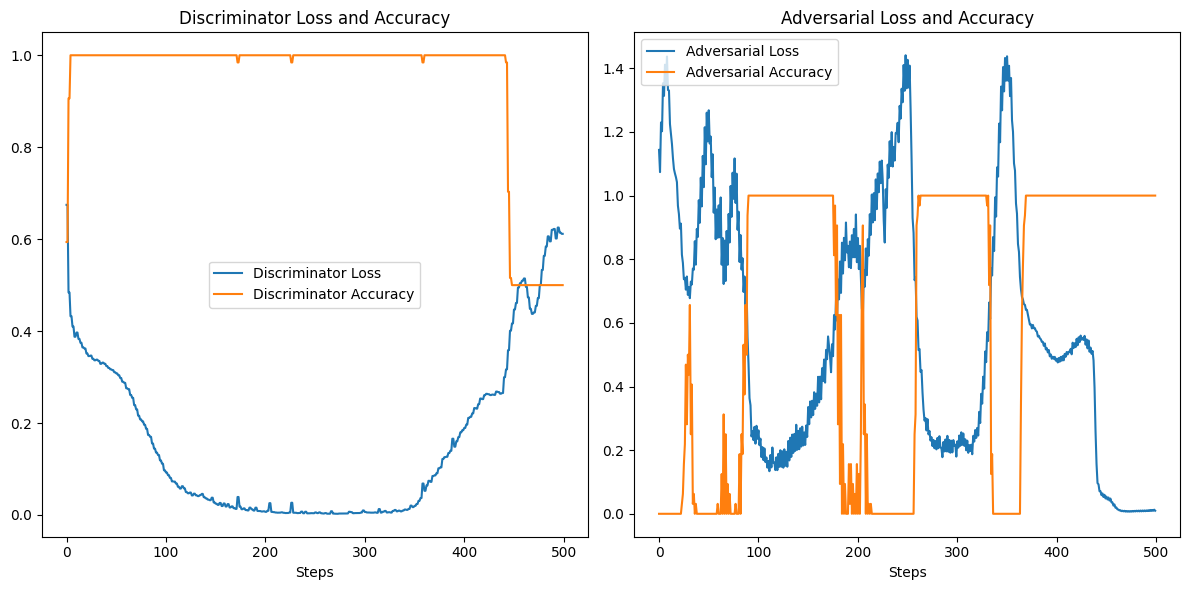

In [106]:

#loss and acc
# Convert the list of numpy arrays into a numpy matrix
history_array = np.array(history)

# Extract discriminator and adversarial loss and accuracy
discriminator_loss = history_array[:, 0]
discriminator_accuracy = history_array[:, 1]
adversarial_loss = history_array[:, 2]
adversarial_accuracy = history_array[:, 3]

# Plotting
plt.figure(figsize=(12, 6))

# Plotting discriminator metrics
plt.subplot(1, 2, 1)
plt.plot(discriminator_loss, label='Discriminator Loss')
plt.plot(discriminator_accuracy, label='Discriminator Accuracy')
plt.title('Discriminator Loss and Accuracy')
plt.xlabel('Steps')
plt.legend()

# Plotting adversarial metrics
plt.subplot(1, 2, 2)
plt.plot(adversarial_loss, label='Adversarial Loss')
plt.plot(adversarial_accuracy, label='Adversarial Accuracy')
plt.title('Adversarial Loss and Accuracy')
plt.xlabel('Steps')
plt.legend()

plt.tight_layout()
plt.show()


In [107]:
history = build_and_train_models(True) #training a few more times, with checkpts

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 64, 256, 4)        40        


                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 64, 256, 4)        0         
                                                                 
 dropout_11 (Dropout)        (None, 64, 256, 4)        0         
                                                                 
 flatten_7 (Flatten)         (None, 65536)             0         
                                                                 
 dense_14 (Dense)            (None, 1)                 65537     
                                                                 
Total params: 65,577
Trainable params: 65,577
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 2048)              206848    
                                                 

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 105ms/step


  0%|          | 1/500 [00:01<13:22,  1.61s/it]

0: [discriminator loss: 0.697570, acc: 0.328125] [adversarial loss: 2.159345, acc: 0.000000]
1/1 [==============================] - 0s 15ms/step


  0%|          | 2/500 [00:01<06:50,  1.21it/s]

0: [discriminator loss: 0.697570, acc: 0.328125] [adversarial loss: 2.159345, acc: 0.000000] [adversarial loss: 1.977412, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


  1%|          | 3/500 [00:02<04:13,  1.96it/s]

2: [discriminator loss: 0.641048, acc: 1.000000] [adversarial loss: 2.513089, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step
2: [discriminator loss: 0.641048, acc: 1.000000] [adversarial loss: 2.513089, acc: 0.000000] [adversarial loss: 2.434872, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


  1%|          | 5/500 [00:02<02:21,  3.49it/s]

4: [discriminator loss: 0.600709, acc: 1.000000] [adversarial loss: 2.876054, acc: 0.000000]
1/1 [==============================] - 0s 15ms/step
4: [discriminator loss: 0.600709, acc: 1.000000] [adversarial loss: 2.876054, acc: 0.000000] [adversarial loss: 2.677722, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


  1%|▏         | 7/500 [00:02<01:43,  4.76it/s]

6: [discriminator loss: 0.566369, acc: 1.000000] [adversarial loss: 2.925733, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step
6: [discriminator loss: 0.566369, acc: 1.000000] [adversarial loss: 2.925733, acc: 0.000000] [adversarial loss: 2.860609, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


  2%|▏         | 9/500 [00:02<01:25,  5.75it/s]

8: [discriminator loss: 0.554224, acc: 1.000000] [adversarial loss: 3.219326, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step
8: [discriminator loss: 0.554224, acc: 1.000000] [adversarial loss: 3.219326, acc: 0.000000] [adversarial loss: 3.009028, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


  2%|▏         | 11/500 [00:02<01:14,  6.53it/s]

10: [discriminator loss: 0.528740, acc: 1.000000] [adversarial loss: 3.206824, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 12/500 [00:03<01:10,  6.93it/s]

10: [discriminator loss: 0.528740, acc: 1.000000] [adversarial loss: 3.206824, acc: 0.000000] [adversarial loss: 3.117637, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 13/500 [00:03<01:09,  6.99it/s]

12: [discriminator loss: 0.491970, acc: 1.000000] [adversarial loss: 3.386060, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


  3%|▎         | 14/500 [00:03<01:04,  7.54it/s]

12: [discriminator loss: 0.491970, acc: 1.000000] [adversarial loss: 3.386060, acc: 0.000000] [adversarial loss: 3.324455, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


  3%|▎         | 15/500 [00:03<01:04,  7.52it/s]

14: [discriminator loss: 0.480268, acc: 1.000000] [adversarial loss: 3.707353, acc: 0.000000]
1/1 [==============================] - 0s 14ms/step
14: [discriminator loss: 0.480268, acc: 1.000000] [adversarial loss: 3.707353, acc: 0.000000] [adversarial loss: 3.502583, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


  3%|▎         | 17/500 [00:03<01:01,  7.84it/s]

16: [discriminator loss: 0.478231, acc: 1.000000] [adversarial loss: 3.910572, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


  4%|▎         | 18/500 [00:03<00:58,  8.18it/s]

16: [discriminator loss: 0.478231, acc: 1.000000] [adversarial loss: 3.910572, acc: 0.000000] [adversarial loss: 3.815281, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


  4%|▍         | 19/500 [00:03<01:01,  7.86it/s]

18: [discriminator loss: 0.447448, acc: 1.000000] [adversarial loss: 4.338584, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


  4%|▍         | 20/500 [00:04<00:57,  8.29it/s]

18: [discriminator loss: 0.447448, acc: 1.000000] [adversarial loss: 4.338584, acc: 0.000000] [adversarial loss: 4.204387, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


  4%|▍         | 21/500 [00:04<01:00,  7.96it/s]

20: [discriminator loss: 0.430860, acc: 1.000000] [adversarial loss: 4.740966, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


  4%|▍         | 22/500 [00:04<00:57,  8.39it/s]

20: [discriminator loss: 0.430860, acc: 1.000000] [adversarial loss: 4.740966, acc: 0.000000] [adversarial loss: 4.518978, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


  5%|▍         | 23/500 [00:04<01:00,  7.90it/s]

22: [discriminator loss: 0.407504, acc: 1.000000] [adversarial loss: 5.076876, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


  5%|▍         | 24/500 [00:04<00:58,  8.19it/s]

22: [discriminator loss: 0.407504, acc: 1.000000] [adversarial loss: 5.076876, acc: 0.000000] [adversarial loss: 4.967159, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


  5%|▌         | 25/500 [00:04<01:01,  7.73it/s]

24: [discriminator loss: 0.386045, acc: 1.000000] [adversarial loss: 5.353580, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


  5%|▌         | 26/500 [00:04<00:58,  8.16it/s]

24: [discriminator loss: 0.386045, acc: 1.000000] [adversarial loss: 5.353580, acc: 0.000000] [adversarial loss: 5.277432, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


  5%|▌         | 27/500 [00:04<01:02,  7.59it/s]

26: [discriminator loss: 0.353968, acc: 1.000000] [adversarial loss: 5.690466, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


  6%|▌         | 28/500 [00:05<00:58,  8.07it/s]

26: [discriminator loss: 0.353968, acc: 1.000000] [adversarial loss: 5.690466, acc: 0.000000] [adversarial loss: 5.538612, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


  6%|▌         | 29/500 [00:05<01:00,  7.77it/s]

28: [discriminator loss: 0.348494, acc: 1.000000] [adversarial loss: 5.803847, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


  6%|▌         | 30/500 [00:05<00:57,  8.22it/s]

28: [discriminator loss: 0.348494, acc: 1.000000] [adversarial loss: 5.803847, acc: 0.000000] [adversarial loss: 5.732398, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


  6%|▌         | 31/500 [00:05<01:00,  7.70it/s]

30: [discriminator loss: 0.322690, acc: 1.000000] [adversarial loss: 6.000114, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


  6%|▋         | 32/500 [00:05<00:57,  8.11it/s]

30: [discriminator loss: 0.322690, acc: 1.000000] [adversarial loss: 6.000114, acc: 0.000000] [adversarial loss: 5.788321, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


  7%|▋         | 33/500 [00:05<01:00,  7.69it/s]

32: [discriminator loss: 0.321586, acc: 1.000000] [adversarial loss: 6.092254, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


  7%|▋         | 34/500 [00:05<00:57,  8.10it/s]

32: [discriminator loss: 0.321586, acc: 1.000000] [adversarial loss: 6.092254, acc: 0.000000] [adversarial loss: 5.942647, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


  7%|▋         | 35/500 [00:05<01:01,  7.59it/s]

34: [discriminator loss: 0.298890, acc: 1.000000] [adversarial loss: 6.120021, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


  7%|▋         | 36/500 [00:06<00:57,  8.12it/s]

34: [discriminator loss: 0.298890, acc: 1.000000] [adversarial loss: 6.120021, acc: 0.000000] [adversarial loss: 6.012713, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


  7%|▋         | 37/500 [00:06<01:00,  7.71it/s]

36: [discriminator loss: 0.290523, acc: 1.000000] [adversarial loss: 6.023126, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


  8%|▊         | 38/500 [00:06<00:56,  8.18it/s]

36: [discriminator loss: 0.290523, acc: 1.000000] [adversarial loss: 6.023126, acc: 0.000000] [adversarial loss: 5.995965, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


  8%|▊         | 39/500 [00:06<01:01,  7.50it/s]

38: [discriminator loss: 0.269467, acc: 1.000000] [adversarial loss: 6.256831, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


  8%|▊         | 40/500 [00:06<01:05,  7.06it/s]

38: [discriminator loss: 0.269467, acc: 1.000000] [adversarial loss: 6.256831, acc: 0.000000] [adversarial loss: 6.107516, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


  8%|▊         | 41/500 [00:06<01:06,  6.85it/s]

40: [discriminator loss: 0.273829, acc: 1.000000] [adversarial loss: 6.213583, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


  8%|▊         | 42/500 [00:06<01:01,  7.42it/s]

40: [discriminator loss: 0.273829, acc: 1.000000] [adversarial loss: 6.213583, acc: 0.000000] [adversarial loss: 6.033154, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


  9%|▊         | 43/500 [00:07<01:04,  7.11it/s]

42: [discriminator loss: 0.253104, acc: 1.000000] [adversarial loss: 6.155605, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


  9%|▉         | 44/500 [00:07<01:00,  7.51it/s]

42: [discriminator loss: 0.253104, acc: 1.000000] [adversarial loss: 6.155605, acc: 0.000000] [adversarial loss: 6.004443, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


  9%|▉         | 45/500 [00:07<01:03,  7.17it/s]

44: [discriminator loss: 0.242308, acc: 1.000000] [adversarial loss: 6.144896, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


  9%|▉         | 46/500 [00:07<00:59,  7.64it/s]

44: [discriminator loss: 0.242308, acc: 1.000000] [adversarial loss: 6.144896, acc: 0.000000] [adversarial loss: 5.974743, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


  9%|▉         | 47/500 [00:07<01:03,  7.13it/s]

46: [discriminator loss: 0.232320, acc: 1.000000] [adversarial loss: 6.074792, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 10%|▉         | 48/500 [00:07<00:59,  7.57it/s]

46: [discriminator loss: 0.232320, acc: 1.000000] [adversarial loss: 6.074792, acc: 0.000000] [adversarial loss: 5.944427, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 10%|▉         | 49/500 [00:07<01:02,  7.18it/s]

48: [discriminator loss: 0.218059, acc: 1.000000] [adversarial loss: 6.115050, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 10%|█         | 50/500 [00:08<01:07,  6.63it/s]

48: [discriminator loss: 0.218059, acc: 1.000000] [adversarial loss: 6.115050, acc: 0.000000] [adversarial loss: 5.886764, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 10%|█         | 51/500 [00:08<01:29,  5.03it/s]

50: [discriminator loss: 0.213004, acc: 1.000000] [adversarial loss: 6.013932, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 10%|█         | 52/500 [00:08<01:22,  5.45it/s]

50: [discriminator loss: 0.213004, acc: 1.000000] [adversarial loss: 6.013932, acc: 0.000000] [adversarial loss: 5.794994, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 11%|█         | 53/500 [00:08<01:57,  3.80it/s]

52: [discriminator loss: 0.197016, acc: 1.000000] [adversarial loss: 5.892725, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 11%|█         | 54/500 [00:09<01:42,  4.37it/s]

52: [discriminator loss: 0.197016, acc: 1.000000] [adversarial loss: 5.892725, acc: 0.000000] [adversarial loss: 5.767595, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 11%|█         | 55/500 [00:09<02:10,  3.40it/s]

54: [discriminator loss: 0.186883, acc: 1.000000] [adversarial loss: 5.855153, acc: 0.000000]
1/1 [==============================] - 0s 15ms/step


 11%|█         | 56/500 [00:09<01:50,  4.02it/s]

54: [discriminator loss: 0.186883, acc: 1.000000] [adversarial loss: 5.855153, acc: 0.000000] [adversarial loss: 5.590646, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 11%|█▏        | 57/500 [00:10<02:17,  3.23it/s]

56: [discriminator loss: 0.186324, acc: 1.000000] [adversarial loss: 5.752005, acc: 0.000000]
1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 58/500 [00:10<01:54,  3.87it/s]

56: [discriminator loss: 0.186324, acc: 1.000000] [adversarial loss: 5.752005, acc: 0.000000] [adversarial loss: 5.635022, acc: 0.000000]
1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 59/500 [00:10<02:20,  3.14it/s]

58: [discriminator loss: 0.180852, acc: 1.000000] [adversarial loss: 5.632246, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 60/500 [00:10<01:56,  3.76it/s]

58: [discriminator loss: 0.180852, acc: 1.000000] [adversarial loss: 5.632246, acc: 0.000000] [adversarial loss: 5.460064, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 61/500 [00:11<02:22,  3.08it/s]

60: [discriminator loss: 0.166799, acc: 1.000000] [adversarial loss: 5.495621, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 62/500 [00:11<01:58,  3.69it/s]

60: [discriminator loss: 0.166799, acc: 1.000000] [adversarial loss: 5.495621, acc: 0.000000] [adversarial loss: 5.338564, acc: 0.000000]
1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 63/500 [00:11<02:22,  3.06it/s]

62: [discriminator loss: 0.165443, acc: 1.000000] [adversarial loss: 5.323575, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 64/500 [00:12<01:59,  3.66it/s]

62: [discriminator loss: 0.165443, acc: 1.000000] [adversarial loss: 5.323575, acc: 0.000000] [adversarial loss: 5.212490, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 65/500 [00:12<02:21,  3.06it/s]

64: [discriminator loss: 0.163191, acc: 1.000000] [adversarial loss: 5.248684, acc: 0.000000]
1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 66/500 [00:12<01:57,  3.69it/s]

64: [discriminator loss: 0.163191, acc: 1.000000] [adversarial loss: 5.248684, acc: 0.000000] [adversarial loss: 5.012765, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 67/500 [00:13<02:21,  3.06it/s]

66: [discriminator loss: 0.156764, acc: 0.984375] [adversarial loss: 5.011137, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 14%|█▎        | 68/500 [00:13<01:57,  3.69it/s]

66: [discriminator loss: 0.156764, acc: 0.984375] [adversarial loss: 5.011137, acc: 0.000000] [adversarial loss: 4.858733, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 69/500 [00:13<02:20,  3.06it/s]

68: [discriminator loss: 0.150589, acc: 1.000000] [adversarial loss: 4.776951, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 70/500 [00:13<01:56,  3.68it/s]

68: [discriminator loss: 0.150589, acc: 1.000000] [adversarial loss: 4.776951, acc: 0.000000] [adversarial loss: 4.702863, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 71/500 [00:14<02:20,  3.05it/s]

70: [discriminator loss: 0.143609, acc: 1.000000] [adversarial loss: 4.575310, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 72/500 [00:14<01:56,  3.68it/s]

70: [discriminator loss: 0.143609, acc: 1.000000] [adversarial loss: 4.575310, acc: 0.000000] [adversarial loss: 4.512552, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 73/500 [00:14<02:19,  3.05it/s]

72: [discriminator loss: 0.156676, acc: 0.984375] [adversarial loss: 4.339159, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 74/500 [00:15<01:56,  3.66it/s]

72: [discriminator loss: 0.156676, acc: 0.984375] [adversarial loss: 4.339159, acc: 0.000000] [adversarial loss: 4.233515, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 75/500 [00:15<02:19,  3.05it/s]

74: [discriminator loss: 0.130247, acc: 1.000000] [adversarial loss: 4.327688, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 76/500 [00:15<01:55,  3.68it/s]

74: [discriminator loss: 0.130247, acc: 1.000000] [adversarial loss: 4.327688, acc: 0.000000] [adversarial loss: 4.189704, acc: 0.000000]
1/1 [==============================] - 0s 15ms/step


 15%|█▌        | 77/500 [00:16<02:18,  3.05it/s]

76: [discriminator loss: 0.123966, acc: 1.000000] [adversarial loss: 4.252831, acc: 0.000000]
1/1 [==============================] - 0s 15ms/step


 16%|█▌        | 78/500 [00:16<01:54,  3.68it/s]

76: [discriminator loss: 0.123966, acc: 1.000000] [adversarial loss: 4.252831, acc: 0.000000] [adversarial loss: 4.196793, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 79/500 [00:16<02:17,  3.05it/s]

78: [discriminator loss: 0.124262, acc: 1.000000] [adversarial loss: 4.305523, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 80/500 [00:16<02:02,  3.42it/s]

78: [discriminator loss: 0.124262, acc: 1.000000] [adversarial loss: 4.305523, acc: 0.000000] [adversarial loss: 4.208875, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 81/500 [00:17<01:58,  3.52it/s]

80: [discriminator loss: 0.130850, acc: 1.000000] [adversarial loss: 3.970694, acc: 0.000000]
1/1 [==============================] - 0s 15ms/step


 16%|█▋        | 82/500 [00:17<01:46,  3.92it/s]

80: [discriminator loss: 0.130850, acc: 1.000000] [adversarial loss: 3.970694, acc: 0.000000] [adversarial loss: 3.783383, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 83/500 [00:17<01:55,  3.62it/s]

82: [discriminator loss: 0.114836, acc: 1.000000] [adversarial loss: 3.928555, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 84/500 [00:17<01:39,  4.19it/s]

82: [discriminator loss: 0.114836, acc: 1.000000] [adversarial loss: 3.928555, acc: 0.000000] [adversarial loss: 3.828030, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 85/500 [00:18<02:06,  3.27it/s]

84: [discriminator loss: 0.150558, acc: 0.984375] [adversarial loss: 3.481144, acc: 0.000000]
1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 86/500 [00:18<01:46,  3.90it/s]

84: [discriminator loss: 0.150558, acc: 0.984375] [adversarial loss: 3.481144, acc: 0.000000] [adversarial loss: 3.387863, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 87/500 [00:18<02:11,  3.15it/s]

86: [discriminator loss: 0.116623, acc: 1.000000] [adversarial loss: 3.467885, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 88/500 [00:19<01:48,  3.79it/s]

86: [discriminator loss: 0.116623, acc: 1.000000] [adversarial loss: 3.467885, acc: 0.000000] [adversarial loss: 3.297257, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 89/500 [00:19<02:12,  3.10it/s]

88: [discriminator loss: 0.123334, acc: 1.000000] [adversarial loss: 3.160759, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 90/500 [00:19<01:49,  3.73it/s]

88: [discriminator loss: 0.123334, acc: 1.000000] [adversarial loss: 3.160759, acc: 0.000000] [adversarial loss: 3.129565, acc: 0.000000]
1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 91/500 [00:20<02:12,  3.08it/s]

90: [discriminator loss: 0.113648, acc: 1.000000] [adversarial loss: 3.156322, acc: 0.000000]
1/1 [==============================] - 0s 14ms/step


 18%|█▊        | 92/500 [00:20<01:50,  3.68it/s]

90: [discriminator loss: 0.113648, acc: 1.000000] [adversarial loss: 3.156322, acc: 0.000000] [adversarial loss: 3.047960, acc: 0.000000]
1/1 [==============================] - 0s 15ms/step


 19%|█▊        | 93/500 [00:20<02:13,  3.06it/s]

92: [discriminator loss: 0.117010, acc: 1.000000] [adversarial loss: 3.047319, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 94/500 [00:20<01:53,  3.57it/s]

92: [discriminator loss: 0.117010, acc: 1.000000] [adversarial loss: 3.047319, acc: 0.000000] [adversarial loss: 2.971893, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 95/500 [00:21<02:12,  3.06it/s]

94: [discriminator loss: 0.102876, acc: 1.000000] [adversarial loss: 3.043423, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 96/500 [00:21<01:50,  3.65it/s]

94: [discriminator loss: 0.102876, acc: 1.000000] [adversarial loss: 3.043423, acc: 0.000000] [adversarial loss: 2.948213, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 97/500 [00:21<02:10,  3.09it/s]

96: [discriminator loss: 0.109583, acc: 1.000000] [adversarial loss: 2.907025, acc: 0.000000]
1/1 [==============================] - 0s 15ms/step


 20%|█▉        | 98/500 [00:22<01:48,  3.72it/s]

96: [discriminator loss: 0.109583, acc: 1.000000] [adversarial loss: 2.907025, acc: 0.000000] [adversarial loss: 2.819892, acc: 0.000000]
1/1 [==============================] - 0s 14ms/step


 20%|█▉        | 99/500 [00:22<02:10,  3.07it/s]

98: [discriminator loss: 0.113313, acc: 0.984375] [adversarial loss: 2.707661, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 20%|██        | 100/500 [00:22<01:48,  3.68it/s]

98: [discriminator loss: 0.113313, acc: 0.984375] [adversarial loss: 2.707661, acc: 0.000000] [adversarial loss: 2.700114, acc: 0.000000]
1/1 [==============================] - 0s 15ms/step


 20%|██        | 101/500 [00:23<02:10,  3.06it/s]

100: [discriminator loss: 0.105213, acc: 1.000000] [adversarial loss: 2.671178, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 20%|██        | 102/500 [00:23<01:48,  3.67it/s]

100: [discriminator loss: 0.105213, acc: 1.000000] [adversarial loss: 2.671178, acc: 0.000000] [adversarial loss: 2.545105, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 21%|██        | 103/500 [00:23<02:09,  3.06it/s]

102: [discriminator loss: 0.128615, acc: 0.984375] [adversarial loss: 2.340356, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 21%|██        | 104/500 [00:23<01:48,  3.66it/s]

102: [discriminator loss: 0.128615, acc: 0.984375] [adversarial loss: 2.340356, acc: 0.000000] [adversarial loss: 2.219295, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 21%|██        | 105/500 [00:24<02:09,  3.06it/s]

104: [discriminator loss: 0.096258, acc: 1.000000] [adversarial loss: 2.381444, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 21%|██        | 106/500 [00:24<01:47,  3.68it/s]

104: [discriminator loss: 0.096258, acc: 1.000000] [adversarial loss: 2.381444, acc: 0.000000] [adversarial loss: 2.306273, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 107/500 [00:24<02:08,  3.05it/s]

106: [discriminator loss: 0.104336, acc: 1.000000] [adversarial loss: 2.331044, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 108/500 [00:25<01:46,  3.67it/s]

106: [discriminator loss: 0.104336, acc: 1.000000] [adversarial loss: 2.331044, acc: 0.000000] [adversarial loss: 2.192848, acc: 0.000000]
1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 109/500 [00:25<02:07,  3.06it/s]

108: [discriminator loss: 0.098568, acc: 1.000000] [adversarial loss: 2.346720, acc: 0.000000]
1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 110/500 [00:25<01:45,  3.69it/s]

108: [discriminator loss: 0.098568, acc: 1.000000] [adversarial loss: 2.346720, acc: 0.000000] [adversarial loss: 2.157071, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 111/500 [00:26<02:07,  3.06it/s]

110: [discriminator loss: 0.094424, acc: 1.000000] [adversarial loss: 2.342886, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 112/500 [00:26<01:45,  3.68it/s]

110: [discriminator loss: 0.094424, acc: 1.000000] [adversarial loss: 2.342886, acc: 0.000000] [adversarial loss: 2.234510, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 113/500 [00:26<02:06,  3.05it/s]

112: [discriminator loss: 0.095805, acc: 1.000000] [adversarial loss: 2.402100, acc: 0.000000]
1/1 [==============================] - 0s 14ms/step


 23%|██▎       | 114/500 [00:26<01:45,  3.66it/s]

112: [discriminator loss: 0.095805, acc: 1.000000] [adversarial loss: 2.402100, acc: 0.000000] [adversarial loss: 2.232077, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 115/500 [00:27<02:06,  3.04it/s]

114: [discriminator loss: 0.096796, acc: 1.000000] [adversarial loss: 2.373377, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 116/500 [00:27<01:47,  3.58it/s]

114: [discriminator loss: 0.096796, acc: 1.000000] [adversarial loss: 2.373377, acc: 0.000000] [adversarial loss: 2.182267, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 117/500 [00:27<02:06,  3.03it/s]

116: [discriminator loss: 0.109461, acc: 0.984375] [adversarial loss: 2.158170, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 118/500 [00:28<01:49,  3.49it/s]

116: [discriminator loss: 0.109461, acc: 0.984375] [adversarial loss: 2.158170, acc: 0.000000] [adversarial loss: 1.997910, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 119/500 [00:28<02:04,  3.07it/s]

118: [discriminator loss: 0.108854, acc: 1.000000] [adversarial loss: 1.980836, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 120/500 [00:28<01:51,  3.40it/s]

118: [discriminator loss: 0.108854, acc: 1.000000] [adversarial loss: 1.980836, acc: 0.000000] [adversarial loss: 1.872854, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 121/500 [00:28<01:43,  3.65it/s]

120: [discriminator loss: 0.100194, acc: 1.000000] [adversarial loss: 1.870341, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 122/500 [00:29<01:45,  3.59it/s]

120: [discriminator loss: 0.100194, acc: 1.000000] [adversarial loss: 1.870341, acc: 0.000000] [adversarial loss: 1.801198, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 123/500 [00:29<01:37,  3.85it/s]

122: [discriminator loss: 0.098053, acc: 1.000000] [adversarial loss: 1.858148, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 124/500 [00:29<01:56,  3.24it/s]

122: [discriminator loss: 0.098053, acc: 1.000000] [adversarial loss: 1.858148, acc: 0.000000] [adversarial loss: 1.701388, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 125/500 [00:30<01:46,  3.52it/s]

124: [discriminator loss: 0.145744, acc: 0.984375] [adversarial loss: 1.414777, acc: 0.000000]
1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 126/500 [00:30<01:34,  3.94it/s]

124: [discriminator loss: 0.145744, acc: 0.984375] [adversarial loss: 1.414777, acc: 0.000000] [adversarial loss: 1.297555, acc: 0.000000]
1/1 [==============================] - 0s 15ms/step


 25%|██▌       | 127/500 [00:30<01:51,  3.33it/s]

126: [discriminator loss: 0.098436, acc: 1.000000] [adversarial loss: 1.353032, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 128/500 [00:30<01:36,  3.84it/s]

126: [discriminator loss: 0.098436, acc: 1.000000] [adversarial loss: 1.353032, acc: 0.000000] [adversarial loss: 1.310918, acc: 0.000000]
1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 129/500 [00:31<01:56,  3.20it/s]

128: [discriminator loss: 0.096465, acc: 1.000000] [adversarial loss: 1.384791, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 130/500 [00:31<01:39,  3.71it/s]

128: [discriminator loss: 0.096465, acc: 1.000000] [adversarial loss: 1.384791, acc: 0.000000] [adversarial loss: 1.244204, acc: 0.000000]
1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 131/500 [00:31<01:57,  3.14it/s]

130: [discriminator loss: 0.106666, acc: 0.984375] [adversarial loss: 1.289218, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 132/500 [00:32<01:42,  3.61it/s]

130: [discriminator loss: 0.106666, acc: 0.984375] [adversarial loss: 1.289218, acc: 0.000000] [adversarial loss: 1.160708, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 133/500 [00:32<01:57,  3.12it/s]

132: [discriminator loss: 0.109698, acc: 0.984375] [adversarial loss: 1.096316, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 134/500 [00:32<01:45,  3.48it/s]

132: [discriminator loss: 0.109698, acc: 0.984375] [adversarial loss: 1.096316, acc: 0.000000] [adversarial loss: 0.993808, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 135/500 [00:33<02:14,  2.71it/s]

134: [discriminator loss: 0.095198, acc: 1.000000] [adversarial loss: 1.032559, acc: 0.031250]
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 136/500 [00:33<01:52,  3.25it/s]

134: [discriminator loss: 0.095198, acc: 1.000000] [adversarial loss: 1.032559, acc: 0.031250] [adversarial loss: 1.030140, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 137/500 [00:33<02:07,  2.84it/s]

136: [discriminator loss: 0.111305, acc: 0.984375] [adversarial loss: 0.939864, acc: 0.031250]
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 138/500 [00:34<01:48,  3.35it/s]

136: [discriminator loss: 0.111305, acc: 0.984375] [adversarial loss: 0.939864, acc: 0.031250] [adversarial loss: 0.815472, acc: 0.187500]
1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 139/500 [00:34<02:02,  2.95it/s]

138: [discriminator loss: 0.091900, acc: 1.000000] [adversarial loss: 0.952454, acc: 0.031250]
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 140/500 [00:34<01:46,  3.39it/s]

138: [discriminator loss: 0.091900, acc: 1.000000] [adversarial loss: 0.952454, acc: 0.031250] [adversarial loss: 0.938396, acc: 0.031250]
1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 141/500 [00:35<01:58,  3.04it/s]

140: [discriminator loss: 0.095194, acc: 1.000000] [adversarial loss: 1.032127, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 142/500 [00:35<01:38,  3.63it/s]

140: [discriminator loss: 0.095194, acc: 1.000000] [adversarial loss: 1.032127, acc: 0.000000] [adversarial loss: 0.998551, acc: 0.062500]
1/1 [==============================] - 0s 15ms/step


 29%|██▊       | 143/500 [00:35<01:54,  3.11it/s]

142: [discriminator loss: 0.089899, acc: 1.000000] [adversarial loss: 1.130234, acc: 0.000000]
1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 144/500 [00:35<01:38,  3.60it/s]

142: [discriminator loss: 0.089899, acc: 1.000000] [adversarial loss: 1.130234, acc: 0.000000] [adversarial loss: 1.015722, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 145/500 [00:36<01:55,  3.06it/s]

144: [discriminator loss: 0.104830, acc: 0.984375] [adversarial loss: 1.009360, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 146/500 [00:36<01:38,  3.60it/s]

144: [discriminator loss: 0.104830, acc: 0.984375] [adversarial loss: 1.009360, acc: 0.000000] [adversarial loss: 0.988208, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 147/500 [00:36<01:54,  3.09it/s]

146: [discriminator loss: 0.098317, acc: 1.000000] [adversarial loss: 1.073110, acc: 0.000000]
1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 148/500 [00:37<01:37,  3.60it/s]

146: [discriminator loss: 0.098317, acc: 1.000000] [adversarial loss: 1.073110, acc: 0.000000] [adversarial loss: 0.973839, acc: 0.000000]
1/1 [==============================] - 0s 15ms/step


 30%|██▉       | 149/500 [00:37<01:53,  3.10it/s]

148: [discriminator loss: 0.095506, acc: 1.000000] [adversarial loss: 1.069582, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 30%|███       | 150/500 [00:37<01:33,  3.73it/s]

148: [discriminator loss: 0.095506, acc: 1.000000] [adversarial loss: 1.069582, acc: 0.000000] [adversarial loss: 0.994939, acc: 0.031250]
1/1 [==============================] - 0s 15ms/step


 30%|███       | 151/500 [00:38<01:52,  3.10it/s]

150: [discriminator loss: 0.091594, acc: 1.000000] [adversarial loss: 1.121295, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 30%|███       | 152/500 [00:38<01:32,  3.74it/s]

150: [discriminator loss: 0.091594, acc: 1.000000] [adversarial loss: 1.121295, acc: 0.000000] [adversarial loss: 1.032048, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 31%|███       | 153/500 [00:38<01:52,  3.08it/s]

152: [discriminator loss: 0.093302, acc: 1.000000] [adversarial loss: 1.108245, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 31%|███       | 154/500 [00:38<01:33,  3.70it/s]

152: [discriminator loss: 0.093302, acc: 1.000000] [adversarial loss: 1.108245, acc: 0.000000] [adversarial loss: 1.102840, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 31%|███       | 155/500 [00:39<01:52,  3.06it/s]

154: [discriminator loss: 0.104957, acc: 0.984375] [adversarial loss: 1.106583, acc: 0.031250]
1/1 [==============================] - 0s 17ms/step


 31%|███       | 156/500 [00:39<01:33,  3.68it/s]

154: [discriminator loss: 0.104957, acc: 0.984375] [adversarial loss: 1.106583, acc: 0.031250] [adversarial loss: 0.998449, acc: 0.031250]
1/1 [==============================] - 0s 17ms/step


 31%|███▏      | 157/500 [00:39<01:52,  3.05it/s]

156: [discriminator loss: 0.091717, acc: 1.000000] [adversarial loss: 1.172059, acc: 0.031250]
1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 158/500 [00:40<01:33,  3.67it/s]

156: [discriminator loss: 0.091717, acc: 1.000000] [adversarial loss: 1.172059, acc: 0.031250] [adversarial loss: 1.104922, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 159/500 [00:40<01:51,  3.05it/s]

158: [discriminator loss: 0.095371, acc: 1.000000] [adversarial loss: 1.122280, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 160/500 [00:40<01:37,  3.47it/s]

158: [discriminator loss: 0.095371, acc: 1.000000] [adversarial loss: 1.122280, acc: 0.000000] [adversarial loss: 1.081401, acc: 0.031250]
1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 161/500 [00:40<01:31,  3.71it/s]

160: [discriminator loss: 0.097411, acc: 1.000000] [adversarial loss: 1.198770, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 162/500 [00:41<01:41,  3.32it/s]

160: [discriminator loss: 0.097411, acc: 1.000000] [adversarial loss: 1.198770, acc: 0.000000] [adversarial loss: 1.127466, acc: 0.000000]
1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 163/500 [00:41<01:30,  3.73it/s]

162: [discriminator loss: 0.098723, acc: 0.984375] [adversarial loss: 1.201069, acc: 0.031250]
1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 164/500 [00:41<01:42,  3.26it/s]

162: [discriminator loss: 0.098723, acc: 0.984375] [adversarial loss: 1.201069, acc: 0.031250] [adversarial loss: 1.127636, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 165/500 [00:42<01:30,  3.71it/s]

164: [discriminator loss: 0.086934, acc: 1.000000] [adversarial loss: 1.241151, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 166/500 [00:42<01:42,  3.25it/s]

164: [discriminator loss: 0.086934, acc: 1.000000] [adversarial loss: 1.241151, acc: 0.000000] [adversarial loss: 1.192990, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 167/500 [00:42<01:30,  3.67it/s]

166: [discriminator loss: 0.097620, acc: 1.000000] [adversarial loss: 1.191037, acc: 0.000000]
1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 168/500 [00:43<01:44,  3.19it/s]

166: [discriminator loss: 0.097620, acc: 1.000000] [adversarial loss: 1.191037, acc: 0.000000] [adversarial loss: 1.149827, acc: 0.000000]
1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 169/500 [00:43<01:31,  3.63it/s]

168: [discriminator loss: 0.088468, acc: 1.000000] [adversarial loss: 1.257788, acc: 0.000000]
1/1 [==============================] - 0s 15ms/step


 34%|███▍      | 170/500 [00:43<01:29,  3.71it/s]

168: [discriminator loss: 0.088468, acc: 1.000000] [adversarial loss: 1.257788, acc: 0.000000] [adversarial loss: 1.254987, acc: 0.000000]
1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 171/500 [00:43<01:24,  3.89it/s]

170: [discriminator loss: 0.091676, acc: 1.000000] [adversarial loss: 1.258552, acc: 0.000000]
1/1 [==============================] - 0s 15ms/step


 34%|███▍      | 172/500 [00:44<01:34,  3.46it/s]

170: [discriminator loss: 0.091676, acc: 1.000000] [adversarial loss: 1.258552, acc: 0.000000] [adversarial loss: 1.180419, acc: 0.000000]
1/1 [==============================] - 0s 15ms/step


 35%|███▍      | 173/500 [00:44<01:25,  3.81it/s]

172: [discriminator loss: 0.082898, acc: 1.000000] [adversarial loss: 1.161811, acc: 0.031250]
1/1 [==============================] - 0s 15ms/step


 35%|███▍      | 174/500 [00:44<01:37,  3.33it/s]

172: [discriminator loss: 0.082898, acc: 1.000000] [adversarial loss: 1.161811, acc: 0.031250] [adversarial loss: 1.042141, acc: 0.000000]
1/1 [==============================] - 0s 15ms/step


 35%|███▌      | 175/500 [00:44<01:26,  3.74it/s]

174: [discriminator loss: 0.081876, acc: 1.000000] [adversarial loss: 0.905813, acc: 0.093750]
1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 176/500 [00:45<01:39,  3.25it/s]

174: [discriminator loss: 0.081876, acc: 1.000000] [adversarial loss: 0.905813, acc: 0.093750] [adversarial loss: 0.705654, acc: 0.437500]
1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 177/500 [00:45<01:27,  3.68it/s]

176: [discriminator loss: 0.081553, acc: 1.000000] [adversarial loss: 0.644992, acc: 0.593750]
1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 178/500 [00:45<01:38,  3.27it/s]

176: [discriminator loss: 0.081553, acc: 1.000000] [adversarial loss: 0.644992, acc: 0.593750] [adversarial loss: 0.524382, acc: 0.937500]
1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 179/500 [00:46<01:26,  3.70it/s]

178: [discriminator loss: 0.075423, acc: 1.000000] [adversarial loss: 0.539611, acc: 0.937500]
1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 180/500 [00:46<01:25,  3.72it/s]

178: [discriminator loss: 0.075423, acc: 1.000000] [adversarial loss: 0.539611, acc: 0.937500] [adversarial loss: 0.476673, acc: 0.968750]
1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 181/500 [00:46<01:21,  3.93it/s]

180: [discriminator loss: 0.072934, acc: 1.000000] [adversarial loss: 0.489620, acc: 0.968750]
1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 182/500 [00:46<01:32,  3.44it/s]

180: [discriminator loss: 0.072934, acc: 1.000000] [adversarial loss: 0.489620, acc: 0.968750] [adversarial loss: 0.440920, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 183/500 [00:47<01:26,  3.65it/s]

182: [discriminator loss: 0.075704, acc: 1.000000] [adversarial loss: 0.435902, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 184/500 [00:47<01:35,  3.31it/s]

182: [discriminator loss: 0.075704, acc: 1.000000] [adversarial loss: 0.435902, acc: 1.000000] [adversarial loss: 0.404505, acc: 1.000000]
1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 185/500 [00:47<01:36,  3.27it/s]

184: [discriminator loss: 0.136849, acc: 0.984375] [adversarial loss: 0.291357, acc: 1.000000]
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 186/500 [00:48<01:35,  3.27it/s]

184: [discriminator loss: 0.136849, acc: 0.984375] [adversarial loss: 0.291357, acc: 1.000000] [adversarial loss: 0.269182, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 187/500 [00:48<01:31,  3.41it/s]

186: [discriminator loss: 0.078449, acc: 1.000000] [adversarial loss: 0.313084, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 38%|███▊      | 188/500 [00:48<01:19,  3.91it/s]

186: [discriminator loss: 0.078449, acc: 1.000000] [adversarial loss: 0.313084, acc: 1.000000] [adversarial loss: 0.266075, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 189/500 [00:48<01:25,  3.65it/s]

188: [discriminator loss: 0.076754, acc: 1.000000] [adversarial loss: 0.359666, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 190/500 [00:49<01:13,  4.24it/s]

188: [discriminator loss: 0.076754, acc: 1.000000] [adversarial loss: 0.359666, acc: 1.000000] [adversarial loss: 0.302719, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 191/500 [00:49<01:18,  3.94it/s]

190: [discriminator loss: 0.103121, acc: 0.984375] [adversarial loss: 0.265350, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 192/500 [00:49<01:07,  4.53it/s]

190: [discriminator loss: 0.103121, acc: 0.984375] [adversarial loss: 0.265350, acc: 1.000000] [adversarial loss: 0.224914, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 39%|███▊      | 193/500 [00:49<01:27,  3.50it/s]

192: [discriminator loss: 0.095380, acc: 0.984375] [adversarial loss: 0.243177, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 39%|███▉      | 194/500 [00:50<01:14,  4.11it/s]

192: [discriminator loss: 0.095380, acc: 0.984375] [adversarial loss: 0.243177, acc: 1.000000] [adversarial loss: 0.220299, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 195/500 [00:50<01:33,  3.25it/s]

194: [discriminator loss: 0.084148, acc: 1.000000] [adversarial loss: 0.272218, acc: 1.000000]
1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 196/500 [00:50<01:20,  3.76it/s]

194: [discriminator loss: 0.084148, acc: 1.000000] [adversarial loss: 0.272218, acc: 1.000000] [adversarial loss: 0.252470, acc: 1.000000]
1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 197/500 [00:51<01:36,  3.14it/s]

196: [discriminator loss: 0.082034, acc: 1.000000] [adversarial loss: 0.286174, acc: 1.000000]
1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 198/500 [00:51<01:22,  3.67it/s]

196: [discriminator loss: 0.082034, acc: 1.000000] [adversarial loss: 0.286174, acc: 1.000000] [adversarial loss: 0.275237, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 199/500 [00:51<01:36,  3.13it/s]

198: [discriminator loss: 0.081451, acc: 1.000000] [adversarial loss: 0.322894, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 40%|████      | 200/500 [00:51<01:29,  3.37it/s]

198: [discriminator loss: 0.081451, acc: 1.000000] [adversarial loss: 0.322894, acc: 1.000000] [adversarial loss: 0.300052, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 40%|████      | 201/500 [00:52<01:24,  3.53it/s]

200: [discriminator loss: 0.080438, acc: 1.000000] [adversarial loss: 0.383518, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 40%|████      | 202/500 [00:52<01:22,  3.63it/s]

200: [discriminator loss: 0.080438, acc: 1.000000] [adversarial loss: 0.383518, acc: 1.000000] [adversarial loss: 0.331548, acc: 1.000000]
1/1 [==============================] - 0s 19ms/step


 41%|████      | 203/500 [00:52<01:18,  3.80it/s]

202: [discriminator loss: 0.080427, acc: 1.000000] [adversarial loss: 0.405806, acc: 0.968750]
1/1 [==============================] - 0s 20ms/step


 41%|████      | 204/500 [00:52<01:10,  4.22it/s]

202: [discriminator loss: 0.080427, acc: 1.000000] [adversarial loss: 0.405806, acc: 0.968750] [adversarial loss: 0.322456, acc: 1.000000]
1/1 [==============================] - 0s 24ms/step


 41%|████      | 205/500 [00:53<01:27,  3.35it/s]

204: [discriminator loss: 0.082149, acc: 1.000000] [adversarial loss: 0.401216, acc: 1.000000]
1/1 [==============================] - 0s 19ms/step


 41%|████      | 206/500 [00:53<01:16,  3.86it/s]

204: [discriminator loss: 0.082149, acc: 1.000000] [adversarial loss: 0.401216, acc: 1.000000] [adversarial loss: 0.335450, acc: 1.000000]
1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 207/500 [00:53<01:31,  3.21it/s]

206: [discriminator loss: 0.081955, acc: 1.000000] [adversarial loss: 0.413594, acc: 1.000000]
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 208/500 [00:54<01:20,  3.62it/s]

206: [discriminator loss: 0.081955, acc: 1.000000] [adversarial loss: 0.413594, acc: 1.000000] [adversarial loss: 0.370134, acc: 1.000000]
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 209/500 [00:54<01:32,  3.16it/s]

208: [discriminator loss: 0.084610, acc: 1.000000] [adversarial loss: 0.419174, acc: 1.000000]
1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 210/500 [00:54<01:17,  3.75it/s]

208: [discriminator loss: 0.084610, acc: 1.000000] [adversarial loss: 0.419174, acc: 1.000000] [adversarial loss: 0.373851, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 211/500 [00:55<01:31,  3.16it/s]

210: [discriminator loss: 0.082145, acc: 1.000000] [adversarial loss: 0.420167, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 212/500 [00:55<01:15,  3.79it/s]

210: [discriminator loss: 0.082145, acc: 1.000000] [adversarial loss: 0.420167, acc: 1.000000] [adversarial loss: 0.357785, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 213/500 [00:55<01:32,  3.12it/s]

212: [discriminator loss: 0.082360, acc: 1.000000] [adversarial loss: 0.408711, acc: 1.000000]
1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 214/500 [00:55<01:17,  3.69it/s]

212: [discriminator loss: 0.082360, acc: 1.000000] [adversarial loss: 0.408711, acc: 1.000000] [adversarial loss: 0.388919, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 215/500 [00:56<01:32,  3.08it/s]

214: [discriminator loss: 0.082303, acc: 1.000000] [adversarial loss: 0.418017, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 216/500 [00:56<01:16,  3.71it/s]

214: [discriminator loss: 0.082303, acc: 1.000000] [adversarial loss: 0.418017, acc: 1.000000] [adversarial loss: 0.361256, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 217/500 [00:56<01:32,  3.05it/s]

216: [discriminator loss: 0.085758, acc: 1.000000] [adversarial loss: 0.360657, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 218/500 [00:57<01:16,  3.67it/s]

216: [discriminator loss: 0.085758, acc: 1.000000] [adversarial loss: 0.360657, acc: 1.000000] [adversarial loss: 0.318480, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 44%|████▍     | 219/500 [00:57<01:31,  3.06it/s]

218: [discriminator loss: 0.098085, acc: 1.000000] [adversarial loss: 0.310750, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 220/500 [00:57<01:15,  3.69it/s]

218: [discriminator loss: 0.098085, acc: 1.000000] [adversarial loss: 0.310750, acc: 1.000000] [adversarial loss: 0.254543, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 221/500 [00:58<01:31,  3.05it/s]

220: [discriminator loss: 0.082465, acc: 1.000000] [adversarial loss: 0.318990, acc: 1.000000]
1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 222/500 [00:58<01:16,  3.63it/s]

220: [discriminator loss: 0.082465, acc: 1.000000] [adversarial loss: 0.318990, acc: 1.000000] [adversarial loss: 0.266226, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 45%|████▍     | 223/500 [00:58<01:31,  3.04it/s]

222: [discriminator loss: 0.078651, acc: 1.000000] [adversarial loss: 0.336889, acc: 1.000000]
1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 224/500 [00:58<01:18,  3.52it/s]

222: [discriminator loss: 0.078651, acc: 1.000000] [adversarial loss: 0.336889, acc: 1.000000] [adversarial loss: 0.308789, acc: 1.000000]
1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 225/500 [00:59<01:29,  3.06it/s]

224: [discriminator loss: 0.078917, acc: 1.000000] [adversarial loss: 0.338236, acc: 0.968750]
1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 226/500 [00:59<01:16,  3.59it/s]

224: [discriminator loss: 0.078917, acc: 1.000000] [adversarial loss: 0.338236, acc: 0.968750] [adversarial loss: 0.304974, acc: 1.000000]
1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 227/500 [00:59<01:28,  3.08it/s]

226: [discriminator loss: 0.140066, acc: 0.984375] [adversarial loss: 0.287037, acc: 1.000000]
1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 228/500 [01:00<01:17,  3.51it/s]

226: [discriminator loss: 0.140066, acc: 0.984375] [adversarial loss: 0.287037, acc: 1.000000] [adversarial loss: 0.242788, acc: 1.000000]
1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 229/500 [01:00<01:27,  3.09it/s]

228: [discriminator loss: 0.077804, acc: 1.000000] [adversarial loss: 0.302093, acc: 1.000000]
1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 230/500 [01:00<01:14,  3.62it/s]

228: [discriminator loss: 0.077804, acc: 1.000000] [adversarial loss: 0.302093, acc: 1.000000] [adversarial loss: 0.276014, acc: 1.000000]
1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 231/500 [01:01<01:26,  3.10it/s]

230: [discriminator loss: 0.075951, acc: 1.000000] [adversarial loss: 0.314010, acc: 1.000000]
1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 232/500 [01:01<01:13,  3.65it/s]

230: [discriminator loss: 0.075951, acc: 1.000000] [adversarial loss: 0.314010, acc: 1.000000] [adversarial loss: 0.285225, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 233/500 [01:01<01:26,  3.10it/s]

232: [discriminator loss: 0.078902, acc: 1.000000] [adversarial loss: 0.295862, acc: 1.000000]
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 234/500 [01:01<01:14,  3.55it/s]

232: [discriminator loss: 0.078902, acc: 1.000000] [adversarial loss: 0.295862, acc: 1.000000] [adversarial loss: 0.255493, acc: 1.000000]
1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 235/500 [01:02<01:25,  3.09it/s]

234: [discriminator loss: 0.072147, acc: 1.000000] [adversarial loss: 0.305010, acc: 1.000000]
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 236/500 [01:02<01:14,  3.53it/s]

234: [discriminator loss: 0.072147, acc: 1.000000] [adversarial loss: 0.305010, acc: 1.000000] [adversarial loss: 0.247109, acc: 1.000000]
1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 237/500 [01:02<01:24,  3.10it/s]

236: [discriminator loss: 0.071754, acc: 1.000000] [adversarial loss: 0.278883, acc: 1.000000]
1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 238/500 [01:03<01:14,  3.52it/s]

236: [discriminator loss: 0.071754, acc: 1.000000] [adversarial loss: 0.278883, acc: 1.000000] [adversarial loss: 0.270679, acc: 1.000000]
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 239/500 [01:03<01:36,  2.70it/s]

238: [discriminator loss: 0.074405, acc: 1.000000] [adversarial loss: 0.301958, acc: 1.000000]
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 240/500 [01:03<01:25,  3.03it/s]

238: [discriminator loss: 0.074405, acc: 1.000000] [adversarial loss: 0.301958, acc: 1.000000] [adversarial loss: 0.244380, acc: 1.000000]
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 241/500 [01:04<01:27,  2.95it/s]

240: [discriminator loss: 0.068024, acc: 1.000000] [adversarial loss: 0.262958, acc: 1.000000]
1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 242/500 [01:04<01:13,  3.50it/s]

240: [discriminator loss: 0.068024, acc: 1.000000] [adversarial loss: 0.262958, acc: 1.000000] [adversarial loss: 0.264150, acc: 1.000000]
1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 243/500 [01:04<01:27,  2.94it/s]

242: [discriminator loss: 0.066288, acc: 1.000000] [adversarial loss: 0.252720, acc: 1.000000]
1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 244/500 [01:05<01:18,  3.27it/s]

242: [discriminator loss: 0.066288, acc: 1.000000] [adversarial loss: 0.252720, acc: 1.000000] [adversarial loss: 0.241108, acc: 1.000000]
1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 245/500 [01:05<01:36,  2.63it/s]

244: [discriminator loss: 0.067396, acc: 1.000000] [adversarial loss: 0.285164, acc: 1.000000]
1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 246/500 [01:05<01:20,  3.16it/s]

244: [discriminator loss: 0.067396, acc: 1.000000] [adversarial loss: 0.285164, acc: 1.000000] [adversarial loss: 0.231158, acc: 1.000000]
1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 247/500 [01:06<01:30,  2.80it/s]

246: [discriminator loss: 0.064650, acc: 1.000000] [adversarial loss: 0.260472, acc: 1.000000]
1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 248/500 [01:06<01:15,  3.34it/s]

246: [discriminator loss: 0.064650, acc: 1.000000] [adversarial loss: 0.260472, acc: 1.000000] [adversarial loss: 0.203921, acc: 1.000000]
1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 249/500 [01:06<01:25,  2.94it/s]

248: [discriminator loss: 0.064270, acc: 1.000000] [adversarial loss: 0.235865, acc: 1.000000]
1/1 [==============================] - 0s 24ms/step


 50%|█████     | 250/500 [01:07<01:13,  3.38it/s]

248: [discriminator loss: 0.064270, acc: 1.000000] [adversarial loss: 0.235865, acc: 1.000000] [adversarial loss: 0.190479, acc: 1.000000]
1/1 [==============================] - 0s 23ms/step


 50%|█████     | 251/500 [01:07<01:22,  3.01it/s]

250: [discriminator loss: 0.060906, acc: 1.000000] [adversarial loss: 0.236214, acc: 1.000000]
1/1 [==============================] - 0s 22ms/step


 50%|█████     | 252/500 [01:07<01:09,  3.59it/s]

250: [discriminator loss: 0.060906, acc: 1.000000] [adversarial loss: 0.236214, acc: 1.000000] [adversarial loss: 0.184081, acc: 1.000000]
1/1 [==============================] - 0s 14ms/step


 51%|█████     | 253/500 [01:08<01:20,  3.08it/s]

252: [discriminator loss: 0.074793, acc: 0.984375] [adversarial loss: 0.195999, acc: 1.000000]
1/1 [==============================] - 0s 19ms/step


 51%|█████     | 254/500 [01:08<01:07,  3.62it/s]

252: [discriminator loss: 0.074793, acc: 0.984375] [adversarial loss: 0.195999, acc: 1.000000] [adversarial loss: 0.160915, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 51%|█████     | 255/500 [01:08<01:19,  3.10it/s]

254: [discriminator loss: 0.058695, acc: 1.000000] [adversarial loss: 0.199289, acc: 1.000000]
1/1 [==============================] - 0s 19ms/step


 51%|█████     | 256/500 [01:08<01:07,  3.62it/s]

254: [discriminator loss: 0.058695, acc: 1.000000] [adversarial loss: 0.199289, acc: 1.000000] [adversarial loss: 0.155387, acc: 1.000000]
1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 257/500 [01:09<01:19,  3.07it/s]

256: [discriminator loss: 0.059669, acc: 1.000000] [adversarial loss: 0.192374, acc: 1.000000]
1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 258/500 [01:09<01:06,  3.62it/s]

256: [discriminator loss: 0.059669, acc: 1.000000] [adversarial loss: 0.192374, acc: 1.000000] [adversarial loss: 0.160698, acc: 1.000000]
1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 259/500 [01:09<01:18,  3.07it/s]

258: [discriminator loss: 0.081836, acc: 0.984375] [adversarial loss: 0.146756, acc: 1.000000]
1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 260/500 [01:10<01:08,  3.52it/s]

258: [discriminator loss: 0.081836, acc: 0.984375] [adversarial loss: 0.146756, acc: 1.000000] [adversarial loss: 0.135048, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 261/500 [01:10<01:17,  3.10it/s]

260: [discriminator loss: 0.056681, acc: 1.000000] [adversarial loss: 0.159906, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 262/500 [01:10<01:04,  3.72it/s]

260: [discriminator loss: 0.056681, acc: 1.000000] [adversarial loss: 0.159906, acc: 1.000000] [adversarial loss: 0.135677, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 263/500 [01:11<01:15,  3.12it/s]

262: [discriminator loss: 0.054908, acc: 1.000000] [adversarial loss: 0.168135, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 264/500 [01:11<01:03,  3.73it/s]

262: [discriminator loss: 0.054908, acc: 1.000000] [adversarial loss: 0.168135, acc: 1.000000] [adversarial loss: 0.148218, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 265/500 [01:11<01:16,  3.09it/s]

264: [discriminator loss: 0.052393, acc: 1.000000] [adversarial loss: 0.172259, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 266/500 [01:11<01:03,  3.70it/s]

264: [discriminator loss: 0.052393, acc: 1.000000] [adversarial loss: 0.172259, acc: 1.000000] [adversarial loss: 0.127046, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 267/500 [01:12<01:15,  3.07it/s]

266: [discriminator loss: 0.057589, acc: 1.000000] [adversarial loss: 0.171710, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 268/500 [01:12<01:02,  3.69it/s]

266: [discriminator loss: 0.057589, acc: 1.000000] [adversarial loss: 0.171710, acc: 1.000000] [adversarial loss: 0.147504, acc: 1.000000]
1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 269/500 [01:12<01:15,  3.06it/s]

268: [discriminator loss: 0.055715, acc: 1.000000] [adversarial loss: 0.157653, acc: 1.000000]
1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 270/500 [01:13<01:02,  3.68it/s]

268: [discriminator loss: 0.055715, acc: 1.000000] [adversarial loss: 0.157653, acc: 1.000000] [adversarial loss: 0.161378, acc: 1.000000]
1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 271/500 [01:13<01:14,  3.05it/s]

270: [discriminator loss: 0.053251, acc: 1.000000] [adversarial loss: 0.167554, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 272/500 [01:13<01:01,  3.69it/s]

270: [discriminator loss: 0.053251, acc: 1.000000] [adversarial loss: 0.167554, acc: 1.000000] [adversarial loss: 0.135386, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 273/500 [01:14<01:14,  3.06it/s]

272: [discriminator loss: 0.052260, acc: 1.000000] [adversarial loss: 0.185214, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 274/500 [01:14<01:01,  3.67it/s]

272: [discriminator loss: 0.052260, acc: 1.000000] [adversarial loss: 0.185214, acc: 1.000000] [adversarial loss: 0.150056, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 275/500 [01:14<01:13,  3.06it/s]

274: [discriminator loss: 0.052162, acc: 1.000000] [adversarial loss: 0.168870, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 276/500 [01:14<01:00,  3.69it/s]

274: [discriminator loss: 0.052162, acc: 1.000000] [adversarial loss: 0.168870, acc: 1.000000] [adversarial loss: 0.147417, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 277/500 [01:15<01:13,  3.05it/s]

276: [discriminator loss: 0.052984, acc: 1.000000] [adversarial loss: 0.150797, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 278/500 [01:15<01:00,  3.68it/s]

276: [discriminator loss: 0.052984, acc: 1.000000] [adversarial loss: 0.150797, acc: 1.000000] [adversarial loss: 0.148640, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 279/500 [01:15<01:12,  3.04it/s]

278: [discriminator loss: 0.055832, acc: 1.000000] [adversarial loss: 0.158534, acc: 1.000000]
1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 280/500 [01:16<01:04,  3.44it/s]

278: [discriminator loss: 0.055832, acc: 1.000000] [adversarial loss: 0.158534, acc: 1.000000] [adversarial loss: 0.137363, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 56%|█████▌    | 281/500 [01:16<00:58,  3.72it/s]

280: [discriminator loss: 0.056731, acc: 1.000000] [adversarial loss: 0.169885, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 56%|█████▋    | 282/500 [01:16<01:05,  3.32it/s]

280: [discriminator loss: 0.056731, acc: 1.000000] [adversarial loss: 0.169885, acc: 1.000000] [adversarial loss: 0.141204, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 283/500 [01:16<00:58,  3.68it/s]

282: [discriminator loss: 0.053241, acc: 1.000000] [adversarial loss: 0.167853, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 284/500 [01:17<01:06,  3.26it/s]

282: [discriminator loss: 0.053241, acc: 1.000000] [adversarial loss: 0.167853, acc: 1.000000] [adversarial loss: 0.164232, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 285/500 [01:17<00:58,  3.70it/s]

284: [discriminator loss: 0.055738, acc: 1.000000] [adversarial loss: 0.190190, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 286/500 [01:17<01:05,  3.27it/s]

284: [discriminator loss: 0.055738, acc: 1.000000] [adversarial loss: 0.190190, acc: 1.000000] [adversarial loss: 0.151173, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 287/500 [01:18<00:57,  3.69it/s]

286: [discriminator loss: 0.070096, acc: 0.984375] [adversarial loss: 0.170493, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 288/500 [01:18<01:06,  3.20it/s]

286: [discriminator loss: 0.070096, acc: 0.984375] [adversarial loss: 0.170493, acc: 1.000000] [adversarial loss: 0.154772, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 289/500 [01:18<00:57,  3.65it/s]

288: [discriminator loss: 0.055046, acc: 1.000000] [adversarial loss: 0.184004, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 290/500 [01:18<00:56,  3.69it/s]

288: [discriminator loss: 0.055046, acc: 1.000000] [adversarial loss: 0.184004, acc: 1.000000] [adversarial loss: 0.156725, acc: 1.000000]
1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 291/500 [01:19<00:56,  3.69it/s]

290: [discriminator loss: 0.068480, acc: 0.984375] [adversarial loss: 0.164798, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 292/500 [01:19<00:50,  4.11it/s]

290: [discriminator loss: 0.068480, acc: 0.984375] [adversarial loss: 0.164798, acc: 1.000000] [adversarial loss: 0.159839, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 59%|█████▊    | 293/500 [01:19<00:53,  3.86it/s]

292: [discriminator loss: 0.056723, acc: 1.000000] [adversarial loss: 0.180022, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 59%|█████▉    | 294/500 [01:19<00:46,  4.43it/s]

292: [discriminator loss: 0.056723, acc: 1.000000] [adversarial loss: 0.180022, acc: 1.000000] [adversarial loss: 0.172959, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 295/500 [01:20<00:50,  4.04it/s]

294: [discriminator loss: 0.060406, acc: 1.000000] [adversarial loss: 0.221067, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 296/500 [01:20<00:44,  4.62it/s]

294: [discriminator loss: 0.060406, acc: 1.000000] [adversarial loss: 0.221067, acc: 1.000000] [adversarial loss: 0.174027, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 59%|█████▉    | 297/500 [01:20<00:58,  3.49it/s]

296: [discriminator loss: 0.063623, acc: 1.000000] [adversarial loss: 0.219165, acc: 1.000000]
1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 298/500 [01:20<00:50,  3.99it/s]

296: [discriminator loss: 0.063623, acc: 1.000000] [adversarial loss: 0.219165, acc: 1.000000] [adversarial loss: 0.185905, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 60%|█████▉    | 299/500 [01:21<01:02,  3.22it/s]

298: [discriminator loss: 0.062590, acc: 1.000000] [adversarial loss: 0.230746, acc: 1.000000]
1/1 [==============================] - 0s 22ms/step


 60%|██████    | 300/500 [01:21<00:53,  3.71it/s]

298: [discriminator loss: 0.062590, acc: 1.000000] [adversarial loss: 0.230746, acc: 1.000000] [adversarial loss: 0.203284, acc: 1.000000]
1/1 [==============================] - 0s 22ms/step


 60%|██████    | 301/500 [01:21<01:03,  3.14it/s]

300: [discriminator loss: 0.066350, acc: 1.000000] [adversarial loss: 0.249385, acc: 1.000000]
1/1 [==============================] - 0s 22ms/step


 60%|██████    | 302/500 [01:22<00:55,  3.55it/s]

300: [discriminator loss: 0.066350, acc: 1.000000] [adversarial loss: 0.249385, acc: 1.000000] [adversarial loss: 0.202271, acc: 1.000000]
1/1 [==============================] - 0s 19ms/step


 61%|██████    | 303/500 [01:22<01:03,  3.12it/s]

302: [discriminator loss: 0.067801, acc: 1.000000] [adversarial loss: 0.245340, acc: 1.000000]
1/1 [==============================] - 0s 19ms/step


 61%|██████    | 304/500 [01:22<00:57,  3.43it/s]

302: [discriminator loss: 0.067801, acc: 1.000000] [adversarial loss: 0.245340, acc: 1.000000] [adversarial loss: 0.230302, acc: 1.000000]
1/1 [==============================] - 0s 20ms/step


 61%|██████    | 305/500 [01:23<01:11,  2.72it/s]

304: [discriminator loss: 0.065215, acc: 1.000000] [adversarial loss: 0.249959, acc: 1.000000]
1/1 [==============================] - 0s 20ms/step


 61%|██████    | 306/500 [01:23<00:59,  3.27it/s]

304: [discriminator loss: 0.065215, acc: 1.000000] [adversarial loss: 0.249959, acc: 1.000000] [adversarial loss: 0.235610, acc: 1.000000]
1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 307/500 [01:23<01:07,  2.85it/s]

306: [discriminator loss: 0.069125, acc: 1.000000] [adversarial loss: 0.260233, acc: 1.000000]
1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 308/500 [01:24<00:57,  3.36it/s]

306: [discriminator loss: 0.069125, acc: 1.000000] [adversarial loss: 0.260233, acc: 1.000000] [adversarial loss: 0.248605, acc: 1.000000]
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 309/500 [01:24<01:04,  2.97it/s]

308: [discriminator loss: 0.070543, acc: 1.000000] [adversarial loss: 0.287169, acc: 1.000000]
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 310/500 [01:24<00:54,  3.46it/s]

308: [discriminator loss: 0.070543, acc: 1.000000] [adversarial loss: 0.287169, acc: 1.000000] [adversarial loss: 0.248153, acc: 1.000000]
1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 311/500 [01:25<01:02,  3.02it/s]

310: [discriminator loss: 0.074688, acc: 1.000000] [adversarial loss: 0.326512, acc: 1.000000]
1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 312/500 [01:25<00:53,  3.53it/s]

310: [discriminator loss: 0.074688, acc: 1.000000] [adversarial loss: 0.326512, acc: 1.000000] [adversarial loss: 0.278322, acc: 1.000000]
1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 313/500 [01:25<01:00,  3.07it/s]

312: [discriminator loss: 0.080036, acc: 1.000000] [adversarial loss: 0.308556, acc: 1.000000]
1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 314/500 [01:25<00:53,  3.46it/s]

312: [discriminator loss: 0.080036, acc: 1.000000] [adversarial loss: 0.308556, acc: 1.000000] [adversarial loss: 0.264641, acc: 1.000000]
1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 315/500 [01:26<01:08,  2.69it/s]

314: [discriminator loss: 0.074150, acc: 1.000000] [adversarial loss: 0.309126, acc: 1.000000]
1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 316/500 [01:26<00:55,  3.30it/s]

314: [discriminator loss: 0.074150, acc: 1.000000] [adversarial loss: 0.309126, acc: 1.000000] [adversarial loss: 0.288617, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 317/500 [01:27<01:04,  2.84it/s]

316: [discriminator loss: 0.075102, acc: 1.000000] [adversarial loss: 0.330673, acc: 1.000000]
1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 318/500 [01:27<00:53,  3.43it/s]

316: [discriminator loss: 0.075102, acc: 1.000000] [adversarial loss: 0.330673, acc: 1.000000] [adversarial loss: 0.293238, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 319/500 [01:27<01:01,  2.94it/s]

318: [discriminator loss: 0.075211, acc: 1.000000] [adversarial loss: 0.342136, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 320/500 [01:27<00:54,  3.29it/s]

318: [discriminator loss: 0.075211, acc: 1.000000] [adversarial loss: 0.342136, acc: 1.000000] [adversarial loss: 0.308926, acc: 1.000000]
1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 321/500 [01:28<00:59,  3.00it/s]

320: [discriminator loss: 0.090206, acc: 0.984375] [adversarial loss: 0.337419, acc: 1.000000]
1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 322/500 [01:28<00:49,  3.62it/s]

320: [discriminator loss: 0.090206, acc: 0.984375] [adversarial loss: 0.337419, acc: 1.000000] [adversarial loss: 0.294160, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 323/500 [01:28<00:57,  3.08it/s]

322: [discriminator loss: 0.075855, acc: 1.000000] [adversarial loss: 0.335426, acc: 1.000000]
1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 324/500 [01:29<00:48,  3.66it/s]

322: [discriminator loss: 0.075855, acc: 1.000000] [adversarial loss: 0.335426, acc: 1.000000] [adversarial loss: 0.274942, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 325/500 [01:29<00:56,  3.08it/s]

324: [discriminator loss: 0.074951, acc: 1.000000] [adversarial loss: 0.325912, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 65%|██████▌   | 326/500 [01:29<00:47,  3.70it/s]

324: [discriminator loss: 0.074951, acc: 1.000000] [adversarial loss: 0.325912, acc: 1.000000] [adversarial loss: 0.273884, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 327/500 [01:30<00:56,  3.07it/s]

326: [discriminator loss: 0.070275, acc: 1.000000] [adversarial loss: 0.203535, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 328/500 [01:30<00:46,  3.69it/s]

326: [discriminator loss: 0.070275, acc: 1.000000] [adversarial loss: 0.203535, acc: 1.000000] [adversarial loss: 0.109923, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 329/500 [01:30<00:55,  3.06it/s]

328: [discriminator loss: 0.066192, acc: 1.000000] [adversarial loss: 0.106745, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 330/500 [01:30<00:46,  3.66it/s]

328: [discriminator loss: 0.066192, acc: 1.000000] [adversarial loss: 0.106745, acc: 1.000000] [adversarial loss: 0.075626, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 331/500 [01:31<00:55,  3.05it/s]

330: [discriminator loss: 0.072174, acc: 1.000000] [adversarial loss: 0.088084, acc: 1.000000]
1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 332/500 [01:31<00:47,  3.57it/s]

330: [discriminator loss: 0.072174, acc: 1.000000] [adversarial loss: 0.088084, acc: 1.000000] [adversarial loss: 0.066448, acc: 1.000000]
1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 333/500 [01:31<00:54,  3.04it/s]

332: [discriminator loss: 0.076242, acc: 1.000000] [adversarial loss: 0.065856, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 334/500 [01:32<00:45,  3.64it/s]

332: [discriminator loss: 0.076242, acc: 1.000000] [adversarial loss: 0.065856, acc: 1.000000] [adversarial loss: 0.041971, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 335/500 [01:32<00:53,  3.09it/s]

334: [discriminator loss: 0.078097, acc: 1.000000] [adversarial loss: 0.049377, acc: 1.000000]
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 336/500 [01:32<00:45,  3.62it/s]

334: [discriminator loss: 0.078097, acc: 1.000000] [adversarial loss: 0.049377, acc: 1.000000] [adversarial loss: 0.032753, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 337/500 [01:33<00:53,  3.07it/s]

336: [discriminator loss: 0.079349, acc: 1.000000] [adversarial loss: 0.037228, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 338/500 [01:33<00:43,  3.69it/s]

336: [discriminator loss: 0.079349, acc: 1.000000] [adversarial loss: 0.037228, acc: 1.000000] [adversarial loss: 0.028010, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 339/500 [01:33<00:52,  3.08it/s]

338: [discriminator loss: 0.076671, acc: 1.000000] [adversarial loss: 0.031229, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 340/500 [01:33<00:43,  3.68it/s]

338: [discriminator loss: 0.076671, acc: 1.000000] [adversarial loss: 0.031229, acc: 1.000000] [adversarial loss: 0.023339, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 341/500 [01:34<00:51,  3.07it/s]

340: [discriminator loss: 0.075198, acc: 1.000000] [adversarial loss: 0.029520, acc: 1.000000]
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 342/500 [01:34<00:43,  3.60it/s]

340: [discriminator loss: 0.075198, acc: 1.000000] [adversarial loss: 0.029520, acc: 1.000000] [adversarial loss: 0.023215, acc: 1.000000]
1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 343/500 [01:34<00:51,  3.04it/s]

342: [discriminator loss: 0.071122, acc: 1.000000] [adversarial loss: 0.026440, acc: 1.000000]
1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 344/500 [01:35<00:46,  3.37it/s]

342: [discriminator loss: 0.071122, acc: 1.000000] [adversarial loss: 0.026440, acc: 1.000000] [adversarial loss: 0.020375, acc: 1.000000]
1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 345/500 [01:35<00:58,  2.67it/s]

344: [discriminator loss: 0.071895, acc: 1.000000] [adversarial loss: 0.028934, acc: 1.000000]
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 346/500 [01:35<00:48,  3.19it/s]

344: [discriminator loss: 0.071895, acc: 1.000000] [adversarial loss: 0.028934, acc: 1.000000] [adversarial loss: 0.016733, acc: 1.000000]
1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 347/500 [01:36<00:54,  2.83it/s]

346: [discriminator loss: 0.077907, acc: 1.000000] [adversarial loss: 0.025360, acc: 1.000000]
1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 348/500 [01:36<00:45,  3.32it/s]

346: [discriminator loss: 0.077907, acc: 1.000000] [adversarial loss: 0.025360, acc: 1.000000] [adversarial loss: 0.018385, acc: 1.000000]
1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 349/500 [01:36<00:51,  2.94it/s]

348: [discriminator loss: 0.090344, acc: 1.000000] [adversarial loss: 0.023035, acc: 1.000000]
1/1 [==============================] - 0s 20ms/step


 70%|███████   | 350/500 [01:37<00:44,  3.37it/s]

348: [discriminator loss: 0.090344, acc: 1.000000] [adversarial loss: 0.023035, acc: 1.000000] [adversarial loss: 0.016566, acc: 1.000000]
1/1 [==============================] - 0s 22ms/step


 70%|███████   | 351/500 [01:37<00:49,  3.03it/s]

350: [discriminator loss: 0.086881, acc: 1.000000] [adversarial loss: 0.023592, acc: 1.000000]
1/1 [==============================] - 0s 19ms/step


 70%|███████   | 352/500 [01:37<00:43,  3.38it/s]

350: [discriminator loss: 0.086881, acc: 1.000000] [adversarial loss: 0.023592, acc: 1.000000] [adversarial loss: 0.020409, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 71%|███████   | 353/500 [01:38<00:47,  3.12it/s]

352: [discriminator loss: 0.098487, acc: 1.000000] [adversarial loss: 0.026933, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 71%|███████   | 354/500 [01:38<00:39,  3.71it/s]

352: [discriminator loss: 0.098487, acc: 1.000000] [adversarial loss: 0.026933, acc: 1.000000] [adversarial loss: 0.017860, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 71%|███████   | 355/500 [01:38<00:46,  3.14it/s]

354: [discriminator loss: 0.145724, acc: 0.984375] [adversarial loss: 0.020466, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 71%|███████   | 356/500 [01:38<00:38,  3.76it/s]

354: [discriminator loss: 0.145724, acc: 0.984375] [adversarial loss: 0.020466, acc: 1.000000] [adversarial loss: 0.016208, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 71%|███████▏  | 357/500 [01:39<00:46,  3.11it/s]

356: [discriminator loss: 0.109081, acc: 1.000000] [adversarial loss: 0.024706, acc: 1.000000]
1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 358/500 [01:39<00:38,  3.73it/s]

356: [discriminator loss: 0.109081, acc: 1.000000] [adversarial loss: 0.024706, acc: 1.000000] [adversarial loss: 0.017977, acc: 1.000000]
1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 359/500 [01:39<00:45,  3.08it/s]

358: [discriminator loss: 0.116271, acc: 1.000000] [adversarial loss: 0.023789, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 360/500 [01:40<00:40,  3.43it/s]

358: [discriminator loss: 0.116271, acc: 1.000000] [adversarial loss: 0.023789, acc: 1.000000] [adversarial loss: 0.019391, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 361/500 [01:40<00:45,  3.08it/s]

360: [discriminator loss: 0.126857, acc: 1.000000] [adversarial loss: 0.027018, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 362/500 [01:40<00:37,  3.70it/s]

360: [discriminator loss: 0.126857, acc: 1.000000] [adversarial loss: 0.027018, acc: 1.000000] [adversarial loss: 0.017517, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 363/500 [01:41<00:44,  3.11it/s]

362: [discriminator loss: 0.129383, acc: 1.000000] [adversarial loss: 0.024614, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 364/500 [01:41<00:36,  3.72it/s]

362: [discriminator loss: 0.129383, acc: 1.000000] [adversarial loss: 0.024614, acc: 1.000000] [adversarial loss: 0.017058, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 365/500 [01:41<00:43,  3.08it/s]

364: [discriminator loss: 0.136438, acc: 1.000000] [adversarial loss: 0.027061, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 366/500 [01:41<00:36,  3.72it/s]

364: [discriminator loss: 0.136438, acc: 1.000000] [adversarial loss: 0.027061, acc: 1.000000] [adversarial loss: 0.019506, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 367/500 [01:42<00:43,  3.07it/s]

366: [discriminator loss: 0.144325, acc: 1.000000] [adversarial loss: 0.022592, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 74%|███████▎  | 368/500 [01:42<00:35,  3.69it/s]

366: [discriminator loss: 0.144325, acc: 1.000000] [adversarial loss: 0.022592, acc: 1.000000] [adversarial loss: 0.017400, acc: 1.000000]
1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 369/500 [01:42<00:42,  3.06it/s]

368: [discriminator loss: 0.152564, acc: 1.000000] [adversarial loss: 0.023887, acc: 1.000000]
1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 370/500 [01:43<00:35,  3.67it/s]

368: [discriminator loss: 0.152564, acc: 1.000000] [adversarial loss: 0.023887, acc: 1.000000] [adversarial loss: 0.016409, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 371/500 [01:43<00:42,  3.06it/s]

370: [discriminator loss: 0.143039, acc: 1.000000] [adversarial loss: 0.024099, acc: 1.000000]
1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 372/500 [01:43<00:34,  3.67it/s]

370: [discriminator loss: 0.143039, acc: 1.000000] [adversarial loss: 0.024099, acc: 1.000000] [adversarial loss: 0.015957, acc: 1.000000]
1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 373/500 [01:44<00:41,  3.05it/s]

372: [discriminator loss: 0.153555, acc: 1.000000] [adversarial loss: 0.023914, acc: 1.000000]
1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 374/500 [01:44<00:34,  3.66it/s]

372: [discriminator loss: 0.153555, acc: 1.000000] [adversarial loss: 0.023914, acc: 1.000000] [adversarial loss: 0.016549, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 375/500 [01:44<00:41,  3.05it/s]

374: [discriminator loss: 0.160412, acc: 1.000000] [adversarial loss: 0.026534, acc: 1.000000]
1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 376/500 [01:44<00:34,  3.64it/s]

374: [discriminator loss: 0.160412, acc: 1.000000] [adversarial loss: 0.026534, acc: 1.000000] [adversarial loss: 0.017954, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 75%|███████▌  | 377/500 [01:45<00:40,  3.06it/s]

376: [discriminator loss: 0.159543, acc: 1.000000] [adversarial loss: 0.022620, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 378/500 [01:45<00:33,  3.68it/s]

376: [discriminator loss: 0.159543, acc: 1.000000] [adversarial loss: 0.022620, acc: 1.000000] [adversarial loss: 0.015581, acc: 1.000000]
1/1 [==============================] - 0s 14ms/step


 76%|███████▌  | 379/500 [01:45<00:39,  3.06it/s]

378: [discriminator loss: 0.160852, acc: 1.000000] [adversarial loss: 0.013602, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 380/500 [01:46<00:32,  3.69it/s]

378: [discriminator loss: 0.160852, acc: 1.000000] [adversarial loss: 0.013602, acc: 1.000000] [adversarial loss: 0.005826, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 381/500 [01:46<00:38,  3.06it/s]

380: [discriminator loss: 0.151070, acc: 1.000000] [adversarial loss: 0.006504, acc: 1.000000]
1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 382/500 [01:46<00:32,  3.66it/s]

380: [discriminator loss: 0.151070, acc: 1.000000] [adversarial loss: 0.006504, acc: 1.000000] [adversarial loss: 0.003917, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 77%|███████▋  | 383/500 [01:47<00:38,  3.05it/s]

382: [discriminator loss: 0.115944, acc: 1.000000] [adversarial loss: 0.004931, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 384/500 [01:47<00:31,  3.66it/s]

382: [discriminator loss: 0.115944, acc: 1.000000] [adversarial loss: 0.004931, acc: 1.000000] [adversarial loss: 0.003158, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 385/500 [01:47<00:37,  3.05it/s]

384: [discriminator loss: 0.110585, acc: 1.000000] [adversarial loss: 0.004414, acc: 1.000000]
1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 386/500 [01:47<00:31,  3.67it/s]

384: [discriminator loss: 0.110585, acc: 1.000000] [adversarial loss: 0.004414, acc: 1.000000] [adversarial loss: 0.002758, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 387/500 [01:48<00:37,  3.05it/s]

386: [discriminator loss: 0.103933, acc: 1.000000] [adversarial loss: 0.003594, acc: 1.000000]
1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 388/500 [01:48<00:31,  3.60it/s]

386: [discriminator loss: 0.103933, acc: 1.000000] [adversarial loss: 0.003594, acc: 1.000000] [adversarial loss: 0.002233, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 389/500 [01:48<00:36,  3.05it/s]

388: [discriminator loss: 0.097206, acc: 0.984375] [adversarial loss: 0.001902, acc: 1.000000]
1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 390/500 [01:49<00:30,  3.56it/s]

388: [discriminator loss: 0.097206, acc: 0.984375] [adversarial loss: 0.001902, acc: 1.000000] [adversarial loss: 0.001792, acc: 1.000000]
1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 391/500 [01:49<00:35,  3.06it/s]

390: [discriminator loss: 0.081424, acc: 1.000000] [adversarial loss: 0.001832, acc: 1.000000]
1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 392/500 [01:49<00:29,  3.61it/s]

390: [discriminator loss: 0.081424, acc: 1.000000] [adversarial loss: 0.001832, acc: 1.000000] [adversarial loss: 0.001651, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 79%|███████▊  | 393/500 [01:50<00:34,  3.09it/s]

392: [discriminator loss: 0.079254, acc: 1.000000] [adversarial loss: 0.001913, acc: 1.000000]
1/1 [==============================] - 0s 14ms/step


 79%|███████▉  | 394/500 [01:50<00:28,  3.71it/s]

392: [discriminator loss: 0.079254, acc: 1.000000] [adversarial loss: 0.001913, acc: 1.000000] [adversarial loss: 0.001240, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 395/500 [01:50<00:33,  3.09it/s]

394: [discriminator loss: 0.068407, acc: 1.000000] [adversarial loss: 0.001653, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 396/500 [01:50<00:28,  3.69it/s]

394: [discriminator loss: 0.068407, acc: 1.000000] [adversarial loss: 0.001653, acc: 1.000000] [adversarial loss: 0.001234, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 397/500 [01:51<00:33,  3.08it/s]

396: [discriminator loss: 0.071427, acc: 1.000000] [adversarial loss: 0.001580, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 398/500 [01:51<00:27,  3.71it/s]

396: [discriminator loss: 0.071427, acc: 1.000000] [adversarial loss: 0.001580, acc: 1.000000] [adversarial loss: 0.001258, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 399/500 [01:51<00:32,  3.07it/s]

398: [discriminator loss: 0.067565, acc: 1.000000] [adversarial loss: 0.001296, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 80%|████████  | 400/500 [01:52<00:29,  3.37it/s]

398: [discriminator loss: 0.067565, acc: 1.000000] [adversarial loss: 0.001296, acc: 1.000000] [adversarial loss: 0.001153, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 80%|████████  | 401/500 [01:52<00:32,  3.07it/s]

400: [discriminator loss: 0.064288, acc: 1.000000] [adversarial loss: 0.001418, acc: 1.000000]
1/1 [==============================] - 0s 20ms/step


 80%|████████  | 402/500 [01:52<00:26,  3.67it/s]

400: [discriminator loss: 0.064288, acc: 1.000000] [adversarial loss: 0.001418, acc: 1.000000] [adversarial loss: 0.001190, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 81%|████████  | 403/500 [01:53<00:31,  3.12it/s]

402: [discriminator loss: 0.067835, acc: 1.000000] [adversarial loss: 0.001655, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 81%|████████  | 404/500 [01:53<00:25,  3.73it/s]

402: [discriminator loss: 0.067835, acc: 1.000000] [adversarial loss: 0.001655, acc: 1.000000] [adversarial loss: 0.001028, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 81%|████████  | 405/500 [01:53<00:30,  3.09it/s]

404: [discriminator loss: 0.076245, acc: 1.000000] [adversarial loss: 0.001808, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 81%|████████  | 406/500 [01:53<00:25,  3.71it/s]

404: [discriminator loss: 0.076245, acc: 1.000000] [adversarial loss: 0.001808, acc: 1.000000] [adversarial loss: 0.001246, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 407/500 [01:54<00:30,  3.07it/s]

406: [discriminator loss: 0.090259, acc: 1.000000] [adversarial loss: 0.001685, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 408/500 [01:54<00:24,  3.70it/s]

406: [discriminator loss: 0.090259, acc: 1.000000] [adversarial loss: 0.001685, acc: 1.000000] [adversarial loss: 0.001217, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 409/500 [01:54<00:29,  3.06it/s]

408: [discriminator loss: 0.094524, acc: 1.000000] [adversarial loss: 0.001755, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 410/500 [01:55<00:24,  3.69it/s]

408: [discriminator loss: 0.094524, acc: 1.000000] [adversarial loss: 0.001755, acc: 1.000000] [adversarial loss: 0.001222, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 411/500 [01:55<00:29,  3.06it/s]

410: [discriminator loss: 0.096510, acc: 1.000000] [adversarial loss: 0.002227, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 412/500 [01:55<00:23,  3.69it/s]

410: [discriminator loss: 0.096510, acc: 1.000000] [adversarial loss: 0.002227, acc: 1.000000] [adversarial loss: 0.001119, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 413/500 [01:56<00:28,  3.05it/s]

412: [discriminator loss: 0.118868, acc: 0.984375] [adversarial loss: 0.001675, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 414/500 [01:56<00:23,  3.67it/s]

412: [discriminator loss: 0.118868, acc: 0.984375] [adversarial loss: 0.001675, acc: 1.000000] [adversarial loss: 0.000990, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 415/500 [01:56<00:27,  3.05it/s]

414: [discriminator loss: 0.123922, acc: 1.000000] [adversarial loss: 0.001453, acc: 1.000000]
1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 416/500 [01:56<00:22,  3.68it/s]

414: [discriminator loss: 0.123922, acc: 1.000000] [adversarial loss: 0.001453, acc: 1.000000] [adversarial loss: 0.000921, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 417/500 [01:57<00:27,  3.06it/s]

416: [discriminator loss: 0.123100, acc: 1.000000] [adversarial loss: 0.001943, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 84%|████████▎ | 418/500 [01:57<00:22,  3.67it/s]

416: [discriminator loss: 0.123100, acc: 1.000000] [adversarial loss: 0.001943, acc: 1.000000] [adversarial loss: 0.000756, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 419/500 [01:57<00:26,  3.05it/s]

418: [discriminator loss: 0.128198, acc: 1.000000] [adversarial loss: 0.001543, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 420/500 [01:58<00:21,  3.66it/s]

418: [discriminator loss: 0.128198, acc: 1.000000] [adversarial loss: 0.001543, acc: 1.000000] [adversarial loss: 0.000861, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 421/500 [01:58<00:25,  3.05it/s]

420: [discriminator loss: 0.139498, acc: 0.984375] [adversarial loss: 0.001538, acc: 1.000000]
1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 422/500 [01:58<00:21,  3.65it/s]

420: [discriminator loss: 0.139498, acc: 0.984375] [adversarial loss: 0.001538, acc: 1.000000] [adversarial loss: 0.000796, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 423/500 [01:59<00:25,  3.05it/s]

422: [discriminator loss: 0.125093, acc: 1.000000] [adversarial loss: 0.001437, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 424/500 [01:59<00:20,  3.65it/s]

422: [discriminator loss: 0.125093, acc: 1.000000] [adversarial loss: 0.001437, acc: 1.000000] [adversarial loss: 0.000903, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 425/500 [01:59<00:24,  3.06it/s]

424: [discriminator loss: 0.140079, acc: 1.000000] [adversarial loss: 0.001431, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 426/500 [01:59<00:20,  3.67it/s]

424: [discriminator loss: 0.140079, acc: 1.000000] [adversarial loss: 0.001431, acc: 1.000000] [adversarial loss: 0.000837, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 427/500 [02:00<00:23,  3.05it/s]

426: [discriminator loss: 0.136869, acc: 1.000000] [adversarial loss: 0.001565, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 428/500 [02:00<00:19,  3.68it/s]

426: [discriminator loss: 0.136869, acc: 1.000000] [adversarial loss: 0.001565, acc: 1.000000] [adversarial loss: 0.000855, acc: 1.000000]
1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 429/500 [02:00<00:23,  3.05it/s]

428: [discriminator loss: 0.146578, acc: 1.000000] [adversarial loss: 0.001434, acc: 1.000000]
1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 430/500 [02:01<00:19,  3.66it/s]

428: [discriminator loss: 0.146578, acc: 1.000000] [adversarial loss: 0.001434, acc: 1.000000] [adversarial loss: 0.000867, acc: 1.000000]
1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 431/500 [02:01<00:22,  3.06it/s]

430: [discriminator loss: 0.172450, acc: 1.000000] [adversarial loss: 0.001859, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 86%|████████▋ | 432/500 [02:01<00:18,  3.68it/s]

430: [discriminator loss: 0.172450, acc: 1.000000] [adversarial loss: 0.001859, acc: 1.000000] [adversarial loss: 0.000908, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 433/500 [02:02<00:21,  3.06it/s]

432: [discriminator loss: 0.206085, acc: 1.000000] [adversarial loss: 0.002214, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 434/500 [02:02<00:17,  3.67it/s]

432: [discriminator loss: 0.206085, acc: 1.000000] [adversarial loss: 0.002214, acc: 1.000000] [adversarial loss: 0.000799, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 435/500 [02:02<00:21,  3.06it/s]

434: [discriminator loss: 0.232672, acc: 1.000000] [adversarial loss: 0.002147, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 436/500 [02:02<00:17,  3.68it/s]

434: [discriminator loss: 0.232672, acc: 1.000000] [adversarial loss: 0.002147, acc: 1.000000] [adversarial loss: 0.000868, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 437/500 [02:03<00:20,  3.06it/s]

436: [discriminator loss: 0.238698, acc: 1.000000] [adversarial loss: 0.002196, acc: 1.000000]
1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 438/500 [02:03<00:16,  3.67it/s]

436: [discriminator loss: 0.238698, acc: 1.000000] [adversarial loss: 0.002196, acc: 1.000000] [adversarial loss: 0.001043, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 439/500 [02:03<00:19,  3.05it/s]

438: [discriminator loss: 0.267729, acc: 0.984375] [adversarial loss: 0.002245, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 440/500 [02:04<00:17,  3.35it/s]

438: [discriminator loss: 0.267729, acc: 0.984375] [adversarial loss: 0.002245, acc: 1.000000] [adversarial loss: 0.000734, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 441/500 [02:04<00:19,  3.05it/s]

440: [discriminator loss: 0.249834, acc: 1.000000] [adversarial loss: 0.001777, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 442/500 [02:04<00:15,  3.68it/s]

440: [discriminator loss: 0.249834, acc: 1.000000] [adversarial loss: 0.001777, acc: 1.000000] [adversarial loss: 0.000705, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 443/500 [02:05<00:18,  3.13it/s]

442: [discriminator loss: 0.234501, acc: 1.000000] [adversarial loss: 0.001373, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 444/500 [02:05<00:14,  3.74it/s]

442: [discriminator loss: 0.234501, acc: 1.000000] [adversarial loss: 0.001373, acc: 1.000000] [adversarial loss: 0.000846, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 445/500 [02:05<00:17,  3.09it/s]

444: [discriminator loss: 0.208071, acc: 1.000000] [adversarial loss: 0.001673, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 446/500 [02:05<00:14,  3.71it/s]

444: [discriminator loss: 0.208071, acc: 1.000000] [adversarial loss: 0.001673, acc: 1.000000] [adversarial loss: 0.000762, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 447/500 [02:06<00:17,  3.07it/s]

446: [discriminator loss: 0.218790, acc: 1.000000] [adversarial loss: 0.001158, acc: 1.000000]
1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 448/500 [02:06<00:14,  3.69it/s]

446: [discriminator loss: 0.218790, acc: 1.000000] [adversarial loss: 0.001158, acc: 1.000000] [adversarial loss: 0.000751, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 449/500 [02:06<00:16,  3.06it/s]

448: [discriminator loss: 0.223468, acc: 0.984375] [adversarial loss: 0.001080, acc: 1.000000]
1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 450/500 [02:07<00:13,  3.59it/s]

448: [discriminator loss: 0.223468, acc: 0.984375] [adversarial loss: 0.001080, acc: 1.000000] [adversarial loss: 0.000797, acc: 1.000000]
1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 451/500 [02:07<00:16,  3.06it/s]

450: [discriminator loss: 0.206498, acc: 1.000000] [adversarial loss: 0.001202, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 452/500 [02:07<00:13,  3.68it/s]

450: [discriminator loss: 0.206498, acc: 1.000000] [adversarial loss: 0.001202, acc: 1.000000] [adversarial loss: 0.000632, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 453/500 [02:08<00:15,  3.08it/s]

452: [discriminator loss: 0.243939, acc: 0.984375] [adversarial loss: 0.001669, acc: 1.000000]
1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 454/500 [02:08<00:12,  3.64it/s]

452: [discriminator loss: 0.243939, acc: 0.984375] [adversarial loss: 0.001669, acc: 1.000000] [adversarial loss: 0.000745, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 455/500 [02:08<00:14,  3.06it/s]

454: [discriminator loss: 0.295048, acc: 0.968750] [adversarial loss: 0.001237, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 456/500 [02:08<00:11,  3.68it/s]

454: [discriminator loss: 0.295048, acc: 0.968750] [adversarial loss: 0.001237, acc: 1.000000] [adversarial loss: 0.000893, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 457/500 [02:09<00:13,  3.07it/s]

456: [discriminator loss: 0.264050, acc: 0.968750] [adversarial loss: 0.001946, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 458/500 [02:09<00:11,  3.69it/s]

456: [discriminator loss: 0.264050, acc: 0.968750] [adversarial loss: 0.001946, acc: 1.000000] [adversarial loss: 0.000718, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 459/500 [02:09<00:13,  3.05it/s]

458: [discriminator loss: 0.269149, acc: 0.968750] [adversarial loss: 0.001784, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 460/500 [02:10<00:10,  3.67it/s]

458: [discriminator loss: 0.269149, acc: 0.968750] [adversarial loss: 0.001784, acc: 1.000000] [adversarial loss: 0.000870, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 461/500 [02:10<00:12,  3.05it/s]

460: [discriminator loss: 0.305688, acc: 0.968750] [adversarial loss: 0.001849, acc: 1.000000]
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 462/500 [02:10<00:10,  3.62it/s]

460: [discriminator loss: 0.305688, acc: 0.968750] [adversarial loss: 0.001849, acc: 1.000000] [adversarial loss: 0.000322, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 463/500 [02:11<00:12,  3.06it/s]

462: [discriminator loss: 0.251291, acc: 0.984375] [adversarial loss: 0.000583, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 464/500 [02:11<00:09,  3.68it/s]

462: [discriminator loss: 0.251291, acc: 0.984375] [adversarial loss: 0.000583, acc: 1.000000] [adversarial loss: 0.000300, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 465/500 [02:11<00:11,  3.06it/s]

464: [discriminator loss: 0.188149, acc: 1.000000] [adversarial loss: 0.000548, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 466/500 [02:11<00:09,  3.69it/s]

464: [discriminator loss: 0.188149, acc: 1.000000] [adversarial loss: 0.000548, acc: 1.000000] [adversarial loss: 0.000330, acc: 1.000000]
1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 467/500 [02:12<00:10,  3.06it/s]

466: [discriminator loss: 0.162431, acc: 1.000000] [adversarial loss: 0.000367, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 468/500 [02:12<00:08,  3.68it/s]

466: [discriminator loss: 0.162431, acc: 1.000000] [adversarial loss: 0.000367, acc: 1.000000] [adversarial loss: 0.000263, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 469/500 [02:12<00:10,  3.06it/s]

468: [discriminator loss: 0.167994, acc: 0.984375] [adversarial loss: 0.000272, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 470/500 [02:13<00:08,  3.67it/s]

468: [discriminator loss: 0.167994, acc: 0.984375] [adversarial loss: 0.000272, acc: 1.000000] [adversarial loss: 0.000197, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 471/500 [02:13<00:09,  3.05it/s]

470: [discriminator loss: 0.222788, acc: 0.984375] [adversarial loss: 0.000281, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 472/500 [02:13<00:07,  3.67it/s]

470: [discriminator loss: 0.222788, acc: 0.984375] [adversarial loss: 0.000281, acc: 1.000000] [adversarial loss: 0.000176, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 473/500 [02:14<00:08,  3.06it/s]

472: [discriminator loss: 0.125634, acc: 0.984375] [adversarial loss: 0.000203, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 474/500 [02:14<00:07,  3.67it/s]

472: [discriminator loss: 0.125634, acc: 0.984375] [adversarial loss: 0.000203, acc: 1.000000] [adversarial loss: 0.000170, acc: 1.000000]
1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 475/500 [02:14<00:08,  3.05it/s]

474: [discriminator loss: 0.120682, acc: 0.984375] [adversarial loss: 0.000240, acc: 1.000000]
1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 476/500 [02:14<00:06,  3.67it/s]

474: [discriminator loss: 0.120682, acc: 0.984375] [adversarial loss: 0.000240, acc: 1.000000] [adversarial loss: 0.000150, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 477/500 [02:15<00:07,  3.06it/s]

476: [discriminator loss: 0.124474, acc: 0.984375] [adversarial loss: 0.000244, acc: 1.000000]
1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 478/500 [02:15<00:05,  3.67it/s]

476: [discriminator loss: 0.124474, acc: 0.984375] [adversarial loss: 0.000244, acc: 1.000000] [adversarial loss: 0.000128, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 479/500 [02:15<00:06,  3.05it/s]

478: [discriminator loss: 0.076429, acc: 1.000000] [adversarial loss: 0.000163, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 480/500 [02:16<00:05,  3.41it/s]

478: [discriminator loss: 0.076429, acc: 1.000000] [adversarial loss: 0.000163, acc: 1.000000] [adversarial loss: 0.000118, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 481/500 [02:16<00:06,  3.06it/s]

480: [discriminator loss: 0.072759, acc: 1.000000] [adversarial loss: 0.000140, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 96%|█████████▋| 482/500 [02:16<00:04,  3.65it/s]

480: [discriminator loss: 0.072759, acc: 1.000000] [adversarial loss: 0.000140, acc: 1.000000] [adversarial loss: 0.000106, acc: 1.000000]
1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 483/500 [02:17<00:05,  3.11it/s]

482: [discriminator loss: 0.057991, acc: 1.000000] [adversarial loss: 0.000142, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 484/500 [02:17<00:04,  3.71it/s]

482: [discriminator loss: 0.057991, acc: 1.000000] [adversarial loss: 0.000142, acc: 1.000000] [adversarial loss: 0.000101, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 485/500 [02:17<00:04,  3.09it/s]

484: [discriminator loss: 0.083158, acc: 0.984375] [adversarial loss: 0.000116, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 486/500 [02:17<00:03,  3.70it/s]

484: [discriminator loss: 0.083158, acc: 0.984375] [adversarial loss: 0.000116, acc: 1.000000] [adversarial loss: 0.000087, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 487/500 [02:18<00:04,  3.08it/s]

486: [discriminator loss: 0.071397, acc: 1.000000] [adversarial loss: 0.000093, acc: 1.000000]
1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 488/500 [02:18<00:03,  3.68it/s]

486: [discriminator loss: 0.071397, acc: 1.000000] [adversarial loss: 0.000093, acc: 1.000000] [adversarial loss: 0.000079, acc: 1.000000]
1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 489/500 [02:18<00:03,  3.06it/s]

488: [discriminator loss: 0.055144, acc: 1.000000] [adversarial loss: 0.000084, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 490/500 [02:19<00:02,  3.68it/s]

488: [discriminator loss: 0.055144, acc: 1.000000] [adversarial loss: 0.000084, acc: 1.000000] [adversarial loss: 0.000055, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 491/500 [02:19<00:02,  3.06it/s]

490: [discriminator loss: 0.066141, acc: 1.000000] [adversarial loss: 0.000104, acc: 1.000000]
1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 492/500 [02:19<00:02,  3.68it/s]

490: [discriminator loss: 0.066141, acc: 1.000000] [adversarial loss: 0.000104, acc: 1.000000] [adversarial loss: 0.000056, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 493/500 [02:20<00:02,  3.05it/s]

492: [discriminator loss: 0.076618, acc: 1.000000] [adversarial loss: 0.000105, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 494/500 [02:20<00:01,  3.66it/s]

492: [discriminator loss: 0.076618, acc: 1.000000] [adversarial loss: 0.000105, acc: 1.000000] [adversarial loss: 0.000067, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 495/500 [02:20<00:01,  3.05it/s]

494: [discriminator loss: 0.106083, acc: 0.984375] [adversarial loss: 0.000090, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 496/500 [02:20<00:01,  3.68it/s]

494: [discriminator loss: 0.106083, acc: 0.984375] [adversarial loss: 0.000090, acc: 1.000000] [adversarial loss: 0.000060, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 497/500 [02:21<00:00,  3.06it/s]

496: [discriminator loss: 0.078664, acc: 1.000000] [adversarial loss: 0.000172, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 498/500 [02:21<00:00,  3.66it/s]

496: [discriminator loss: 0.078664, acc: 1.000000] [adversarial loss: 0.000172, acc: 1.000000] [adversarial loss: 0.000078, acc: 1.000000]
1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 499/500 [02:21<00:00,  3.05it/s]

498: [discriminator loss: 0.120962, acc: 1.000000] [adversarial loss: 0.000132, acc: 1.000000]
1/1 [==============================] - 0s 16ms/step


100%|██████████| 500/500 [02:22<00:00,  3.36it/s]

498: [discriminator loss: 0.120962, acc: 1.000000] [adversarial loss: 0.000132, acc: 1.000000] [adversarial loss: 0.000054, acc: 1.000000]


100%|██████████| 500/500 [02:22<00:00,  3.52it/s]

INFO:tensorflow:Assets written to: dgan_sound\assets


INFO:tensorflow:Assets written to: dgan_sound\assets


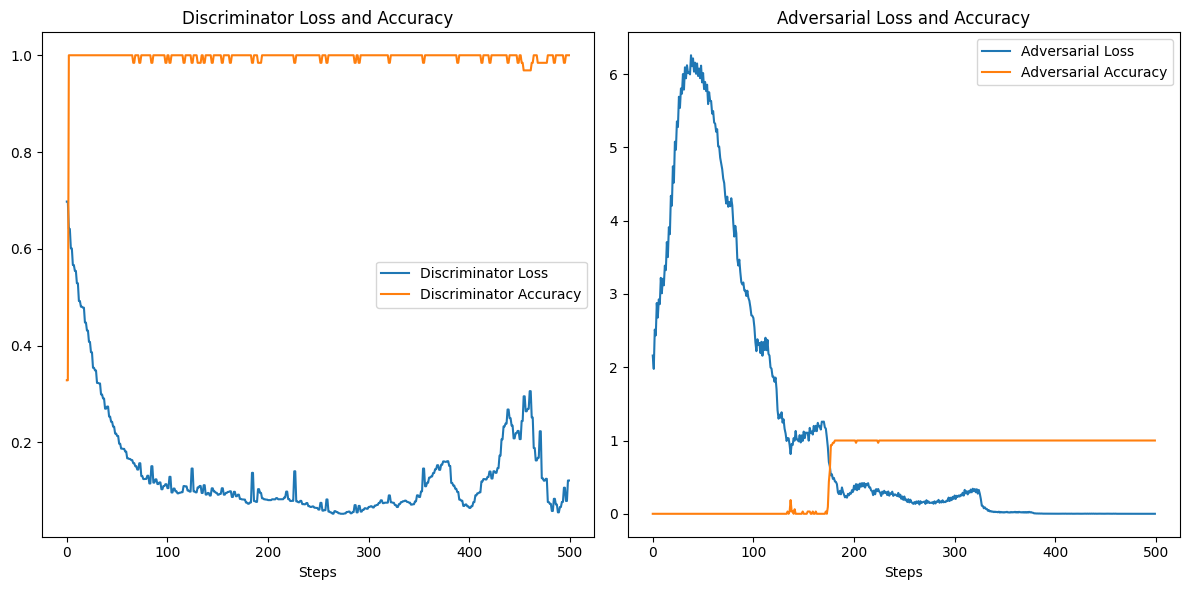

In [108]:


# Convert the list of numpy arrays into a numpy matrix
history_array = np.array(history)

# Extract discriminator and adversarial loss and accuracy
discriminator_loss = history_array[:, 0]
discriminator_accuracy = history_array[:, 1]
adversarial_loss = history_array[:, 2]
adversarial_accuracy = history_array[:, 3]

# Plotting
plt.figure(figsize=(12, 6))

# Plotting discriminator metrics
plt.subplot(1, 2, 1)
plt.plot(discriminator_loss, label='Discriminator Loss')
plt.plot(discriminator_accuracy, label='Discriminator Accuracy')
plt.title('Discriminator Loss and Accuracy')
plt.xlabel('Steps')
plt.legend()

# Plotting adversarial metrics
plt.subplot(1, 2, 2)
plt.plot(adversarial_loss, label='Adversarial Loss')
plt.plot(adversarial_accuracy, label='Adversarial Accuracy')
plt.title('Adversarial Loss and Accuracy')
plt.xlabel('Steps')
plt.legend()

plt.tight_layout()
plt.show()


In [109]:
# Load the saved models

from keras.models import load_model
generator=load_model('dgan_sound')
lr = 2e-4
decay = 6e-8
optimizer = RMSprop(lr=lr * 0.5, decay=decay * 0.5)
generator.compile(loss='binary_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy'])

noise = np.random.uniform(-1.0,
                                  1.0,
                                  size=[1, latent_dimensions])
        # generate fake images
fake_images = generator.predict(noise)
fake_images= fake_images[:, :, 253:512, :] #512-259 = 253, ideally id not hardcode this


1/1 [==============================] - 0s 103ms/step


c:\Users\abdul\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [110]:
fake=np.array(fake_images)
fake.shape

(1, 128, 259, 1)

In [111]:
#de normalizing and converting to .wav
import soundfile as sf

fake=denormalize(fake_images)



res = librosa.feature.inverse.mel_to_audio(fake, 
                                           sr=44100, 
                                           n_fft=2400,
                                           hop_length=512, 
                                           win_length=None, 
                                           window='hann', 
                                           center=True, 
                                           pad_mode='reflect', 
                                           power=2, 
                                           n_iter=32)

  #res = RESHAPE(res)
sf.write( "C:\\Users\\abdul\\Desktop\\ProjectNeuralNetworks\\gen2.wav" , res, 44100)

#this was all to test if we can regenerate our file

(128, 259)


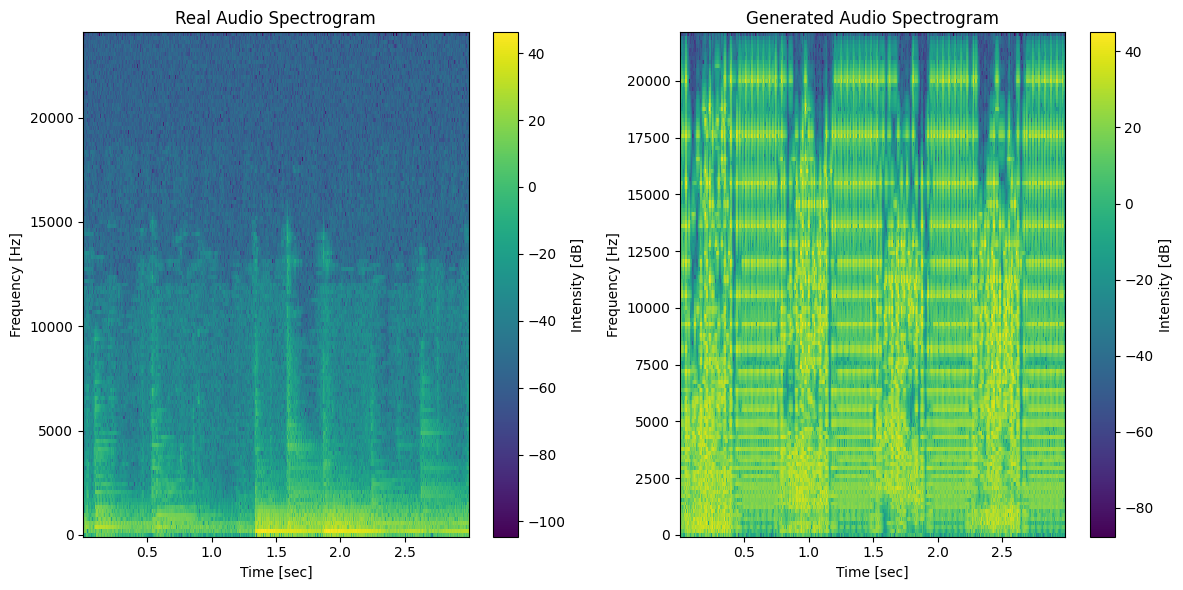

Euclidean distance between the spectrograms: 309592.8


In [112]:
#cute plot time
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import scipy.io.wavfile as wav

# Function to generate a spectrogram from an audio file
def generate_spectrogram(file_path):
    # Load the audio file
    rate, audio = wav.read(file_path)

    # If stereo, convert to mono
    if len(audio.shape) == 2:
        audio = np.mean(audio, axis=1)

    # Generate the spectrogram
    frequencies, times, spectrogram = scipy.signal.spectrogram(audio, fs=rate)

    return frequencies, times, spectrogram

# Function to plot a spectrogram
def plot_spectrogram(frequencies, times, spectrogram, title):
    plt.pcolormesh(times, frequencies, 10 * np.log10(spectrogram))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(title)
    plt.colorbar(label='Intensity [dB]')

# Load and generate spectrograms for the real and generated audio files
file_path_generated  = 'C:/Users/abdul/Desktop/ProjectNeuralNetworks/gen2.wav'
file_path_real = 'C:/Users/abdul/Desktop/ProjectNeuralNetworks/segments/DataSample1_segment_5.wav' #some random sample from the files

frequencies_real, times_real, spectrogram_real = generate_spectrogram(file_path_real)
frequencies_generated, times_generated, spectrogram_generated = generate_spectrogram(file_path_generated)

# Plot the spectrograms
plt.figure(figsize=(12, 6))

# Plot real audio spectrogram
plt.subplot(1, 2, 1)
plot_spectrogram(frequencies_real, times_real, spectrogram_real, 'Real Audio Spectrogram')

# Plot generated audio spectrogram
plt.subplot(1, 2, 2)
plot_spectrogram(frequencies_generated, times_generated, spectrogram_generated, 'Generated Audio Spectrogram')

plt.tight_layout()
plt.show()

# Calculate the Euclidean distance between the two spectrograms
# Ensure that the spectrograms are of the same shape
spectrogram_real_resized = spectrogram_real[:, :min(spectrogram_real.shape[1], spectrogram_generated.shape[1])]
spectrogram_generated_resized = spectrogram_generated[:, :spectrogram_real_resized.shape[1]]

# Compute the Euclidean distance
euclidean_distance = np.linalg.norm(spectrogram_real_resized - spectrogram_generated_resized)
print("Euclidean distance between the spectrograms:", euclidean_distance)


C:\Users\abdul\AppData\Local\Temp\ipykernel_24004\863330621.py:23: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(times, frequencies, 10 * np.log10(spectrogram))


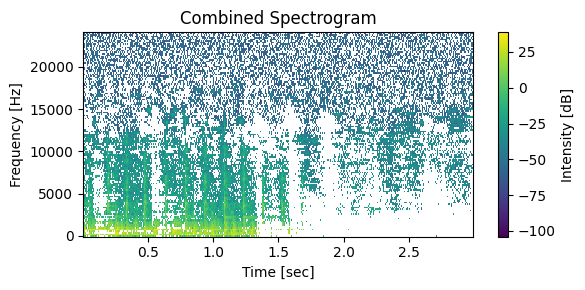

In [126]:
#this is one way of combining the 2 spectra
# Resize spectrograms to the same shape for comparison
spectrogram_real_resized = spectrogram_real[:, :min(spectrogram_real.shape[1], spectrogram_generated.shape[1])]
spectrogram_generated_resized = spectrogram_generated[:, :spectrogram_real_resized.shape[1]]

# Negate the generated spectrogram

spectrogram_real_inverted=-spectrogram_real_resized
# Add the inverted generated spectrogram to the real spectrogram
combined_spectrogram = spectrogram_generated_resized + spectrogram_real_inverted

#in case you wanted to subtract them the other way around:

# spectrogram_generated_inverted = -spectrogram_generated_resized 
# combined_spectrogram = spectrogram_real_resized + spectrogram_generated_inverted

# Plot the combined spectrogram
plt.figure(figsize=(6, 3))
plot_spectrogram(frequencies_real, times_real[:combined_spectrogram.shape[1]], combined_spectrogram, 'Combined Spectrogram')
plt.tight_layout()
plt.show()




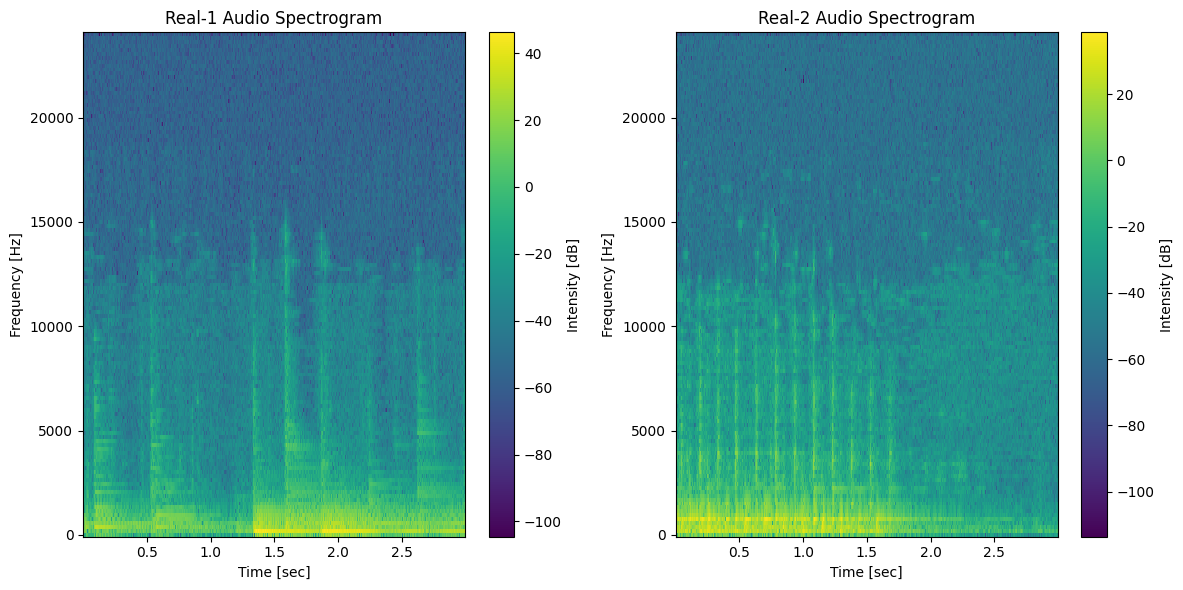

Euclidean distance between the spectrograms: 168411.89


In [114]:
#cute plot time- this time to compare 2 real spectra
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import scipy.io.wavfile as wav

# Function to generate a spectrogram from an audio file
def generate_spectrogram(file_path):
    # Load the audio file
    rate, audio = wav.read(file_path)

    # If stereo, convert to mono
    if len(audio.shape) == 2:
        audio = np.mean(audio, axis=1)

    # Generate the spectrogram
    frequencies, times, spectrogram = scipy.signal.spectrogram(audio, fs=rate)

    return frequencies, times, spectrogram

# Function to plot a spectrogram
def plot_spectrogram(frequencies, times, spectrogram, title):
    plt.pcolormesh(times, frequencies, 10 * np.log10(spectrogram))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(title)
    plt.colorbar(label='Intensity [dB]')

# Load and generate spectrograms for the real and generated audio files
file_path_generated  = 'C:/Users/abdul/Desktop/ProjectNeuralNetworks/segments/DataSample1_segment_500.wav'
file_path_real = 'C:/Users/abdul/Desktop/ProjectNeuralNetworks/segments/DataSample1_segment_5.wav' #some random sample from the files

frequencies_real, times_real, spectrogram_real = generate_spectrogram(file_path_real)
frequencies_generated, times_generated, spectrogram_generated = generate_spectrogram(file_path_generated)

# Plot the spectrograms
plt.figure(figsize=(12, 6))

# Plot real audio spectrogram
plt.subplot(1, 2, 1)
plot_spectrogram(frequencies_real, times_real, spectrogram_real, 'Real-1 Audio Spectrogram')

# Plot generated audio spectrogram
plt.subplot(1, 2, 2)
plot_spectrogram(frequencies_generated, times_generated, spectrogram_generated, 'Real-2 Audio Spectrogram')

plt.tight_layout()
plt.show()

# Calculate the Euclidean distance between the two spectrograms
# Ensure that the spectrograms are of the same shape
spectrogram_real_resized = spectrogram_real[:, :min(spectrogram_real.shape[1], spectrogram_generated.shape[1])]
spectrogram_generated_resized = spectrogram_generated[:, :spectrogram_real_resized.shape[1]]

# Compute the Euclidean distance
euclidean_distance = np.linalg.norm(spectrogram_real_resized - spectrogram_generated_resized)
print("Euclidean distance between the spectrograms:", euclidean_distance)


C:\Users\abdul\AppData\Local\Temp\ipykernel_24004\863330621.py:23: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(times, frequencies, 10 * np.log10(spectrogram))


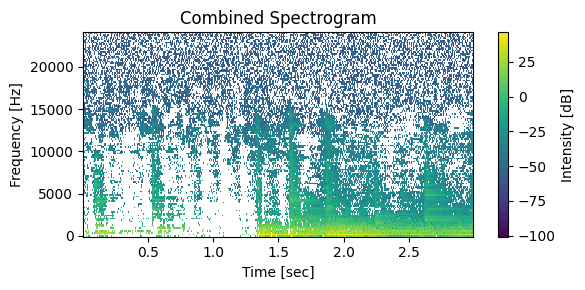

In [115]:

# Resize spectrograms to the same shape for comparison
spectrogram_real_resized = spectrogram_real[:, :min(spectrogram_real.shape[1], spectrogram_generated.shape[1])]
spectrogram_generated_resized = spectrogram_generated[:, :spectrogram_real_resized.shape[1]]

# Negate the generated spectrogram
spectrogram_generated_inverted = -spectrogram_generated_resized

# Add the inverted generated spectrogram to the real spectrogram
combined_spectrogram = spectrogram_real_resized + spectrogram_generated_inverted

# Plot the combined spectrogram
plt.figure(figsize=(6, 3))
plot_spectrogram(frequencies_real, times_real[:combined_spectrogram.shape[1]], combined_spectrogram, 'Combined Spectrogram')
plt.tight_layout()
plt.show()


In [116]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
